(ch6:multinet)=
# Multiple-Network Representation Learning

## Aliens and Humans

Say you're a brain researcher, and you have a bunch of scans of brains - some are scans of people, and some are scans of aliens. You have some code that estimates networks from your scans, so you turn all your scans into networks. The nodes represent the brain regions which are common to both humans and aliens (isn't evolution amazing?), and the edges represent communication between these brain regions. You want to know if the human and alien networks share a common grouping of regions (your research topic is titled, "Do Alien Brains Have The Same Hemispheres That We Do?"). What do you do? How do you even deal with situations in which you have a lot of networks whose nodes all represent the same objects, but whose edges might come from totally different distributions?

Well, if your goal is to find shared node structure between the humans and aliens, we learned in the previous section {numref}`ch6:spectral` that spectral embeddings might be a good starting point. However, we only learned how to embed one network. How, exactly, can we embed multiple networks?

To make this example a little more concrete, let's say you have four alien networks and four human networks. Since alien brain networks aren't currently very accessible, we'll simulate human and alien brain networks by assuming that they are samples of stochastic block models from {numref}`ch5:sbm`. Unfortunately, human and alien brains are quite a bit different. As it turns out, human brains tend to exhibit within-hemisphere affinity: the connections between pairs of nodes in the same hemisphere are more probable than connections between pairs of nodes in different hemispheres. Alien brains do, too, but with a twist: the left and right hemispheres are also split into two more regions which also have within-region affinity!

We'll use a relatively small number of nodes ($100$) and fairly small block probabilities. You can see the specific parameters in the code below.

In [1]:
import warnings
import numpy as np
warnings.filterwarnings("ignore")
np.random.seed(42)
%load_ext autoreload

In [2]:
import numpy as np
from graspologic.simulations import sbm

# make four human networks
# and four alien networks
pwithin = 0.2; pbtwn = 0.02
n = 100
M = 8
labels = [0]*n + [1]*n
Phuman = np.array([[pwithin, pbtwn], [pbtwn, pwithin]])
Palien = np.array([[pbtwn, pwithin], [pwithin, pbtwn]])
humans = [sbm([int(n/2) for i in range(2)], Phuman) for i in range(int(M/2))]
aliens = [sbm([int(n/2) for i in range(2)], Palien) for i in range(int(M/2))]
# concatenate list of human and alien networks
networks = humans + aliens

In [3]:
human_labs = ["L" for i in range(int(n/2))] + ["R" for i in range(int(n/2))]
alien_labs = human_labs

The human and alien networks come from very different distributions. As you can see from the Stochastic Block Model structure below, the regions in the human and the alien brains can both be separated into two communities. These communities represent the two hemispheres of the brain (who knew aliens also have two-hemisphere brains!). Although both humans and aliens have the same regions belonging to their respective hemispheres, as you planned, the alien networks have a strange property: their brain regions have more connections with regions in the opposite hemisphere than the same one.

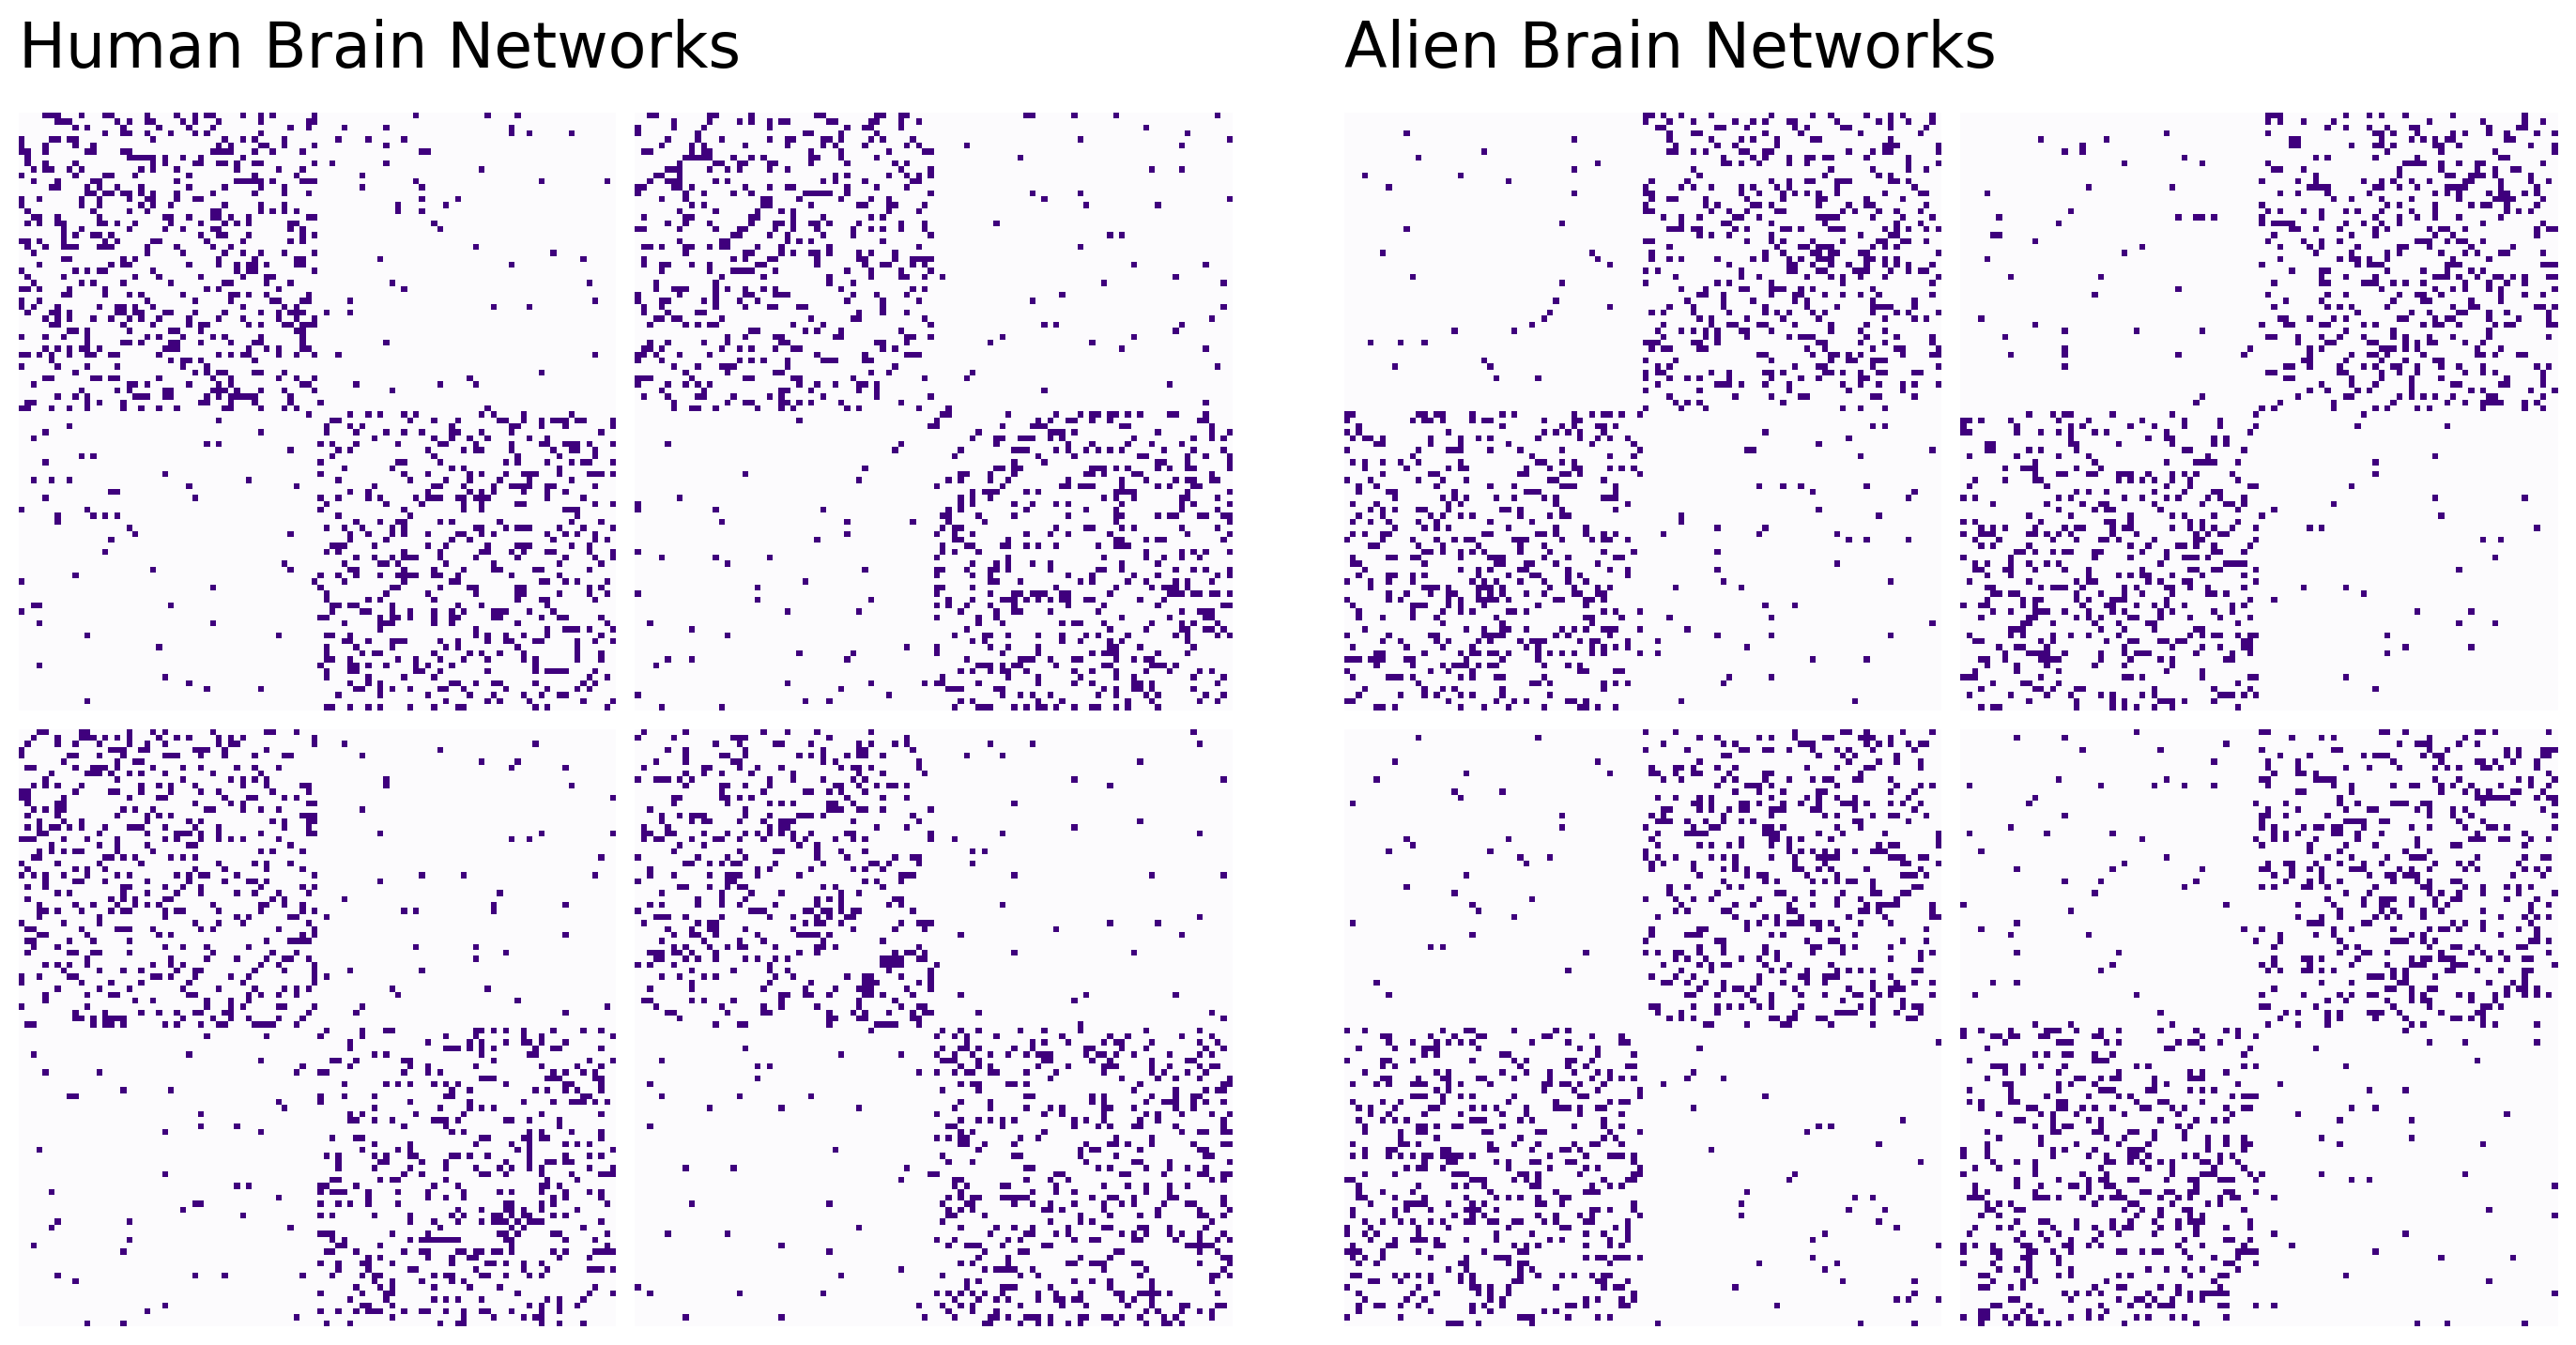

In [4]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
from graphbook_code import heatmap

%config InlineBackend.figure_format = 'retina'

fig = plt.figure(figsize=(14,7))

grid1 = ImageGrid(fig, 121, (2, 2), axes_pad=.1, share_all=True)
grid2 = ImageGrid(fig, 122, (2, 2), axes_pad=.1, share_all=True)

for i, (axi, axj) in enumerate(zip(grid1, grid2)):
    hmn = heatmap(humans[i], ax=axi, cbar=False)
    hma = heatmap(aliens[i], ax=axj, cbar=False)
    

grid1.axes_all[0].set_title("Human Brain Networks", fontsize=24, y=1.05, loc="left")
grid2.axes_all[0].set_title("Alien Brain Networks", fontsize=24, y=1.05, loc="left")

plt.tight_layout(w_pad=3)

## Embedding networks through averaging

### Conditional averaging and then embedding

Remember, your goal is to identify whether humans and aliens have similar or different structure to their nodes. You're going to try to to embed your brain networks into some lower-dimensional space - that way, you can use standard clustering methods from machine learning to figure out how the nodes are structured.

The first idea you might come up with is to average your networks together, and then embed the result of that averaging with spectral embedding. It turns out that this is actually the right idea in the very special case where all of your networks come from the same probability distribution. In your case, you'll try averaging your groups of networks separately: you'll treat the human networks as one group, and the alien networks as another group, and you'll average each independently. In the end, you'll have two separate embeddings. Let's take a look at the average networks first:

In [5]:
from graspologic.embed import LaplacianSpectralEmbed as ASE

# Compute the average adjacency matrix for 
# human brains and alien brains
human_mean_network = np.array(humans).mean(axis=0)
alien_mean_network = np.array(aliens).mean(axis=0)

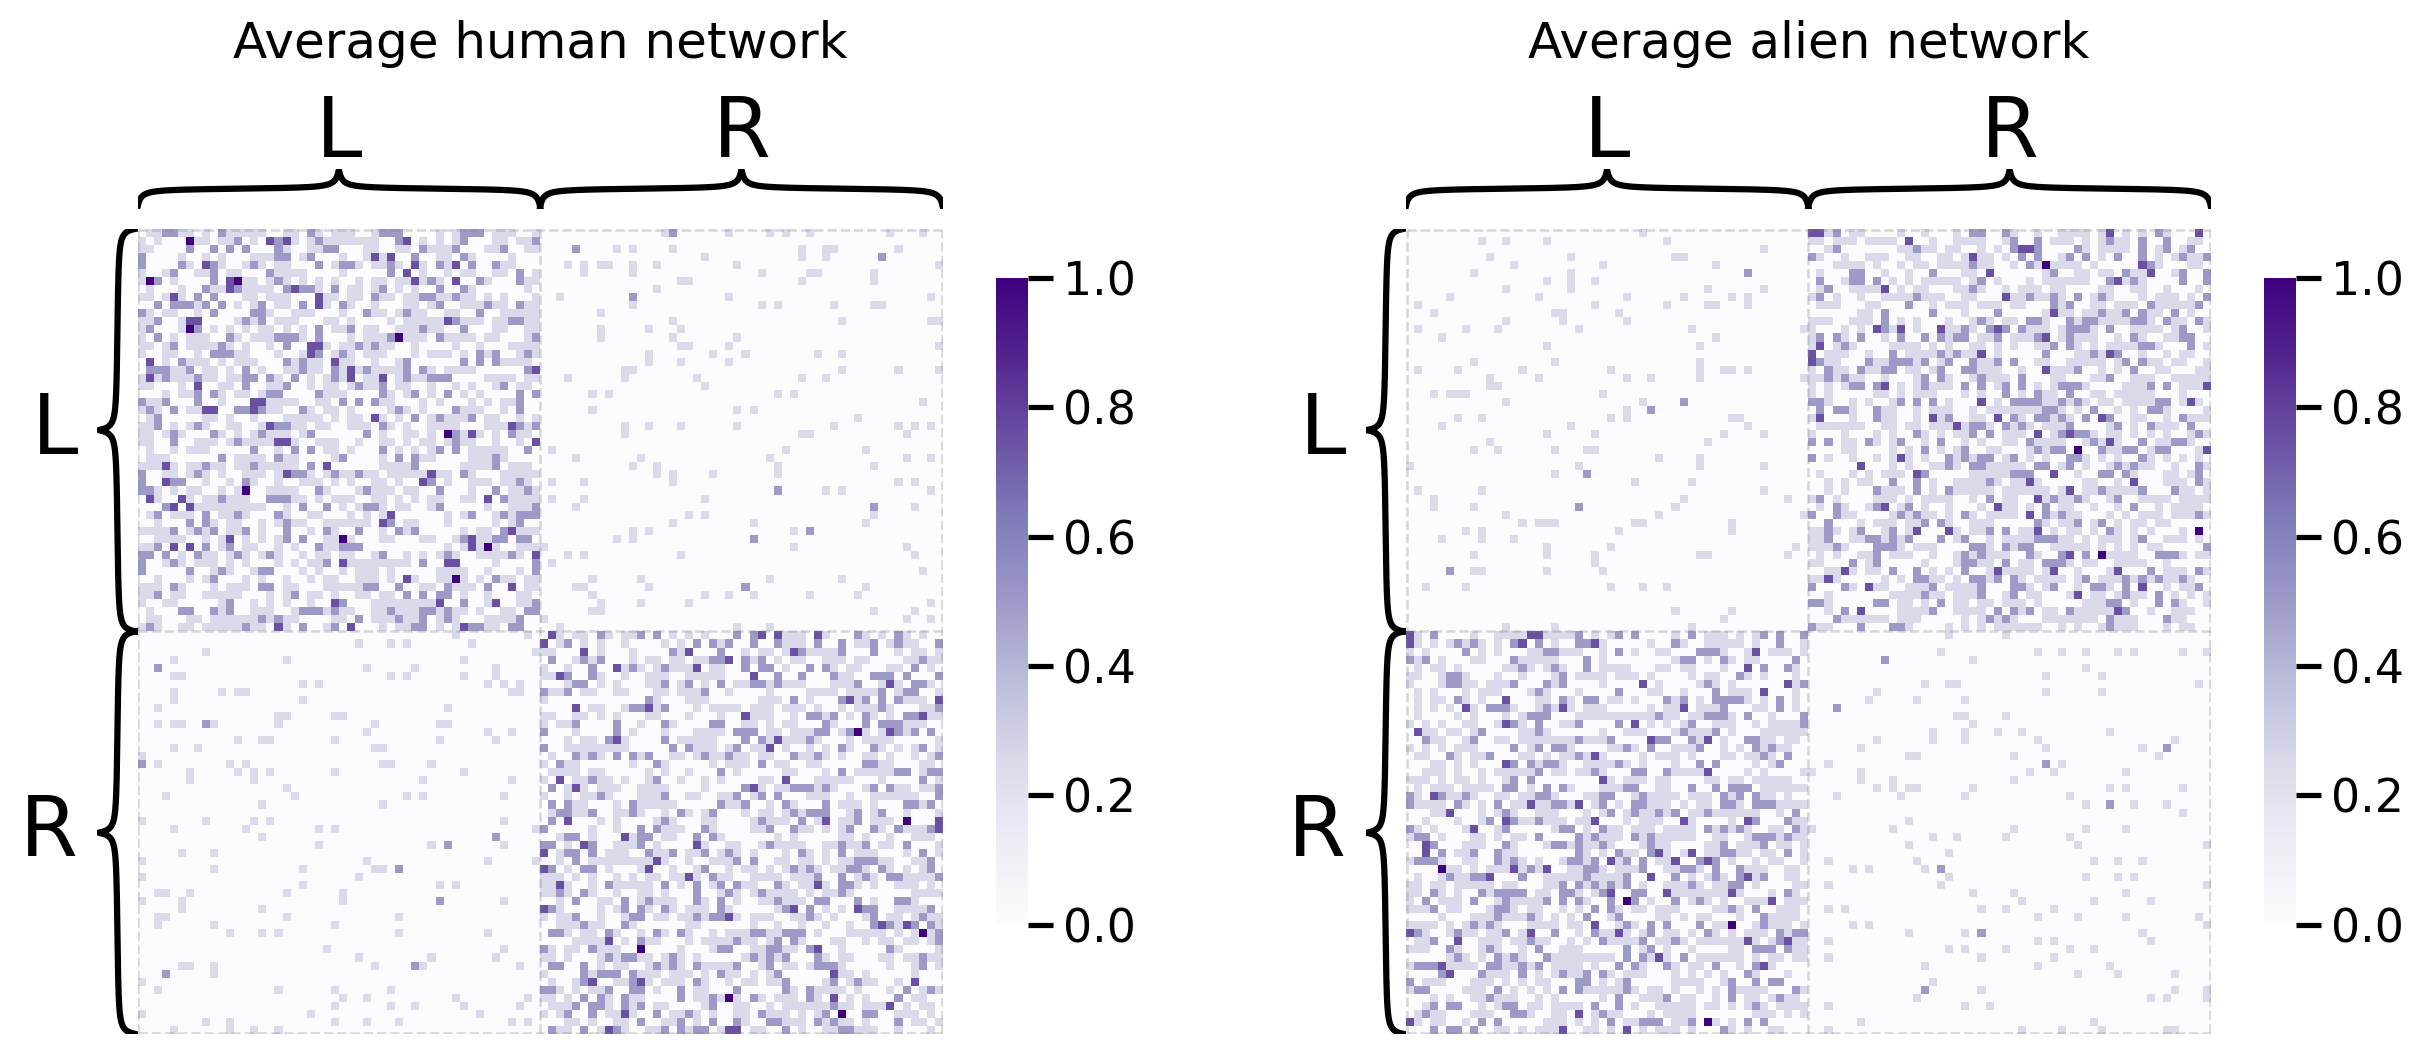

In [6]:
fig, axs = plt.subplots(1,2, figsize=(15, 6))

heatmap(human_mean_network, inner_hier_labels=human_labs, title="Average human network", ax=axs[0])
heatmap(alien_mean_network, inner_hier_labels=alien_labs, title="Average alien network", ax=axs[1]);

And next, we'll embed them:

In [7]:
# Embed both average networks
human_latents = ASE().fit_transform(human_mean_network)
alien_latents = ASE().fit_transform(alien_mean_network)

Below, you can see what happens when you embed the averaged human and alien networks separately. We'll visualize these as pairs plots separately for the average human network first:

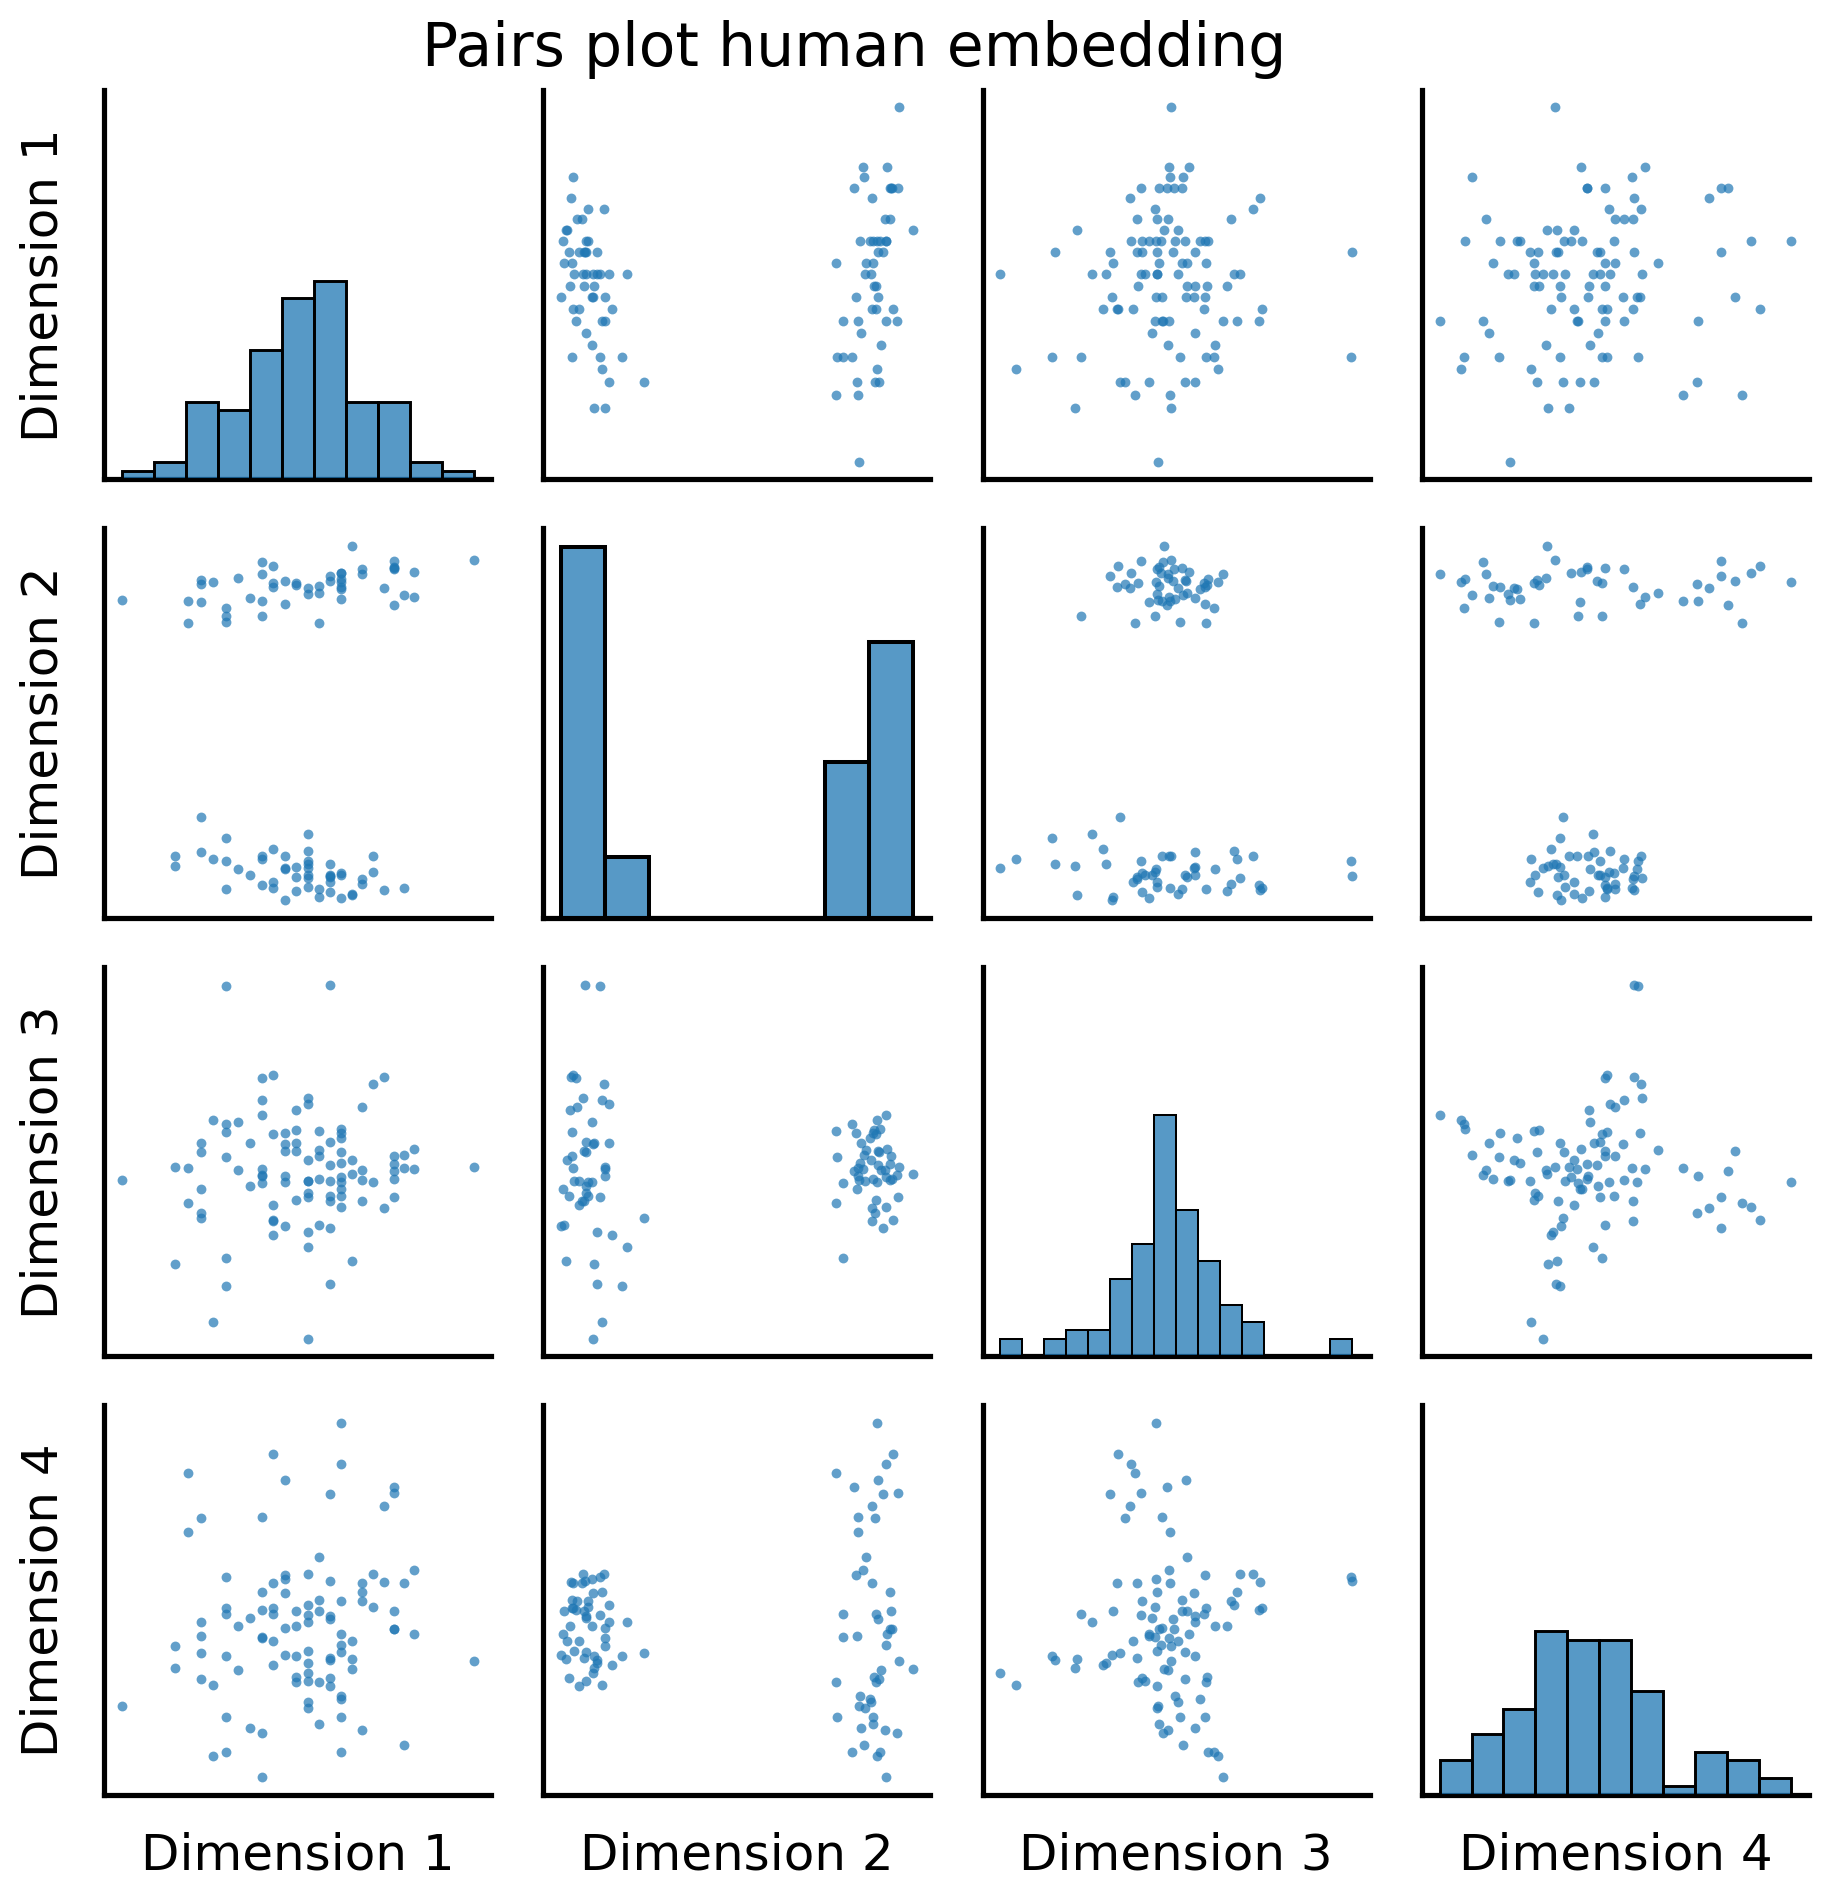

In [8]:
from graspologic.plot import pairplot

fig = pairplot(human_latents, title="Pairs plot human embedding");

We can see there are two pretty distinct "blobs" of nodes, which correspond to the two communities in human brains:

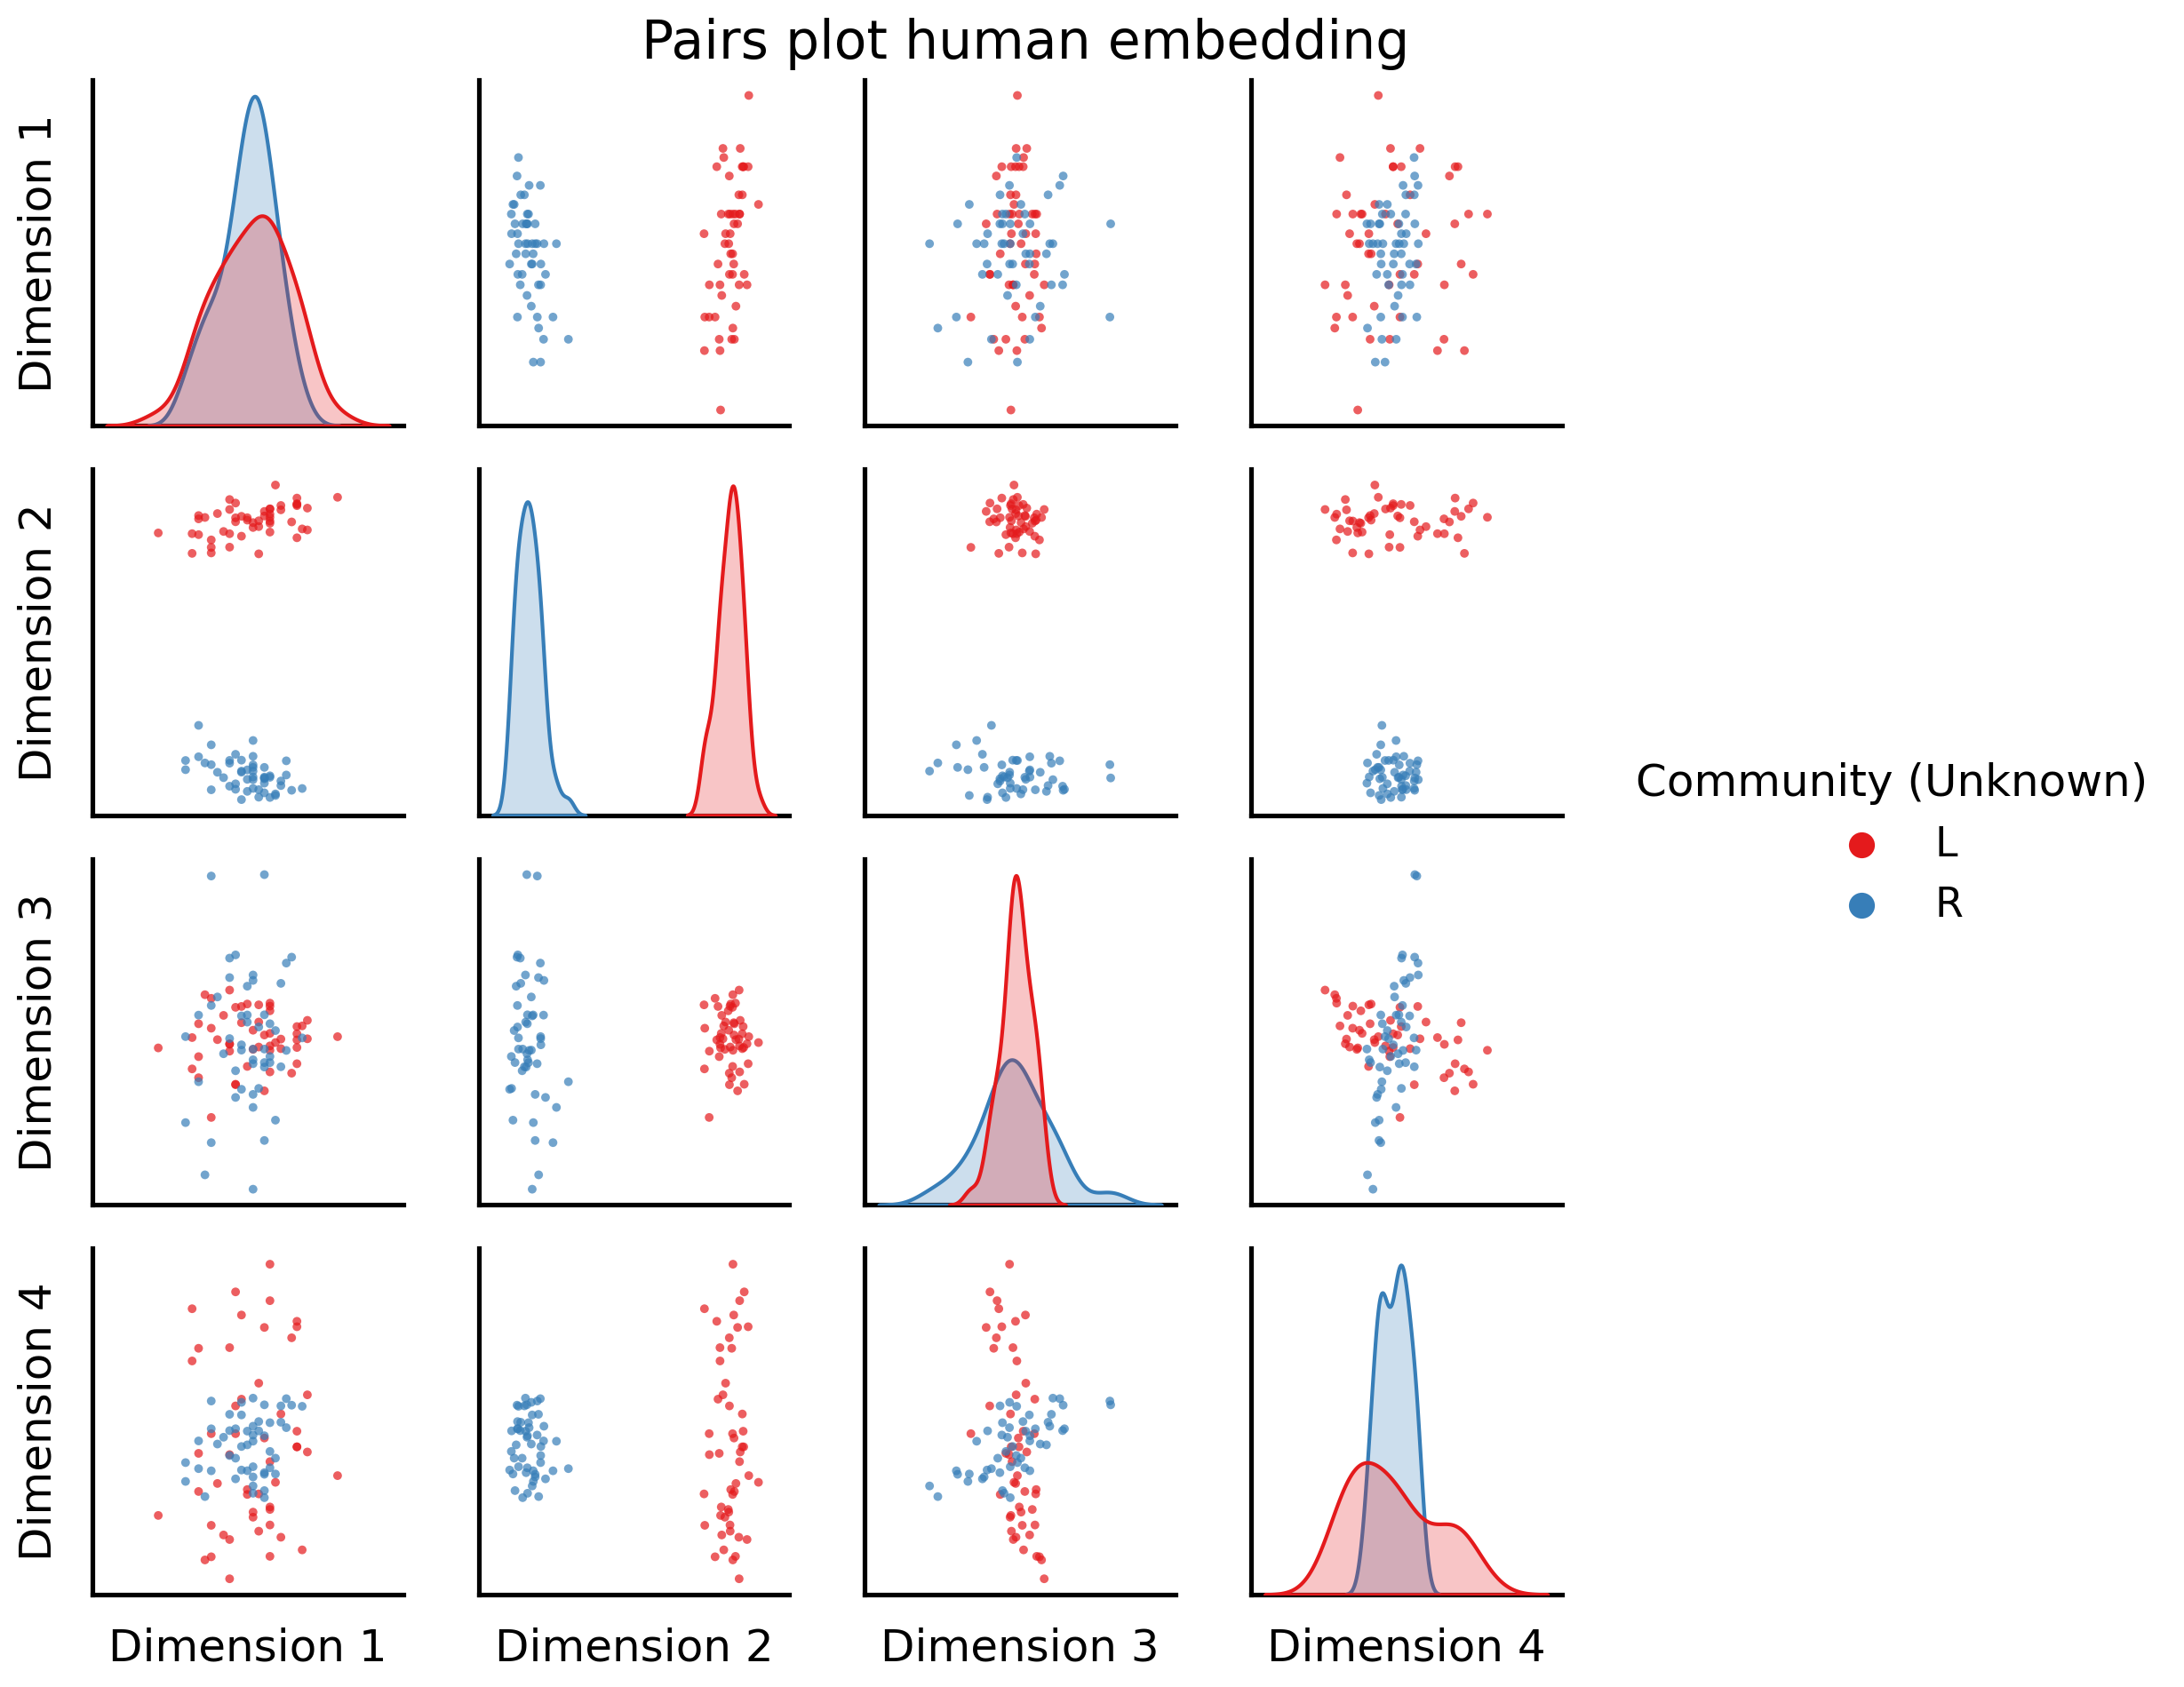

In [9]:
fig = pairplot(human_latents, title="Pairs plot human embedding",
               labels=human_labs,
               legend_name="Community (Unknown)");

Dimension 2 is extremely clearly here separating the nodes into left and right hemispheres.

Now let's see what happens when we do the same thing for the aliens:

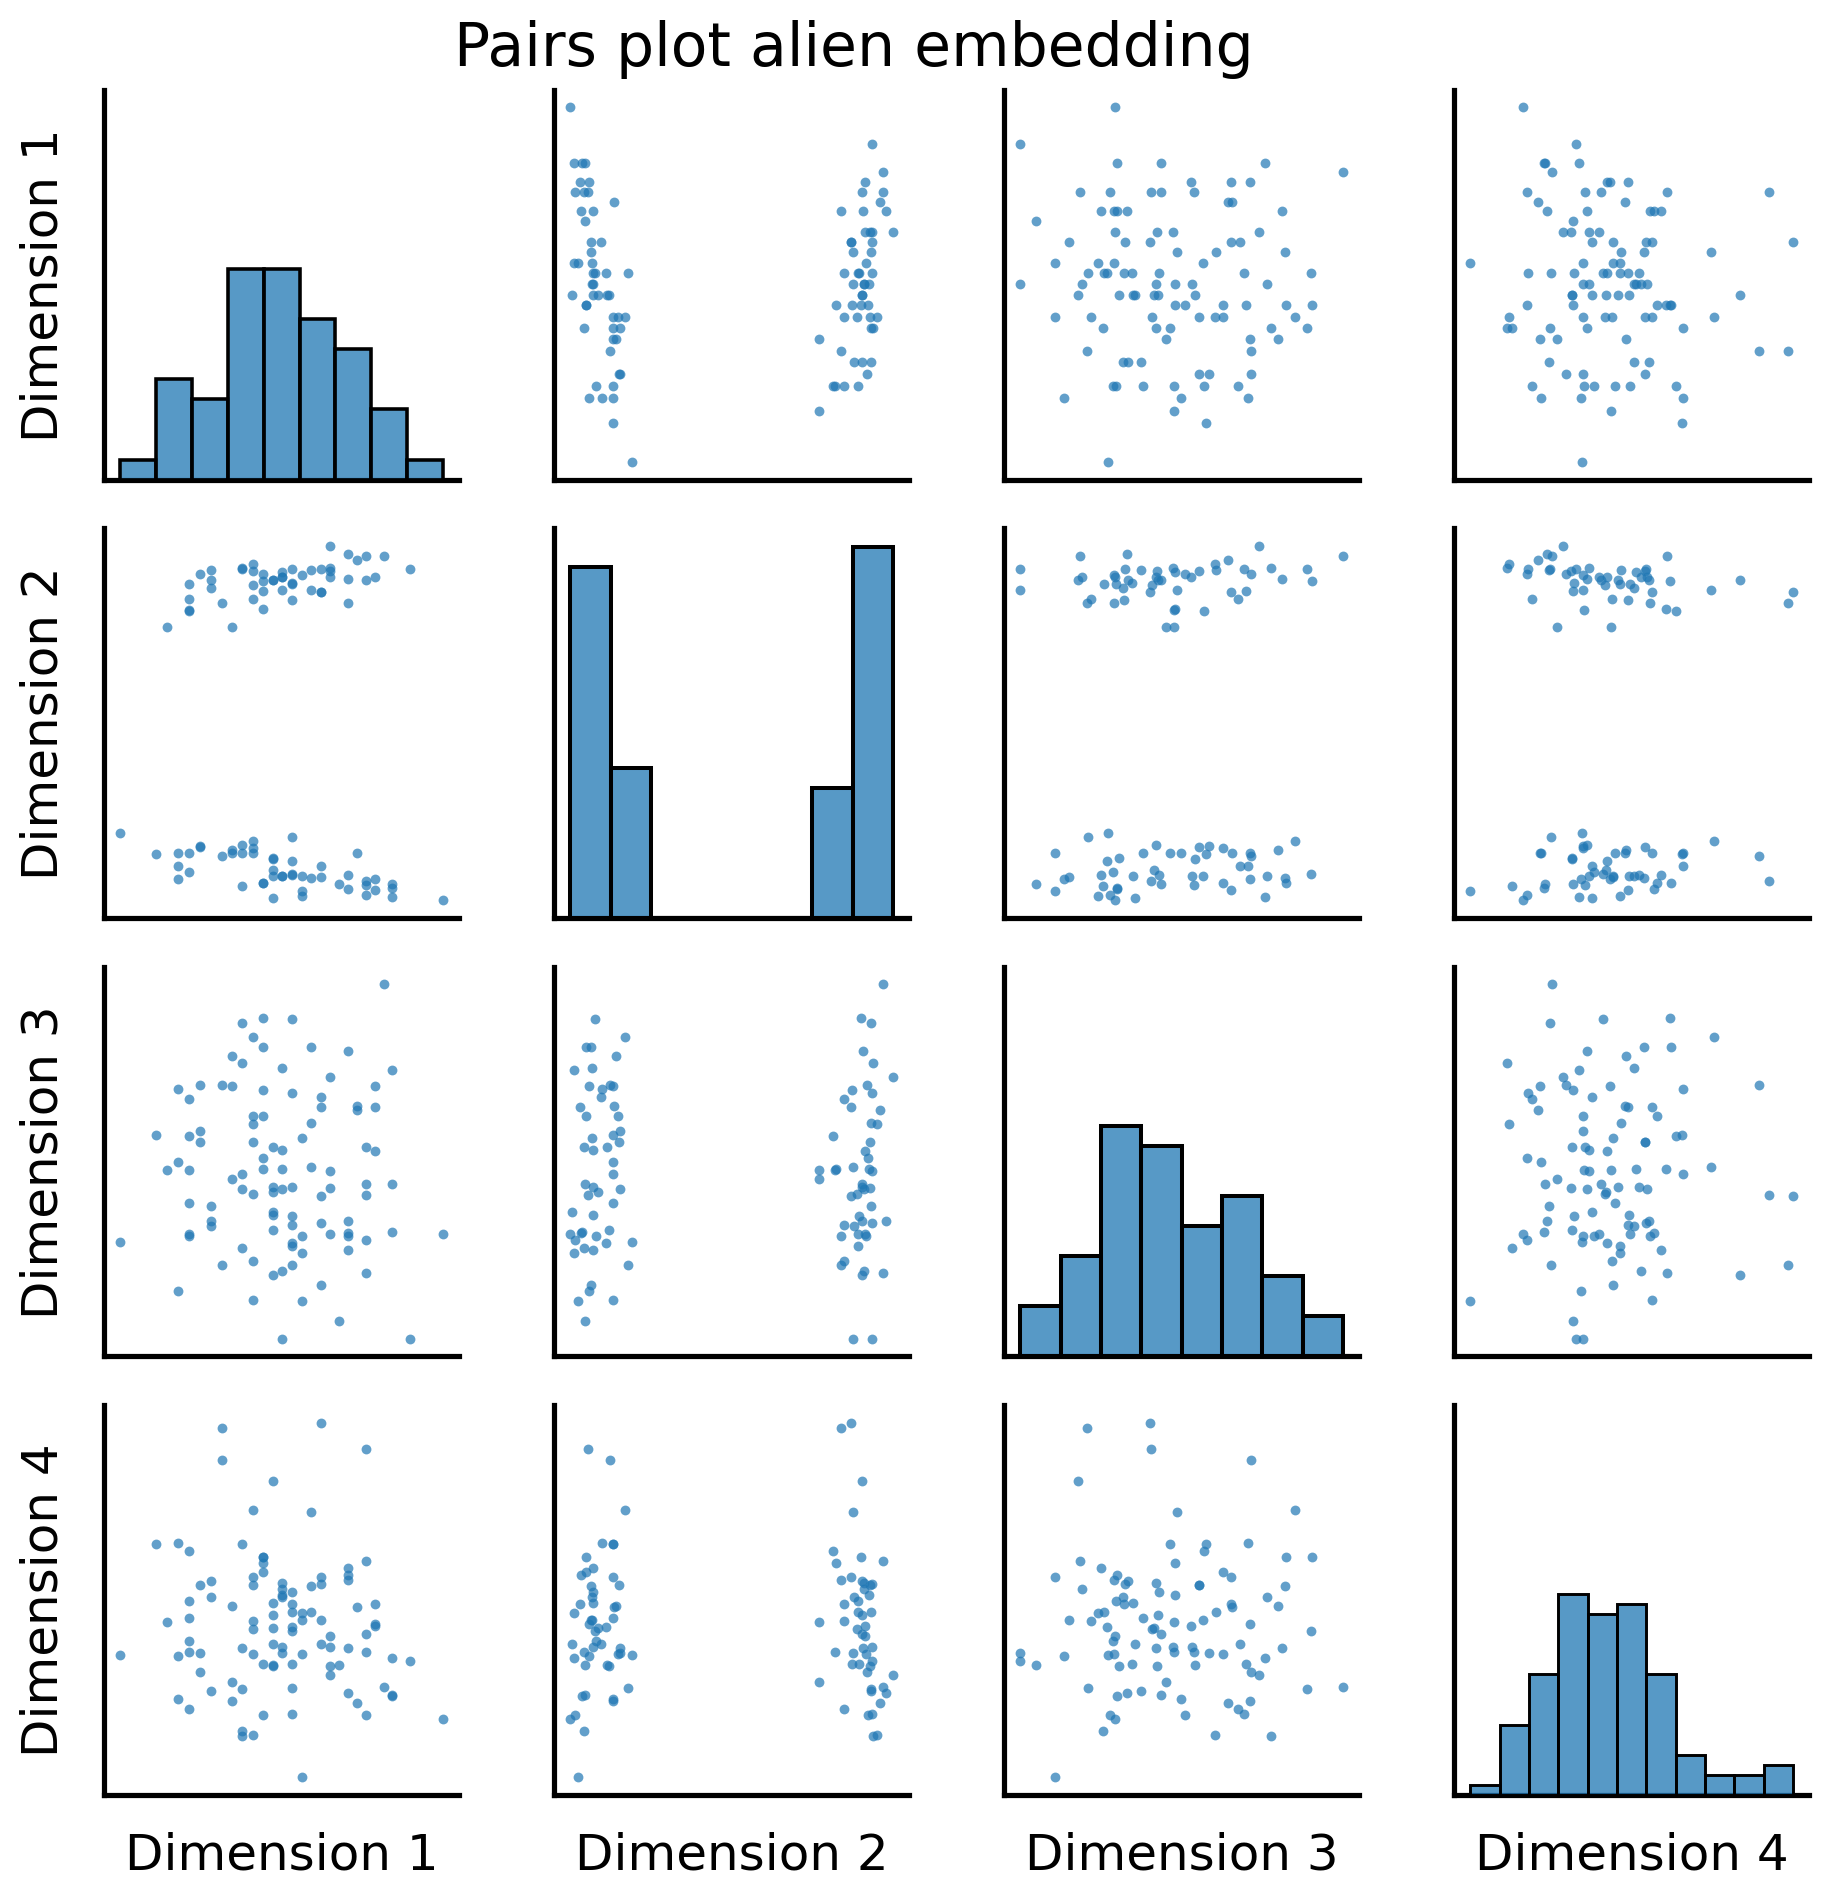

In [10]:
fig = pairplot(alien_latents, title="Pairs plot alien embedding");

And again, with the two community labels:

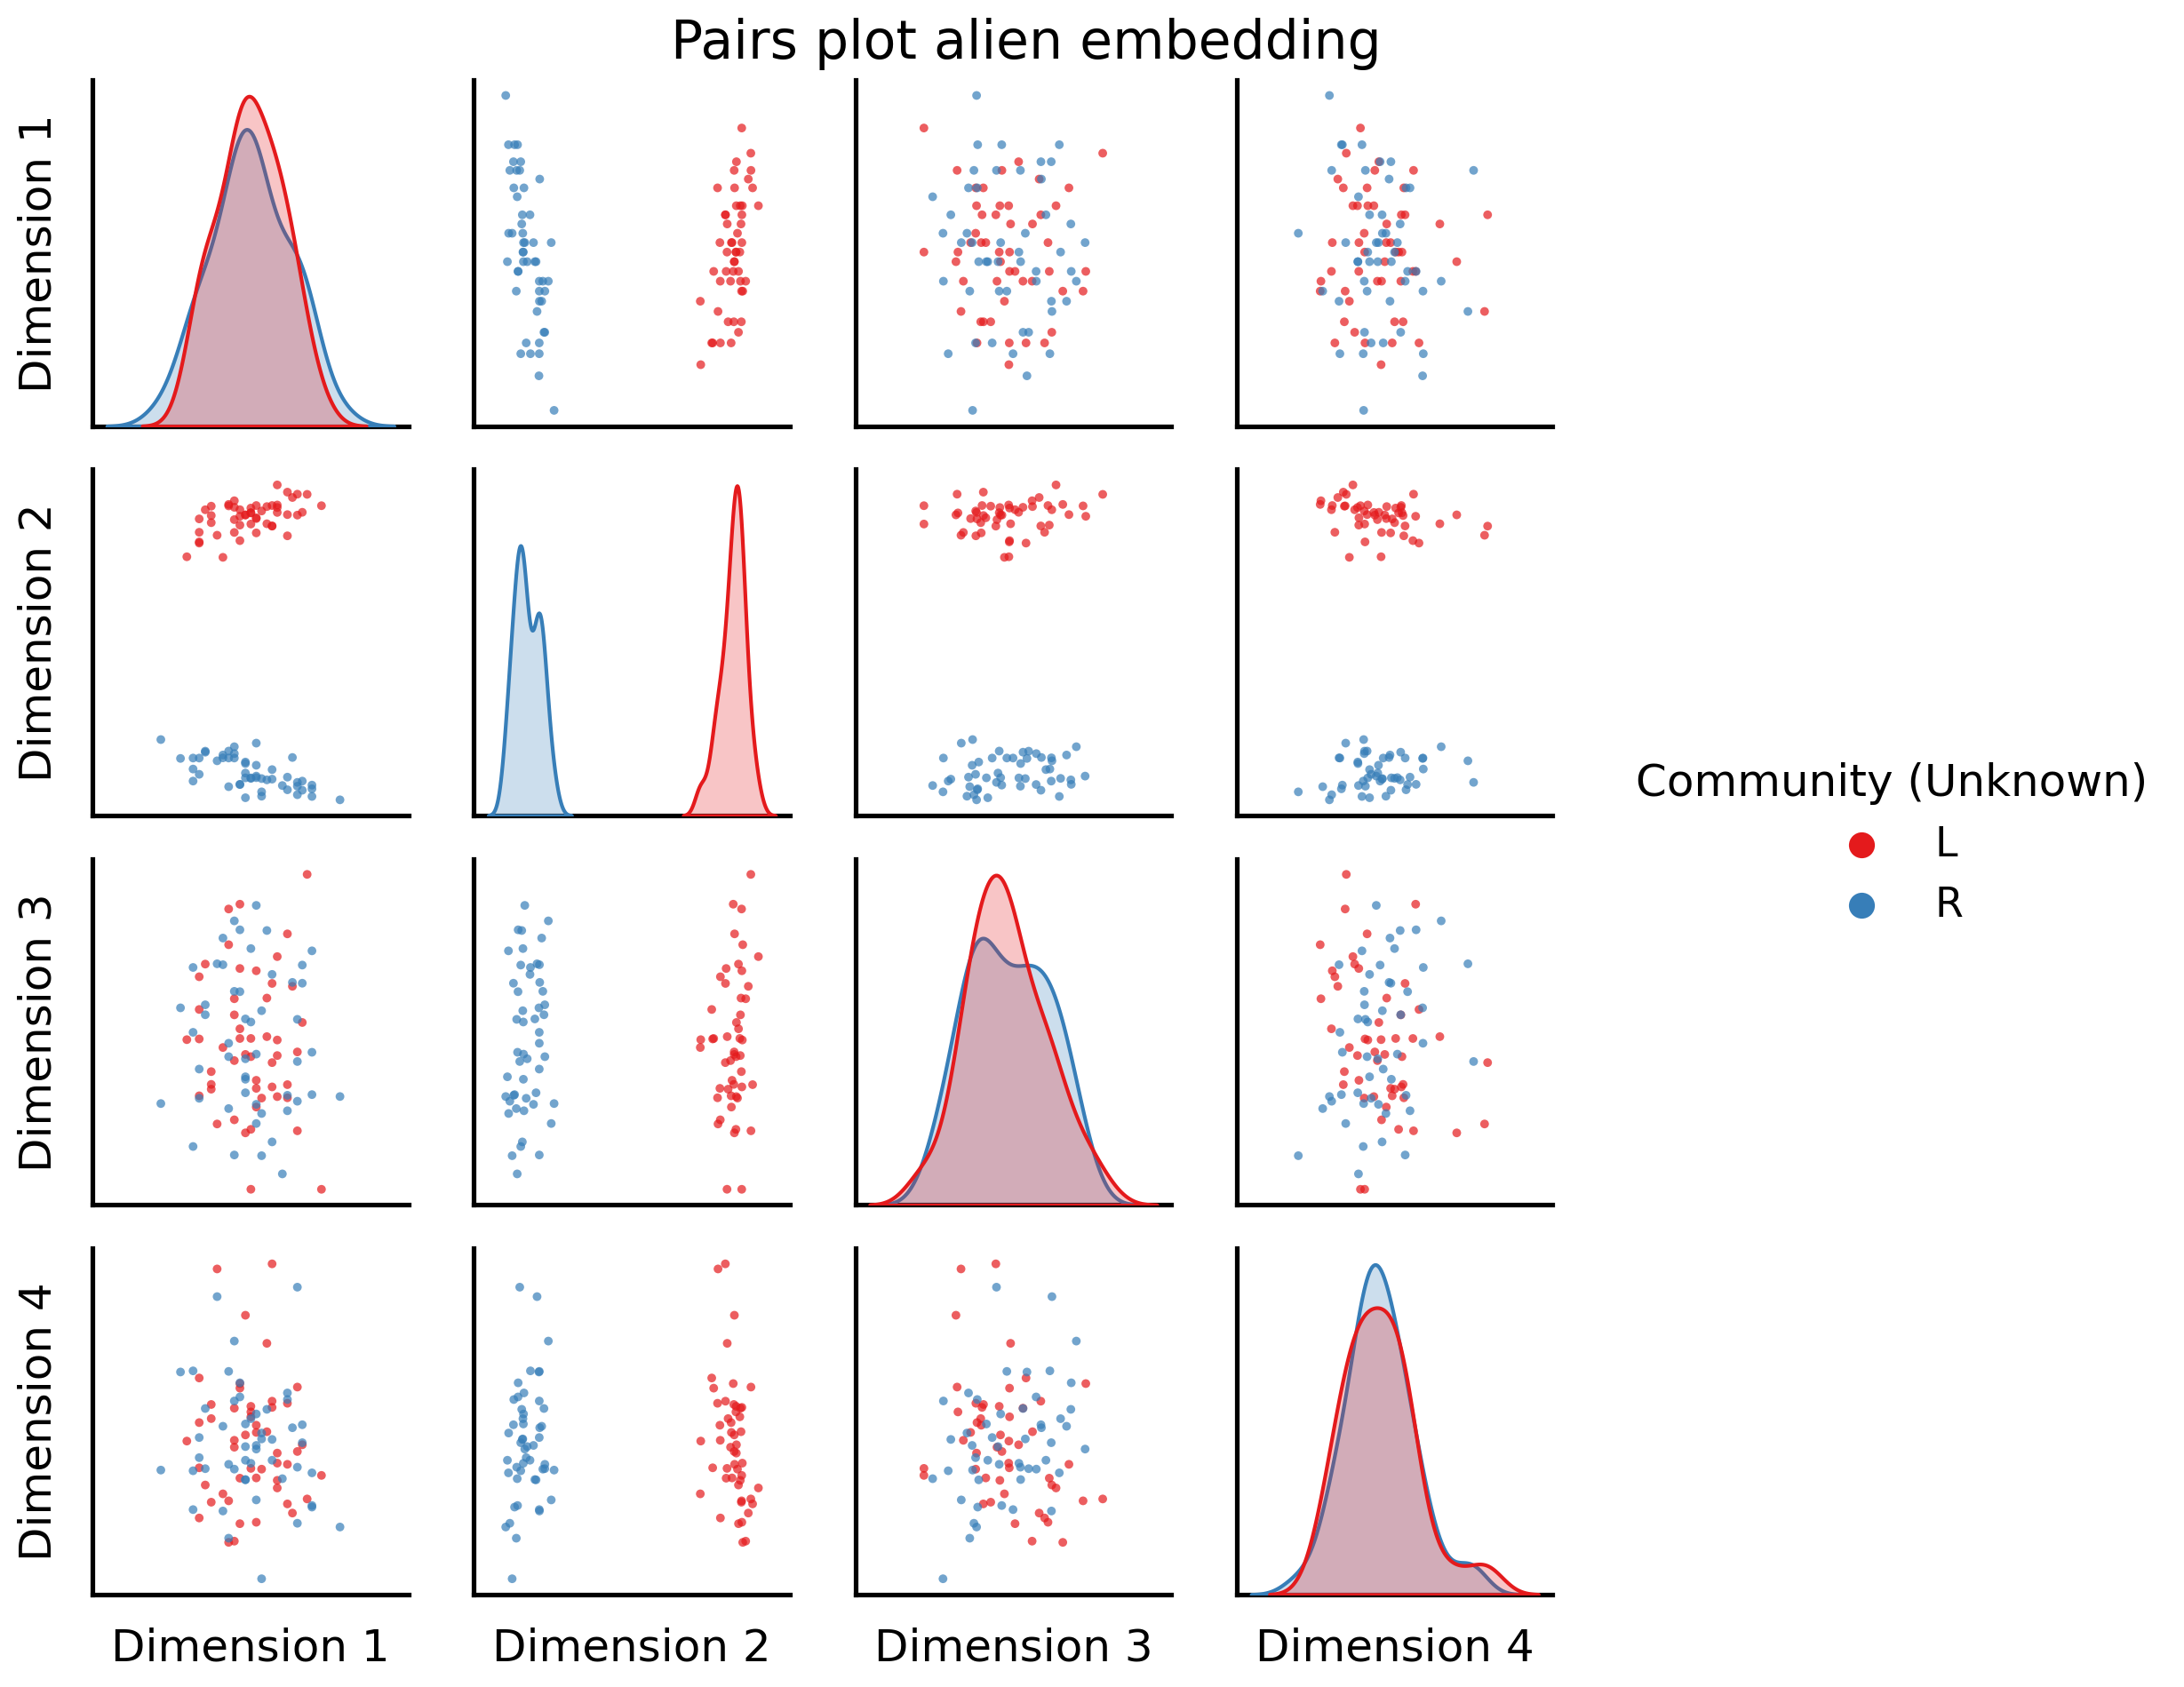

In [11]:
fig = pairplot(alien_latents, title="Pairs plot alien embedding",
               labels=alien_labs,
               legend_name="Community (Unknown)");

Now, when we compare the embeddings, we can see again Dimension 2 is extremely clearly separating the nodes into Left/Right groupings (all of the nodes in the left hemisphere are in one blob, and all of the nodes in the other hemisphere are in the other blob), and then  successive dimensions (coupled with dimension 2) give us extremely strong separation between the two sub-groups for each hemisphere. 

However, we have a problem, and it's the big warning we brought up at the end of the spectral-embedding section: the non-identifiability problem from {numref}`ch6:spectral:nonidentifiable`. The problem is as follows: we have shared structure between the alien and human brains. This means that, to be maximally efficient, we *should* be able to learn from the aliens and humans simultaneously, since the *shared* information from both (the left/right hemisphere separation) is *common* across the aliens and humans. However, the spectral embeddings from the humand and alien brains are not comparable, because we have no way of knowing ahead of time whether the human and alien brains are properly rotated with one another. In two-sample testing in {numref}`ch8:twosample`, we will cover a possible way to rectify this rotation issue, but let's see for now if we could come up with other solutions first that don't require us to try to un-rotate networks.

### Averaging Together

But what if you wanted to embed *all* of the networks into the same space, both the human and the alien networks, so that there's only one plot? Let's try it. You'll take all of the networks and then average them together, and then do an adjacency spectral embedding. This will result in a single plot, with each point representing a single brain region. Do you think you'll still find this nice community separation?

In [12]:
total_mean_matrix = np.array(networks).mean(axis=0)

And let's take a look at the resulting average network, against the average human and alien networks:

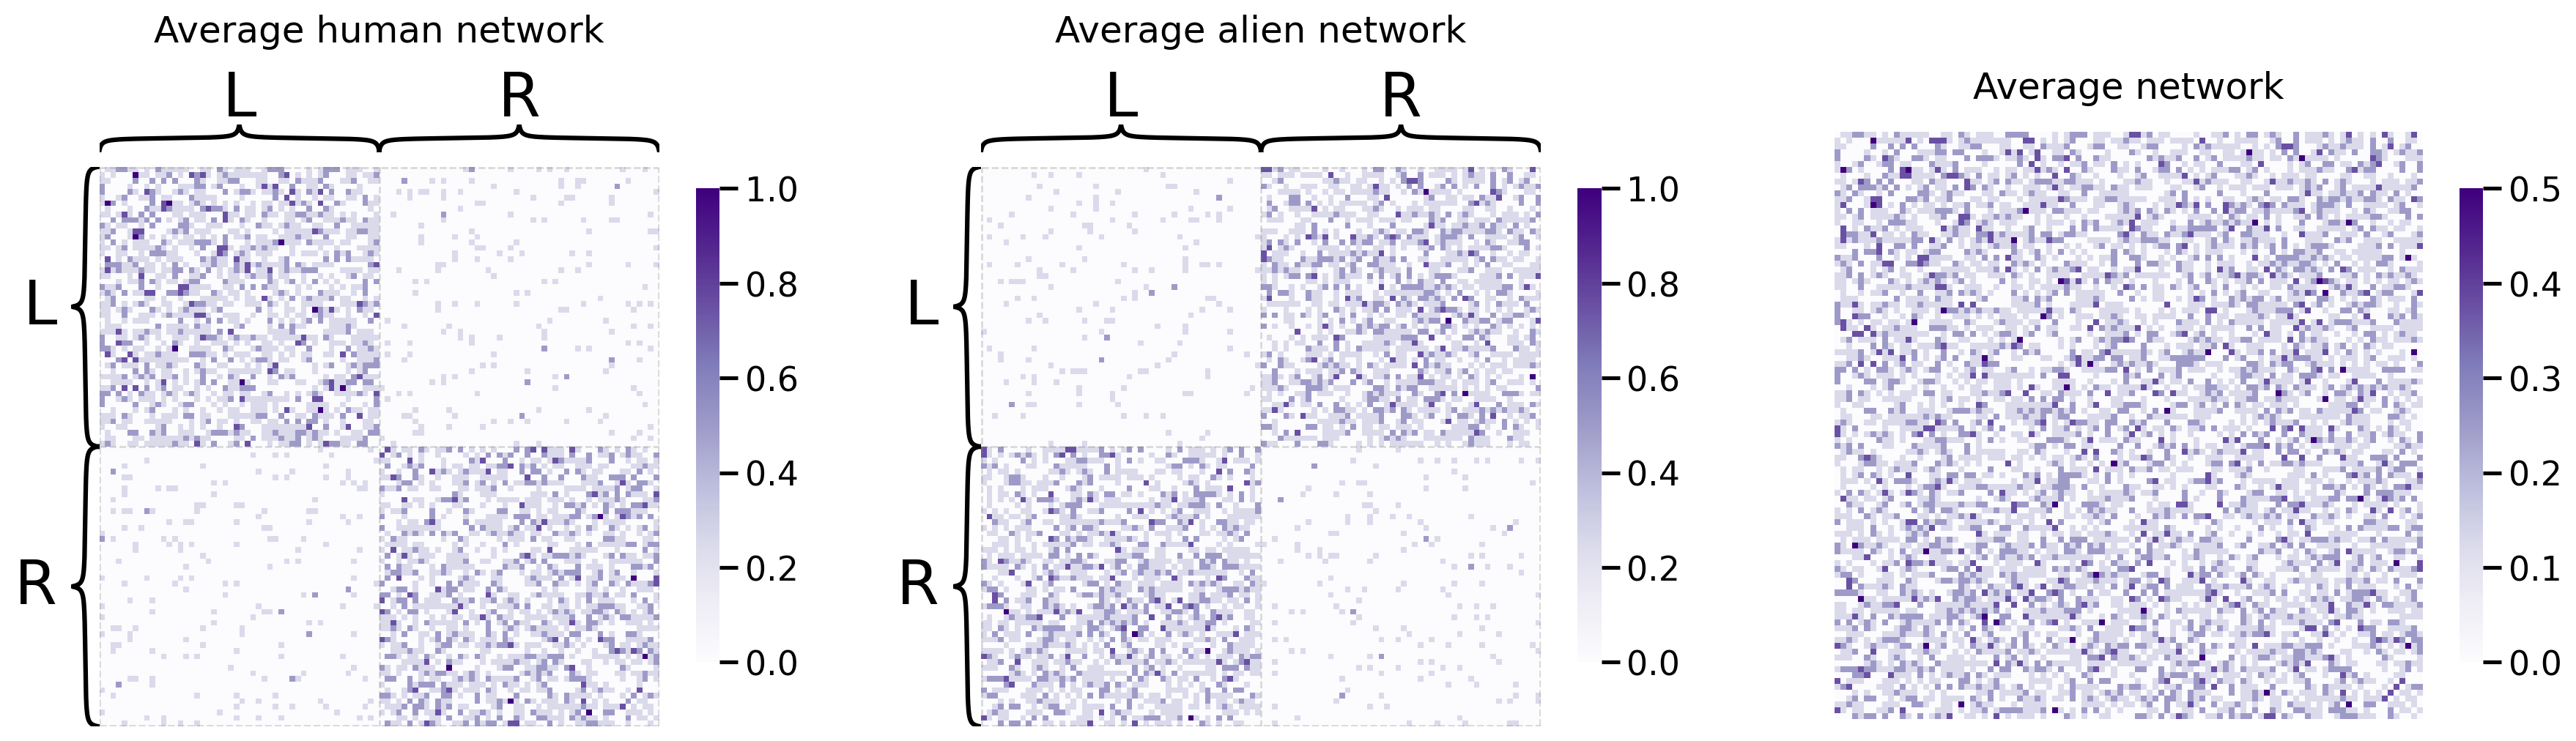

In [13]:
fig, axs = plt.subplots(1,3, figsize=(22, 6))

heatmap(human_mean_network, inner_hier_labels=human_labs, title="Average human network", ax=axs[0])
heatmap(alien_mean_network, inner_hier_labels=alien_labs, title="Average alien network", ax=axs[1])
heatmap(total_mean_matrix, title="Average network", ax=axs[2]);

As we can see, the average human and average alien networks both have clearly discernable structures: the human networks are well-modulated into left and right nodes, and the alien networks are well-modulated into L1, L2, R1, and R2 nodes. However, the average network is somewhere in between the two; it still has left/right discernability, but it's kind of "smoothed away" the separation into L1/L2 and R1/R2 respectively. This might cause some issues in our embedding:

In [14]:
all_latents = ASE().fit_transform(total_mean_matrix)

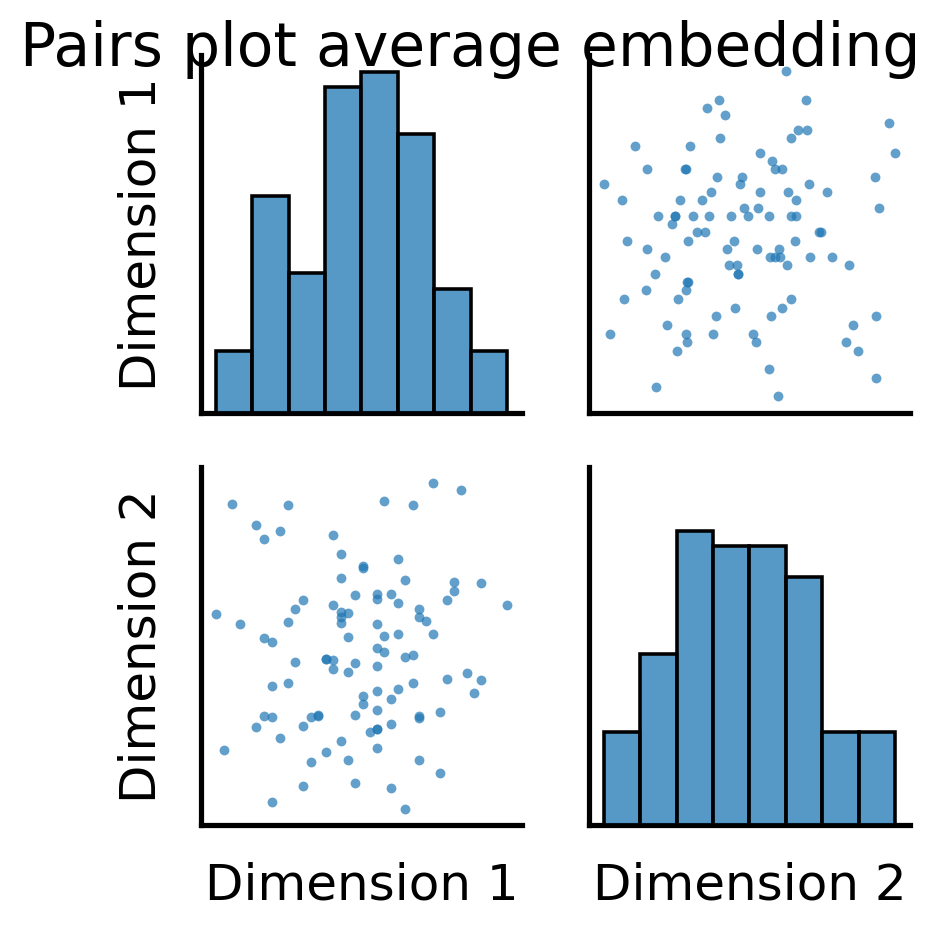

In [15]:
fig = pairplot(all_latents, title="Pairs plot average embedding");

So, it looks like when we took the full average, we still have some discernable structures here. Let's see what these correspond to, using the node communities for the human brains first:

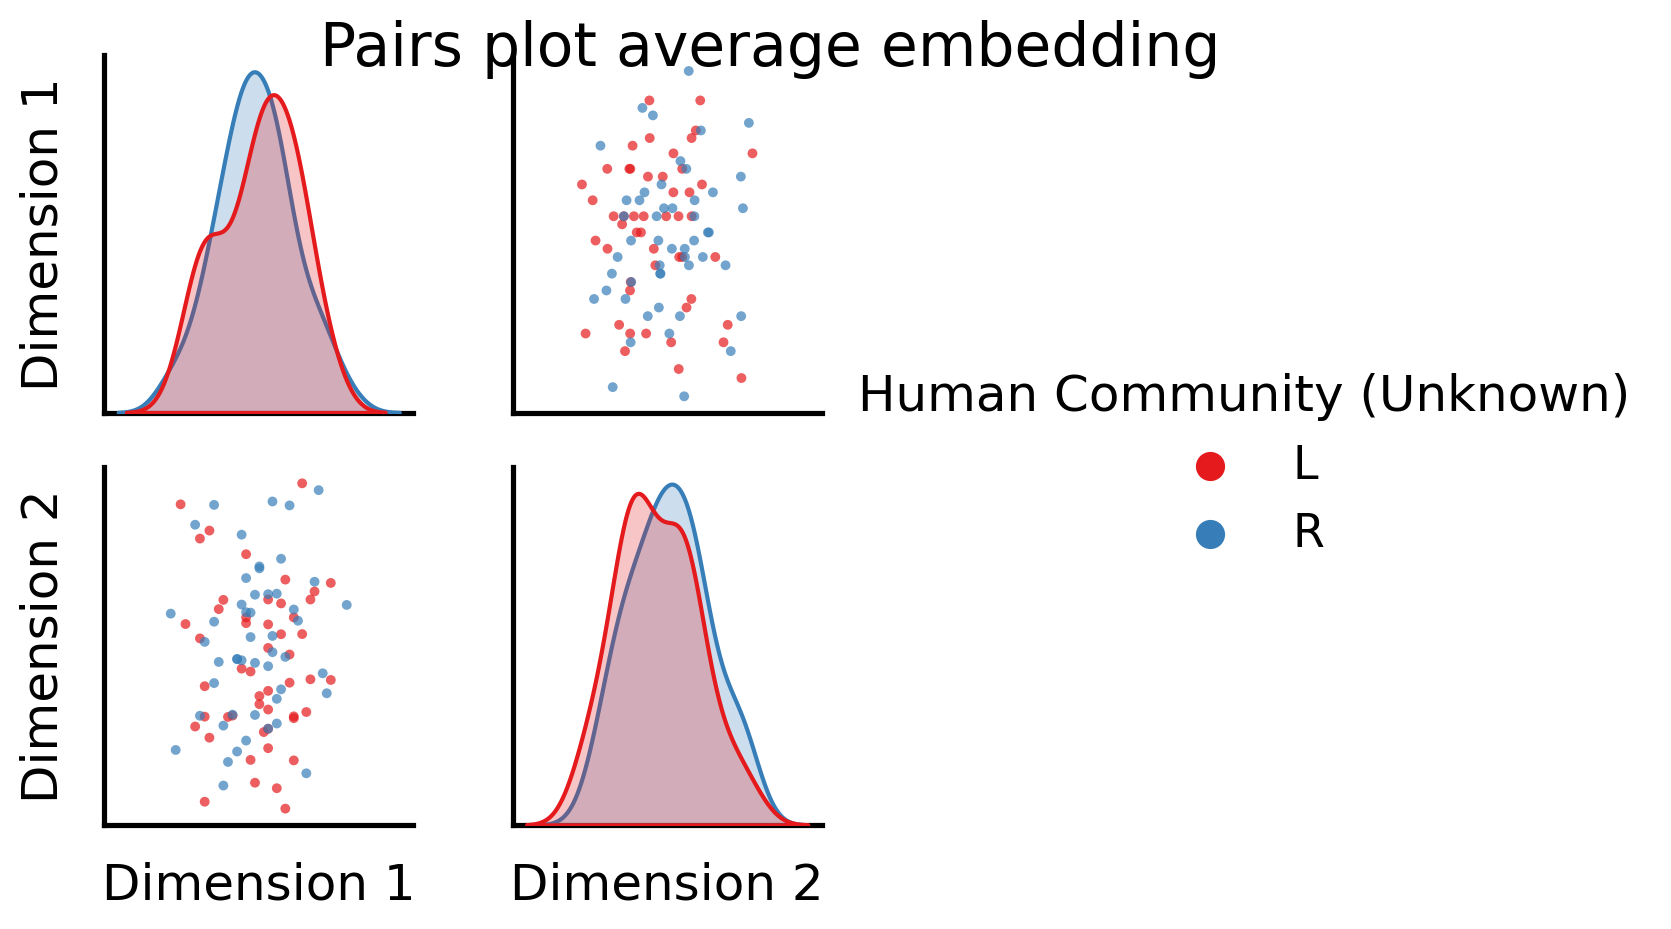

In [16]:
fig = pairplot(all_latents, title="Pairs plot average embedding",
               labels=["L" for i in range(int(n/2))] + ["R" for i in range(int(n/2))],
               legend_name="Human Community (Unknown)");

We have no representation for the original networks themselves, which means we can no longer analyze the individual brain networks with information being shared across all of the networks, and we've destroyed the topological properties of the individual networks.

### Why Does averaging fail?

There are a variety of reasons why averaging, even when we conditionally average human and alien brain networks separately, are unideal. When you average the network unconditionally, you can destroy latent structure, like we learned right above. Even when you average the networks conditionally, if all human brain networks and all alien brain networks come from the same distribution, you still encounter problems. The networks end up, potentially disasterously, not being properly oriented in comparable latent spaces, due to the non-identifiability problem. This means that while you could learn (with conditional averaging) about the humans and alien brain networks separately, you could not learn about them together. Your analysis would be restricted to each group of networks individually.

Finally, and potentially most catastrophically, is the big assumption that we made to average the networks conditionally: that all human brain networks, or separately all alien brain networks, come from the same distribution. This assumption, when viewed through a statistical lens, makes little sense: individual to individual, or more generally network to network, it seems rather unreasonable to believe that numerous samples would come from exactly same distribution. In fact, in many cases where it would be desirable to analyze multiple networks, this is the *opposite* of the reason you might analyze multiple networks in the first place: while you think that there might be *shared* structure between them, more often than not, it's going to make more sense to still believe that each network comes from a different distribution all together. This holds true with the example we gave back in multiple network modelling in {numref}`ch5:multi` (where we discussed social networks from Facebook, Twitter, and Linkedin), it holds true in many cases where you look at brain networks like here, and it's going to make sense in many other domains.

In any case where you have reason to believe that each network comes from a unique distribution, you're going to want a way to reflect that in your algorithm. Let's see how we might approach the problem with these limitations of averaging in mind. 

## Different Types of Multiple-Network Representation Learning

Let's take a moment to explore some of the possible general approaches you could take in multiple-network representation learning. At some point you need to combine the many individual representations of your networks into one, and there are at least three possible places where you could do this: combining the networks together, combining the networks separately, and combining the embeddings. Each of these eventually results in a latent position representation for your networks. It's important to note that in all of these approaches, you're simply learning representations for your groups of networks. You can do whatever you want with these representations; in our case, we'll illustrate blobs of nodes that are created when we embed the networks, which could then be tied together with other algorithms like community detection in {numref}`ch7:comm_detect` downstream for learning from your networks. 

All types of multiple-network representation learning strategies that we describe in this section entail first constructing a *joint matrix*. A **joint matrix** is a matrix which is derived from multiple networks, and summarizes them in such a way that it facilitates downstream analysis. The specific way that the joint matrix is determined from the data depends on the specific multiple-netework representation learning technique.

### Combining the Networks Together

With this approach, you'll start with a set of networks, and then the joint matrix will represent the adjacency matrix of a new network (that summarizes information about all of the other networks that went into it). You can then embed and classify this joint matrix directly. What you did before, averaging the human and alien networks, was an example of combining your networks -- you just averaged all of your adjacency matrices, and then you embedded the result. This tends to be effective when you want to study a property which is common across all of the networks, and you believe network-to-network differences that do not relate to the property of interest to be effectively noise. Unfortunately, it suffers from many of the issues we just mentioned.

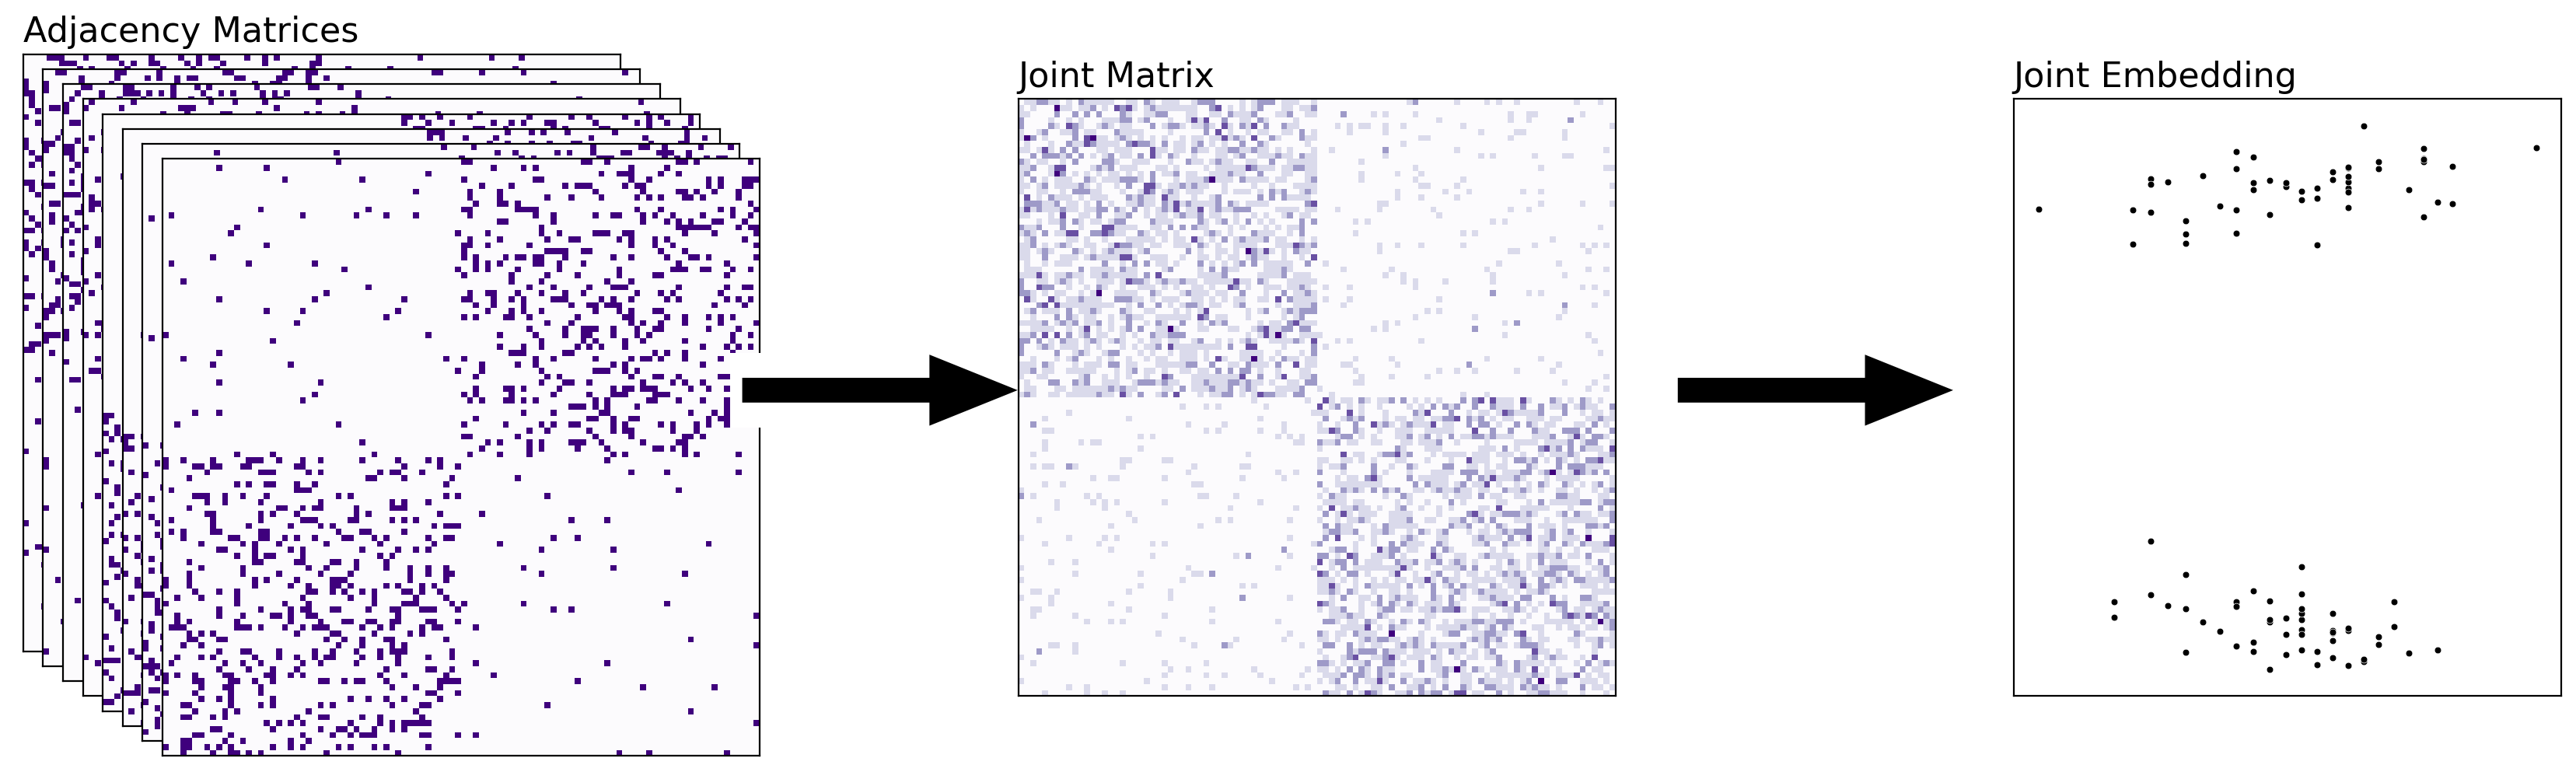

In [17]:
from graspologic.embed import MultipleASE as MASE
from graspologic.embed import OmnibusEmbed as OMNI
from graspologic.embed.omni import _get_omni_matrix
from graphbook_code import binary_heatmap, plot_latents
import seaborn as sns

def rm_ticks(ax, x=False, y=False, **kwargs):
    if x is not None:
        ax.axes.xaxis.set_visible(x)
    if y is not None:
        ax.axes.yaxis.set_visible(y)
    sns.despine(ax=ax, **kwargs)
    
fig = plt.figure();

# add stack of heatmaps
for i in range(8):
    ax = fig.add_axes([.02*i, -.02*i, .8, .8]);
    ax = heatmap(networks[i], ax=ax, cbar=False);
    if i == 0:
        ax.set_title("Adjacency Matrices", loc="left", fontsize=16)
    rm_ticks(ax, top=False, right=False)
    ax.vlines(n, 0, n*2, colors="black", lw=.9, linestyle="dashed", alpha=.8);
    ax.hlines(n, 0, n*2, colors="black", lw=.9, linestyle="dashed", alpha=.8);


# add arrow
arrow_ax = fig.add_axes([.81, .3, .3, .1])
rm_ticks(arrow_ax, left=True, bottom=True)
plt.arrow(x=0, y=0, dx=1, dy=0, width=.1, color="black")

# add joint matrix
omni_ax = fig.add_axes([1, -.02*3, .8, .8])
A = human_mean_network.copy()
a_hm = heatmap(A, ax=omni_ax, cbar=False)
a_hm.set_title("Joint Matrix", loc="left", fontsize=16)
for _, spine in a_hm.spines.items():
    spine.set_visible(True)
    
# add second arrow
arrow_ax = fig.add_axes([1.75, .3, .3, .1])
rm_ticks(arrow_ax, left=True, bottom=True)
plt.arrow(x=0, y=0, dx=1, dy=0, width=.1, color="black") 

# add averaged embedding
omni_embed_ax = fig.add_axes([2.1, -.02*3, .55, .8])
plot_latents(human_latents, ax=omni_embed_ax, title="Joint Embedding", 
             fontdict={'fontsize': 16})
rm_ticks(omni_embed_ax, top=False, right=False)

### Combining the embeddings

The next approach to multiple-network representation learning that you'll learn about is combining the embeddings themselves into the joint matrix. With this approach, you're waiting until you've already embedded all of your networks separately before you combine them, either with adjacency spectral embedding or with some other single-network embedding method. Multiple adjacency spectral embedding (MASE), which you'll be learning about soon, is an example of this approach.

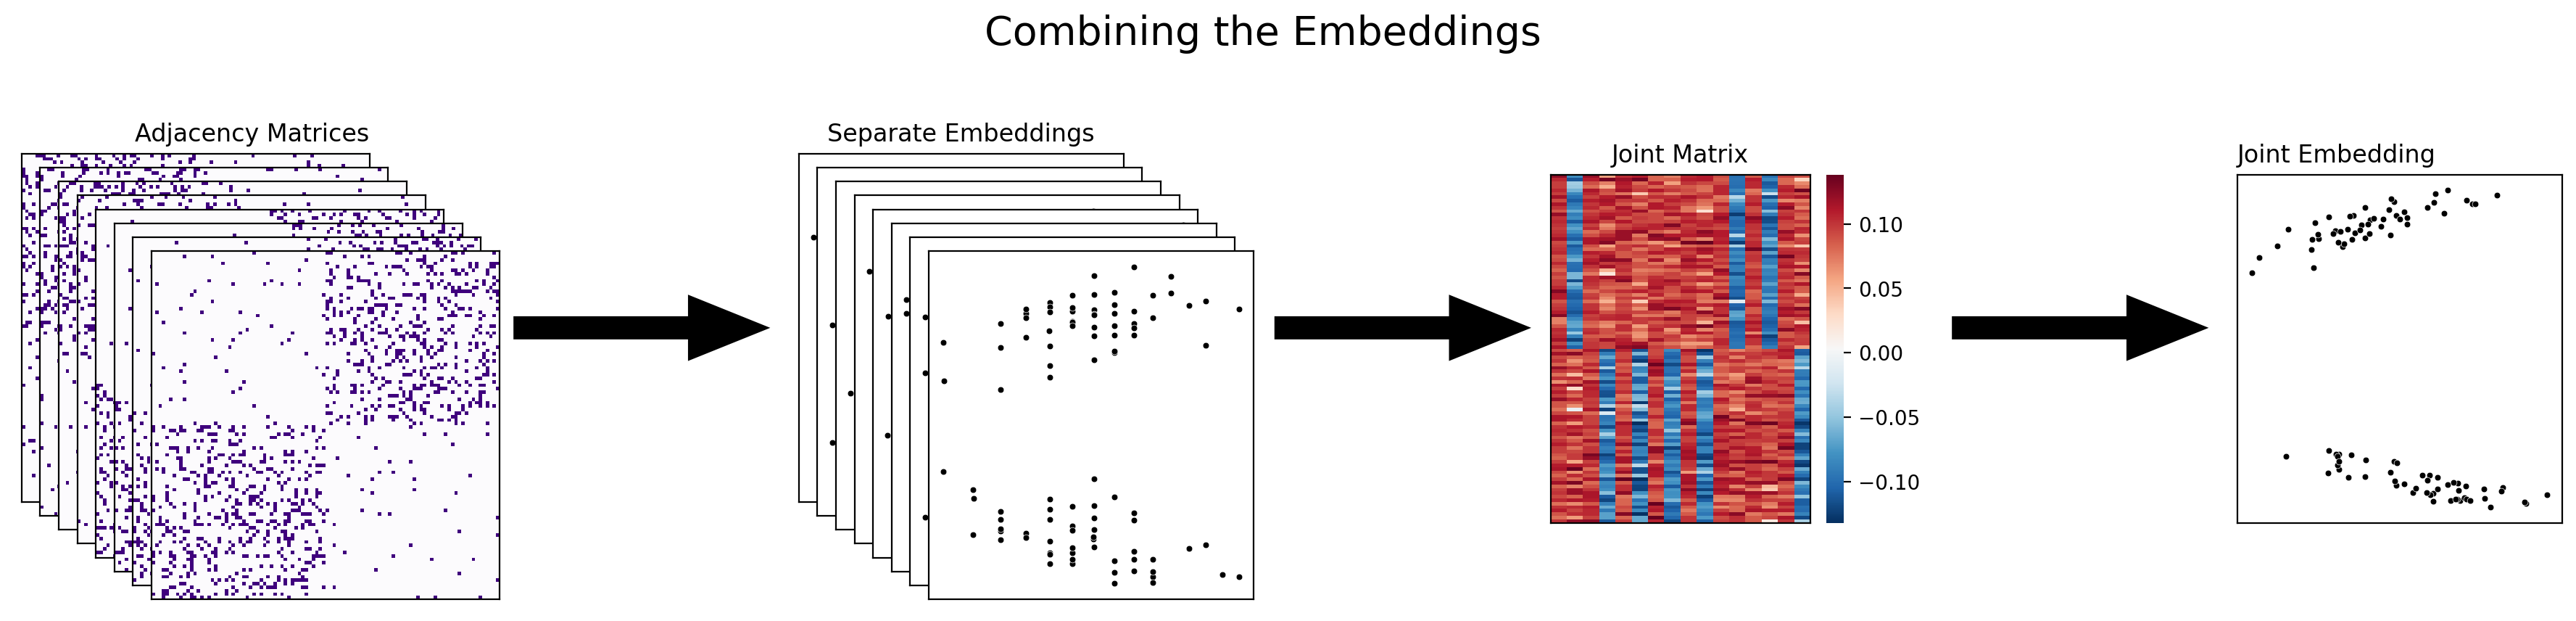

In [18]:
from graphbook_code import GraphColormap
fig = plt.figure()

# add stack of heatmaps
for i in range(8):
    ax = fig.add_axes([.02*i, -.02*i, .5, .5]) 
    ax = heatmap(networks[i], ax=ax, cbar=False)
    if i == 0:
        ax.set_title("Adjacency Matrices", loc="right")
    rm_ticks(ax, top=False, right=False)
    ax.vlines(n, 0, n*2, colors="black", lw=.9, linestyle="dashed", alpha=.8)
    ax.hlines(n, 0, n*2, colors="black", lw=.9, linestyle="dashed", alpha=.8)

# add arrow
arrow_ax = fig.add_axes([.58, .2, .3, .1])
rm_ticks(arrow_ax, left=True, bottom=True)
plt.arrow(x=0, y=0, dx=1, dy=0, width=.1, color="black") 

joint_latents = []
# add stack of latent plots
for i in range(8):
    ax = fig.add_axes([.9+.02*i, -.02*i, .35, .5])
    if i == 0:
        ax.set_title("Separate Embeddings")
    latents = ASE(n_components=2).fit_transform(networks[i])
    joint_latents.append(latents)
    plot = sns.scatterplot(latents[:, 0], latents[:, 1], 
                       s=10, ax=ax, color="black")
    rm_ticks(ax, top=False, right=False)
    
# add second arrow
arrow_ax = fig.add_axes([1.4, .2, .3, .1])
rm_ticks(arrow_ax, left=True, bottom=True)
plt.arrow(x=0, y=0, dx=1, dy=0, width=.1, color="black") 

# add group embeddings
mase_ax = fig.add_axes([1.71, -.03, .35, .5])
sns.heatmap(np.hstack(joint_latents), ax=mase_ax, cmap=GraphColormap("divergent", discrete=False).palette)
mase_ax.set_title("Joint Matrix")
rm_ticks(mase_ax, top=False, right=False)

# add third arrow
arrow_ax = fig.add_axes([2.13, .2, .3, .1])
rm_ticks(arrow_ax, left=True, bottom=True)
plt.arrow(x=0, y=0, dx=1, dy=0, width=.1, color="black") 

mase = MASE(n_components=2)
latents_mase = mase.fit_transform(networks)
mase_ax = fig.add_axes([2.45, -.03, .35, .5])
plot_latents(latents_mase, ax=mase_ax, title="Joint Embedding")
rm_ticks(mase_ax, top=False, right=False)

plt.suptitle("Combining the Embeddings", x=1.4, y=.7, fontsize=20);

### Combining The Networks Separately

The above approach is nice for collapsing your information into a single embedding -- with each point in your final embedding representing a single node of your network. The joint embedding that you obtain tends to summarize information *across* the nodes, as you will learn soon. However, there are situations in which you might want to keep your embeddings separate, but make sure that they're in the same latent space -- meaning, the embeddings aren't rotations of each other. This addresses the problem that we noticed in {numref}`ch6:spectral:nonidentifiable`. When we approach multiple-network representation learning in this manner, you can directly compare the embeddings of the separate networks. An example of combining the networks separately is the Omnibus embedding (OMNI).

In [ ]:
from graspologic.embed import MultipleASE as MASE
from graspologic.embed import OmnibusEmbed as OMNI
from graspologic.embed.omni import _get_omni_matrix

def rm_ticks(ax, x=False, y=False, **kwargs):
    if x is not None:
        ax.axes.xaxis.set_visible(x)
    if y is not None:
        ax.axes.yaxis.set_visible(y)
    sns.despine(ax=ax, **kwargs)
    
fig = plt.figure();

# add stack of heatmaps
for i in range(8):
    ax = fig.add_axes([.02*i, -.02*i, .8, .8]) 
    ax = heatmap(networks[i], ax=ax, cbar=False)
    if i == 0:
        ax.set_title("Adjacency Matrices", loc="left", fontsize=16)
    rm_ticks(ax, top=False, right=False)
    ax.vlines(n, 0, n*2, colors="black", lw=.9, linestyle="dashed", alpha=.8)
    ax.hlines(n, 0, n*2, colors="black", lw=.9, linestyle="dashed", alpha=.8)

# add arrow
arrow_ax = fig.add_axes([.82, .3, .3, .1])
rm_ticks(arrow_ax, left=True, bottom=True)
plt.arrow(x=0, y=0, dx=1, dy=0, width=.1, color="black") 

# add joint matrix
omni_ax = fig.add_axes([1, -.02*3, .8, .8])
A = _get_omni_matrix(networks)
a_hm = heatmap(A, ax=omni_ax, cbar=False)
a_hm.set_title("Joint Matrix", loc="left", fontsize=16)
for _, spine in a_hm.spines.items():
    spine.set_visible(True)
    
# add second arrow
arrow_ax = fig.add_axes([1.75, .3, .3, .1])
rm_ticks(arrow_ax, left=True, bottom=True)
plt.arrow(x=0, y=0, dx=1, dy=0, width=.1, color="black") 

# add omni embedding
latents_omni = OMNI(n_components=2).fit_transform(networks)
for i, embedding in enumerate(latents_omni):
    ax = fig.add_axes([2.1+.02*i, -.02*i, .55, .8])
    if i == 0:
        ax.set_title("Separate Embeddings", loc="left", fontsize=16)
    plot = sns.scatterplot(embedding[:, 0], embedding[:, 1], 
                       s=10, ax=ax, color="black")
    rm_ticks(ax, top=False, right=False)

For the rest of this section, we'll explore the strengths and weaknesses of different techniques which use these last two approaches. 

The first we'll look at combines the embeddings. It's called Multiple Adjacency Spectral Embedding, or MASE for short.

(ch6:multinet:mase)=
## Multiple Adjacency Spectral Embedding (MASE)

MASE is a technique which combines embeddings by concatennating and re-embedding the separate latent positions into a single space. It's nice because you don't actually need each network to be generated from the same distribution - you only need the nodes of the different networks to be aligned and have similar "meaning" across the networks. What this means is that node $1$ in network $1$ has the same literal interpretation as node $1$ in networks $2$ through $M$, and so on for all $n$ nodes of the network. In your brain network, for instance, node one is the first region, node two is the second region, ... and this property applies to all of the nodes in the network.

MASE is probably the easiest to understand if you know how adjacency spectral embeddings work. Say you have some number of networks, and (like we said above) their nodes are aligned. The goal of MASE is to embed the networks into a single space, with each point in that space representing a single node - but, unlike simply averaging, MASE lets you combine networks which aren't necessarily drawn from the same distribution. 

MASE is based on the common subspace independent-edge (COSIE) model that you learned about in {numref}`ch5:multi:cosie`. If you recall, with the COSIE model, you learned that across your networks, there might be some underlying *homogeneity*: in your brain networks, for instance, there might be communities that are shared across *all* of the networks. Simultaneously, these networks are distinct for one reason or another in terms of the underlying probability matrix: for instance, a pair of humans might have different probabilities for particular edges being connected or disconnected, or a pair of individuals one of whom is human and the other is alien might have different patterns to their probability matrices all together. In this sense, the COSIE model allowed you to capture both the *homogeneity* and *heterogeneity* across different networks simultaneously.

Let's go back to your group of human and alien brains and try using MASE to embed them rather than averaging. Then, we'll dive deeper into what's going on under the hood. First, you'll instantiate a MASE instance and embed the networks. Then you'll create a combined list of the human and alien brains, and use MASE to find the latent positions.

In [21]:
from graspologic.embed import MultipleASE as MASE

# Use MASE to embed everything
mase = MASE()
# fit_transform on the human and alien networks simultaneously
# + combines the two lists
latents_mase = mase.fit_transform(networks)

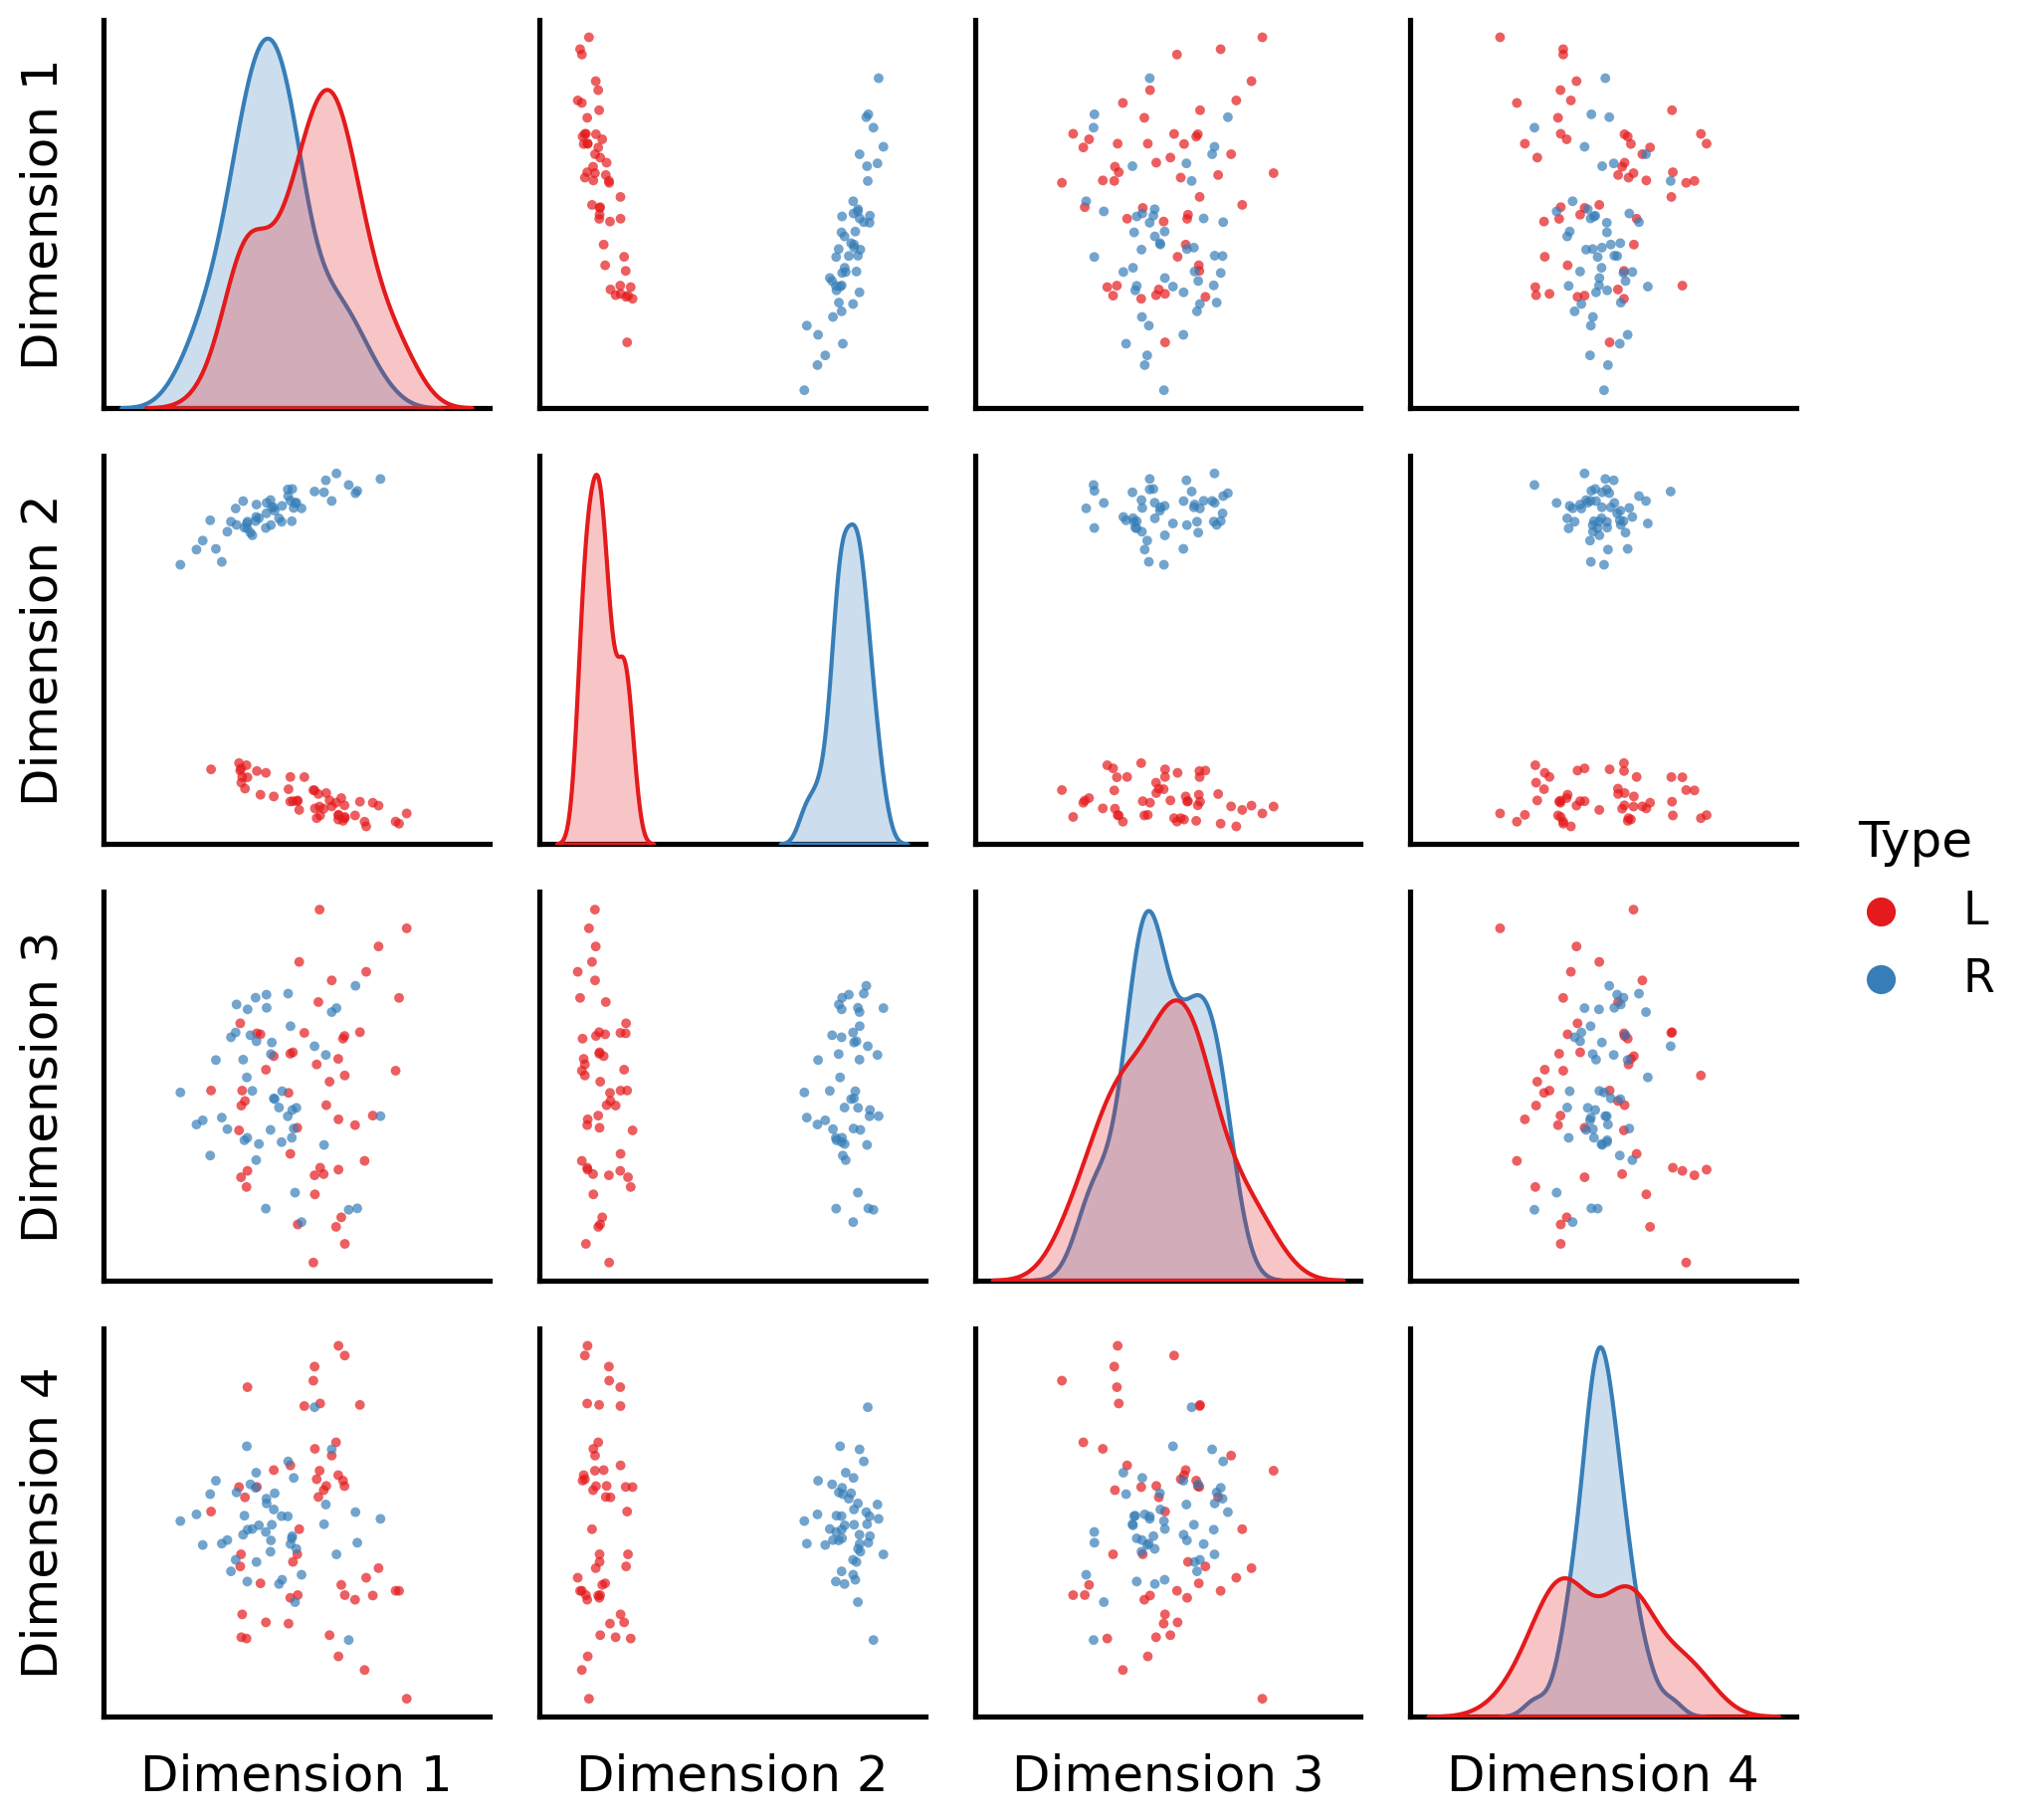

In [22]:
_ = pairplot(latents_mase,
            labels=alien_labs)

Unlike the disastrous results from simply averaging all of your networks together, MASE manages to identify all of the different communities. As you can see, the second dimension tends to separate the Left from the Right (shared by humans and aliens), but as we will learn, it will still allow you to still recover the unique aspects of human and alien brains. 

### How Does MASE Work?

Below, you can see how MASE works. You start with networks, drawn as nodes in space connected to each other. You turn them into adjacency matrices, and then you embed the adjacency matrices of a bunch of networks separately, using your standard Adjacency spectral embedding. Then, you take all of those embeddings, concatenate horizontally into a single matrix, and embed the entire concatenated matrix. The colors are the true communities each node belongs to: there's a red and an orange community. MASE is an unsupervised learning technique and so it doesn't need any information about the true communities to embed, but they're useful to see. We'll illustrate what's happening in the MASE algorithm by running through all of its steps ourselves, with the human and alien networks from above.

```{figure} ../../Images/mase1.jpeg
---
height: 400px
name: mase-fig
---
The MASE algorithm.
```

#### Embedding your networks

The first step in the MASE algorithm is to spectrally embed each network. This step is pretty straightforward, so we won't dive into it too much: remember, you're combining the embeddings, not the networks, so you're not doing anything fancy. The python code below just creates adjacency spectral embeddings from each individual network, and from the resulting spectral embeddings, constructs a new matrix, called a joint matrix, which we will explore more in a second. 

When you know ahead of time how many dimensions that you want, you would perform your ASE with the desired number of dimensions here. Since we're just going to leave things generic, on the ASE step, you will tend to embed into `d = ceiling(log2(n))` dimensions, which is in general a good starting point. When $n$ is $100$, this comes to about $5$:

In [23]:
from graspologic.embed import AdjacencySpectralEmbed as ASE

dhat = int(np.ceil(np.log2(n)))
# spectrally embed each network into ceil(log2(n)) dimensions with ASE
joint_matrix = [ASE(n_components=dhat).fit_transform(network) for network in networks]

Let's visualize two of these embeddings. We'll take a look first at an embedding from a human, using a pairs plot like we did in [spectral embedding](ch5:spectral:pairs). We'll look at the first four embedding dimensions:

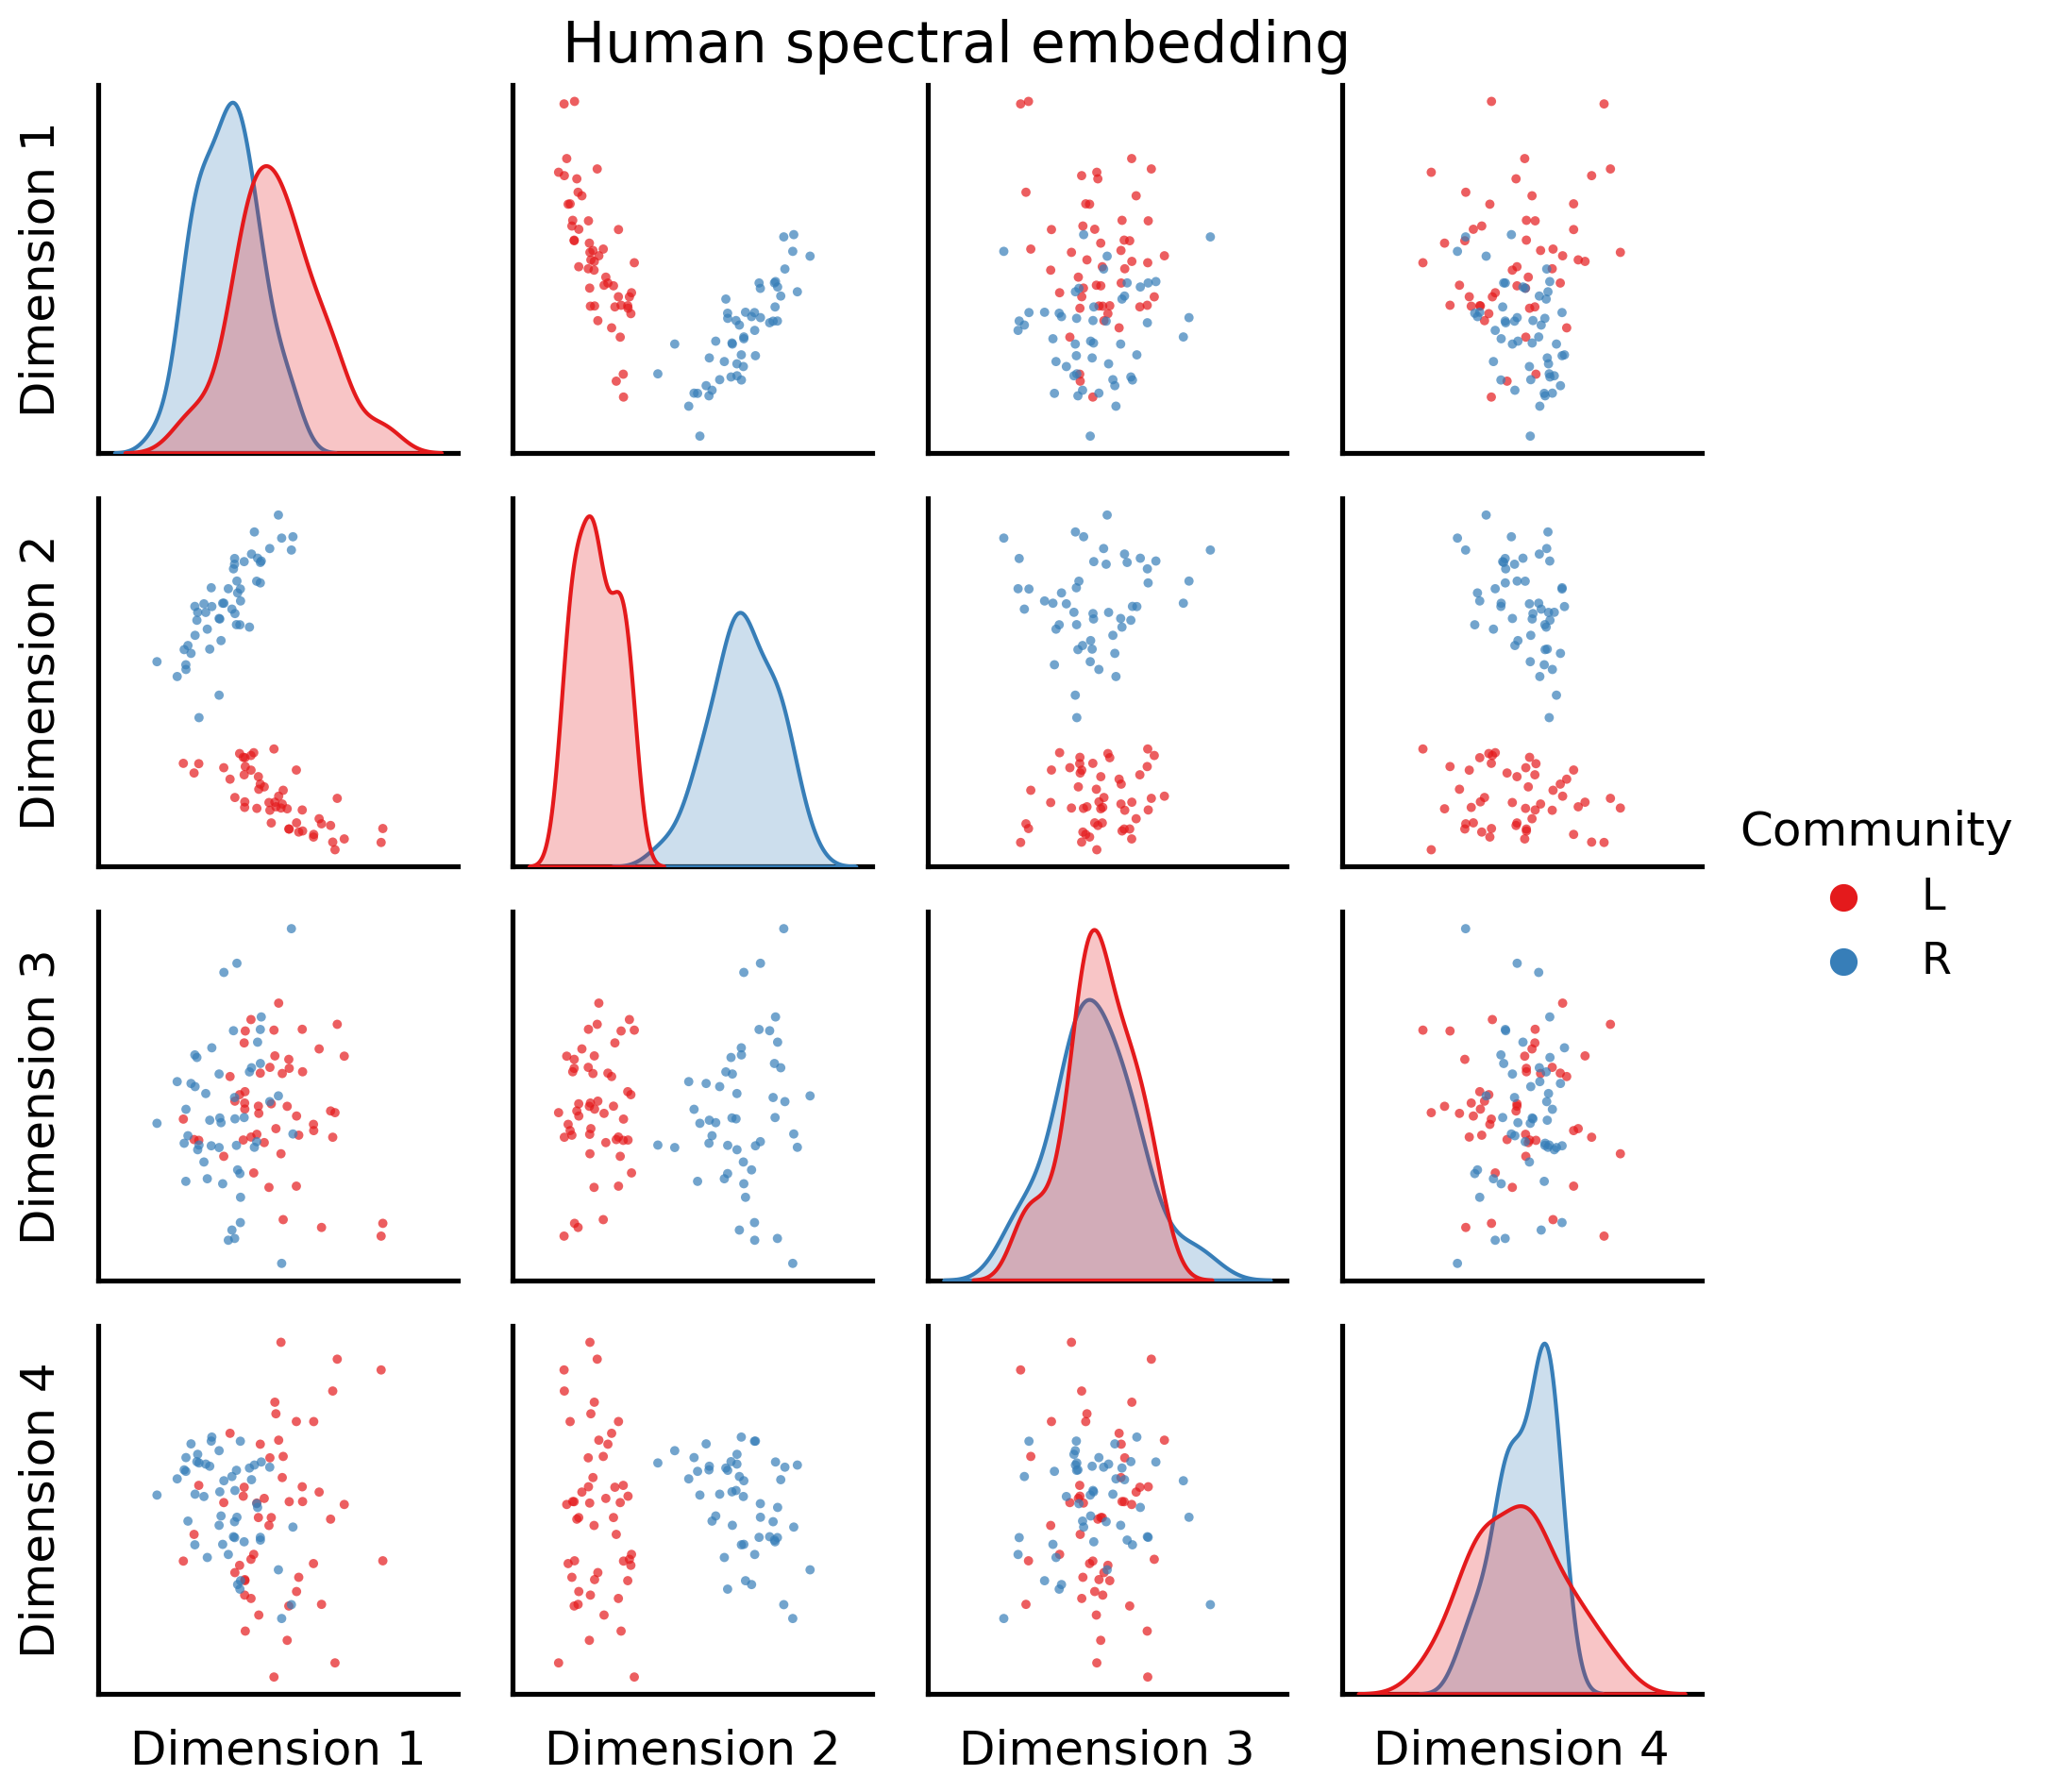

In [26]:
_ = pairplot(joint_matrix[0][:, 0:4], labels=human_labs, legend_name="Community",
             title="Human spectral embedding")

And next, at an embedding from an alien, again looking at the first four dimensions:

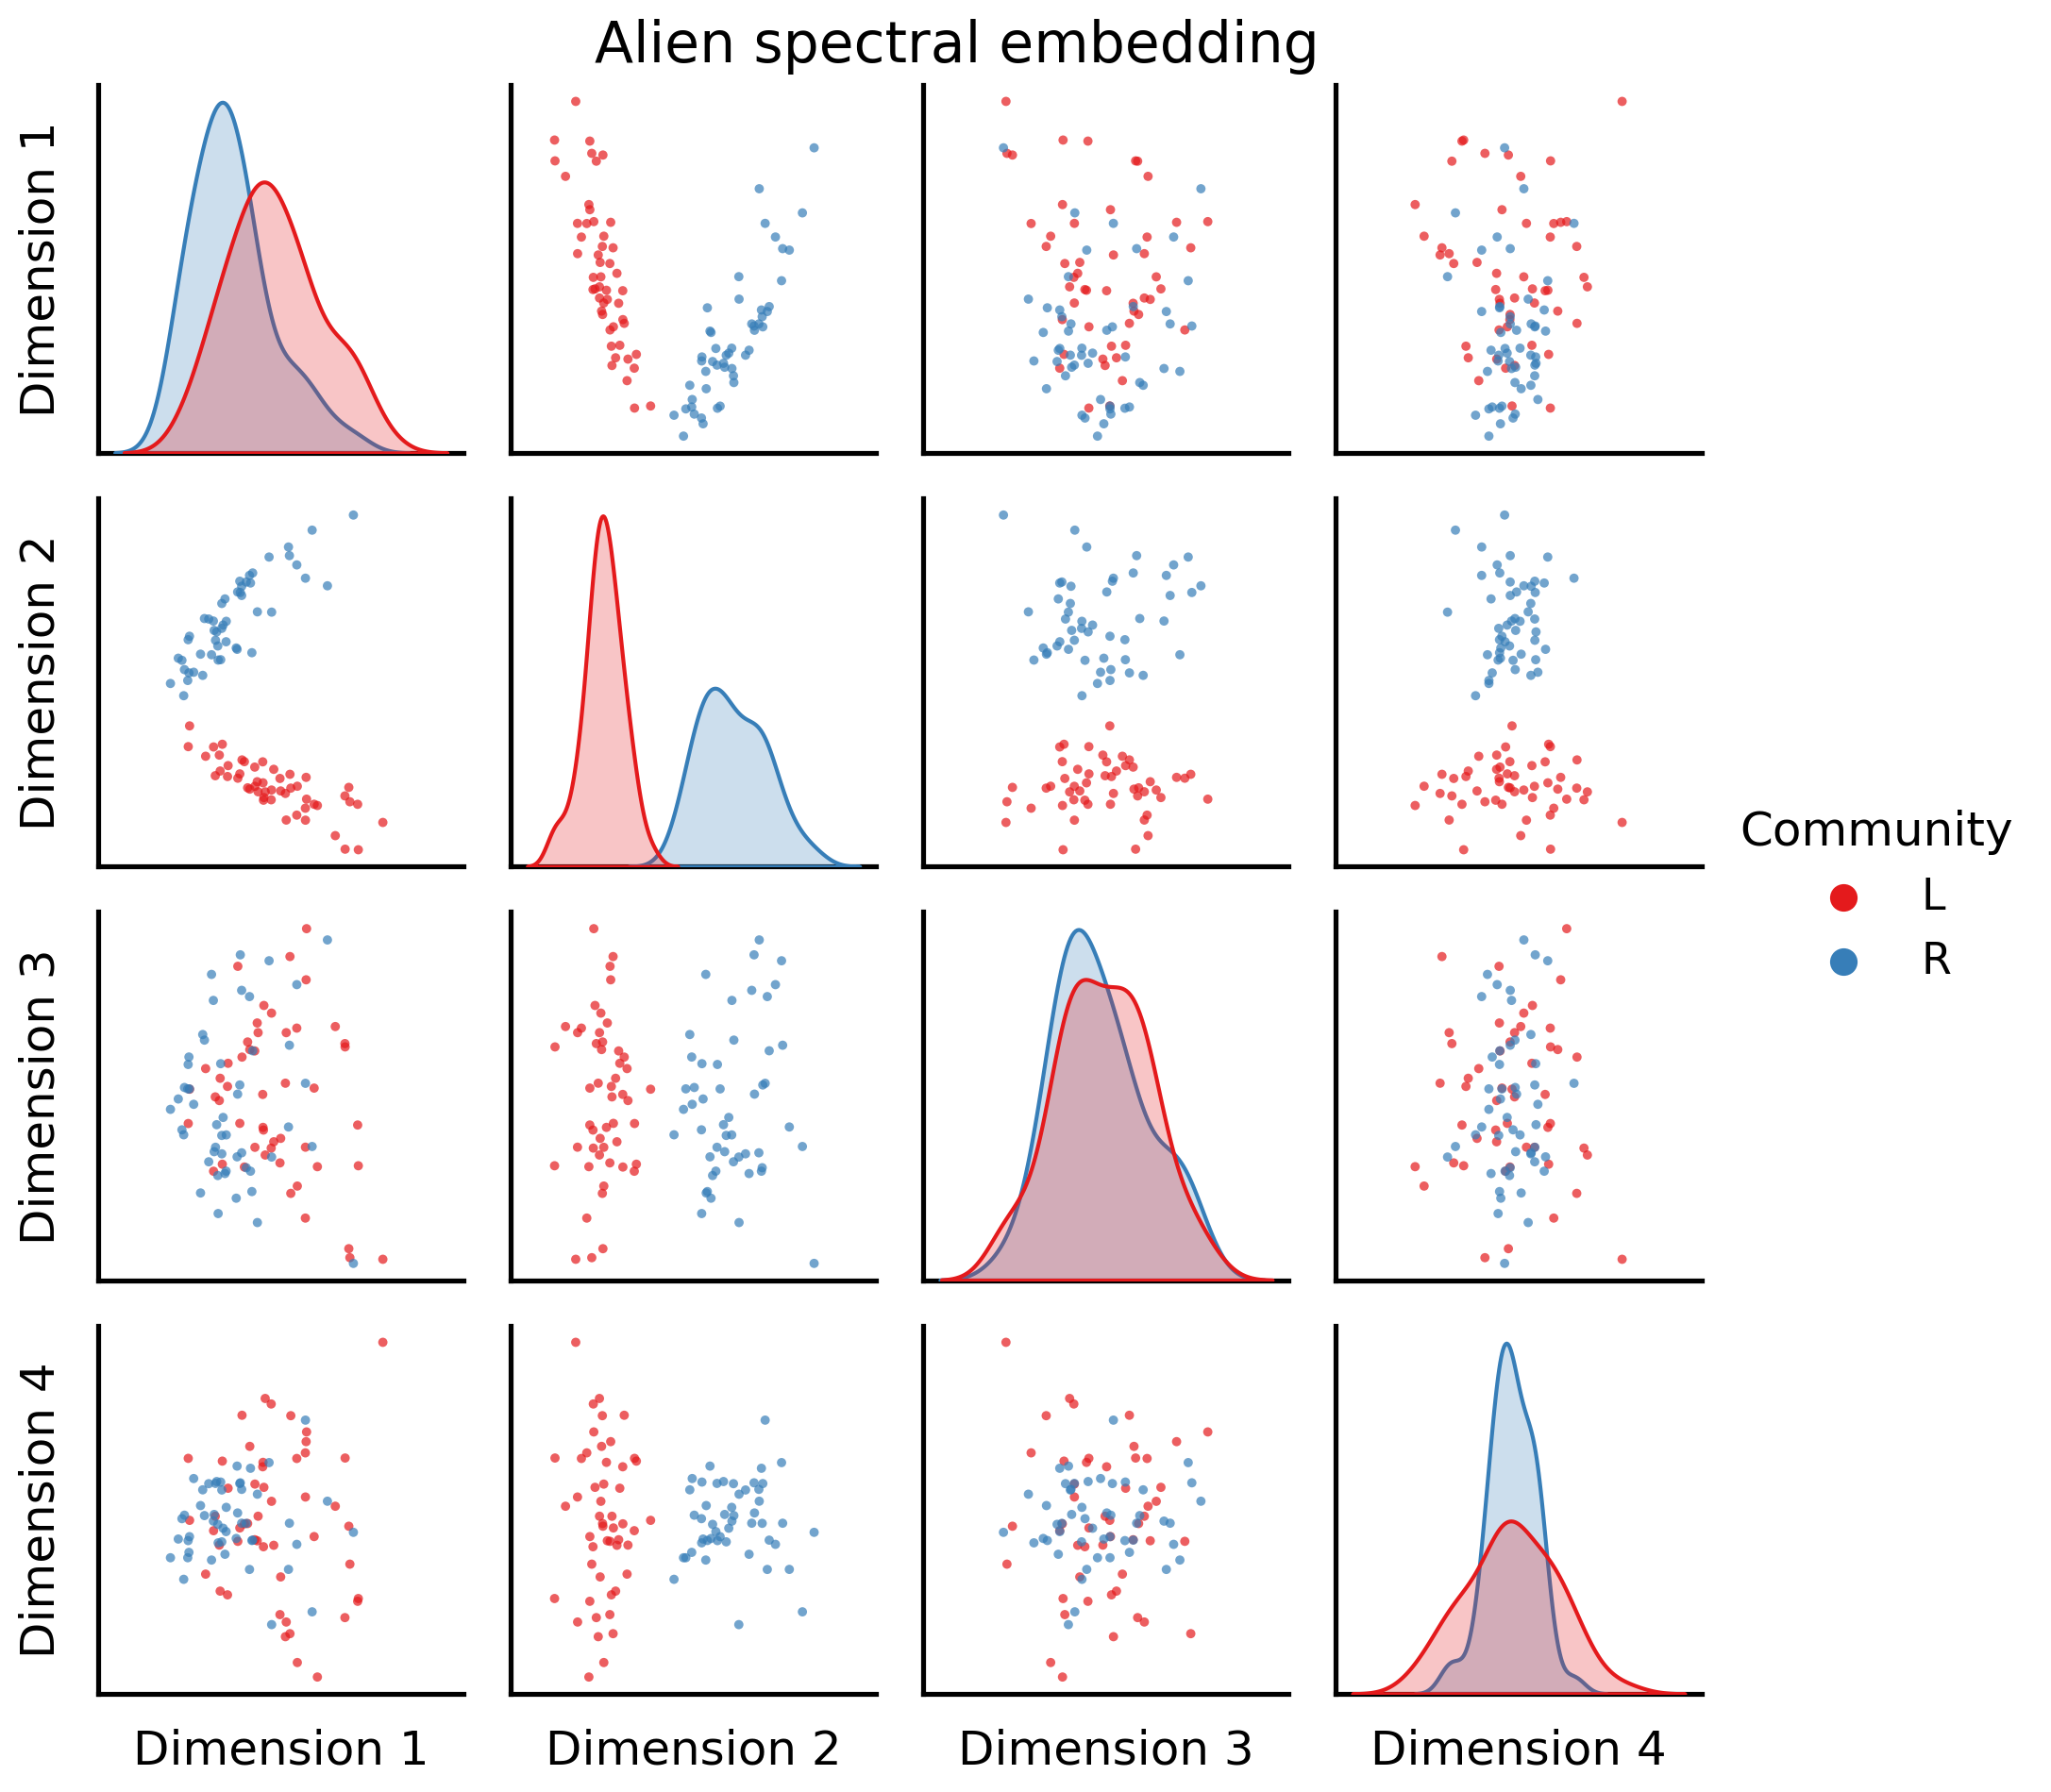

In [27]:
_ = pairplot(joint_matrix[2][:, 0:4], labels=alien_labs, legend_name="Community",
             title="Alien spectral embedding")

It's important to keep in mind that these embeddings don't live in the same *latent space* (yet!). 

#### Combining your embeddings

Now comes the interesting part. Our goal is to find some way to take each of these individual embeddings and combine them. We want to find a reasonable way of doing this.

You can visualize each of your four embeddings a different way. Instead of the using the two latent position dimensions as the x-axis and the y-axis of your plot, you can just visualize your latent position matrices directly. Each latent position now corresponds to rows in one of these matrices. The columns are the different latent dimensions, and the colors in each row correspond to the latent position value for that latent dimension. You're essentially substituting location for color.

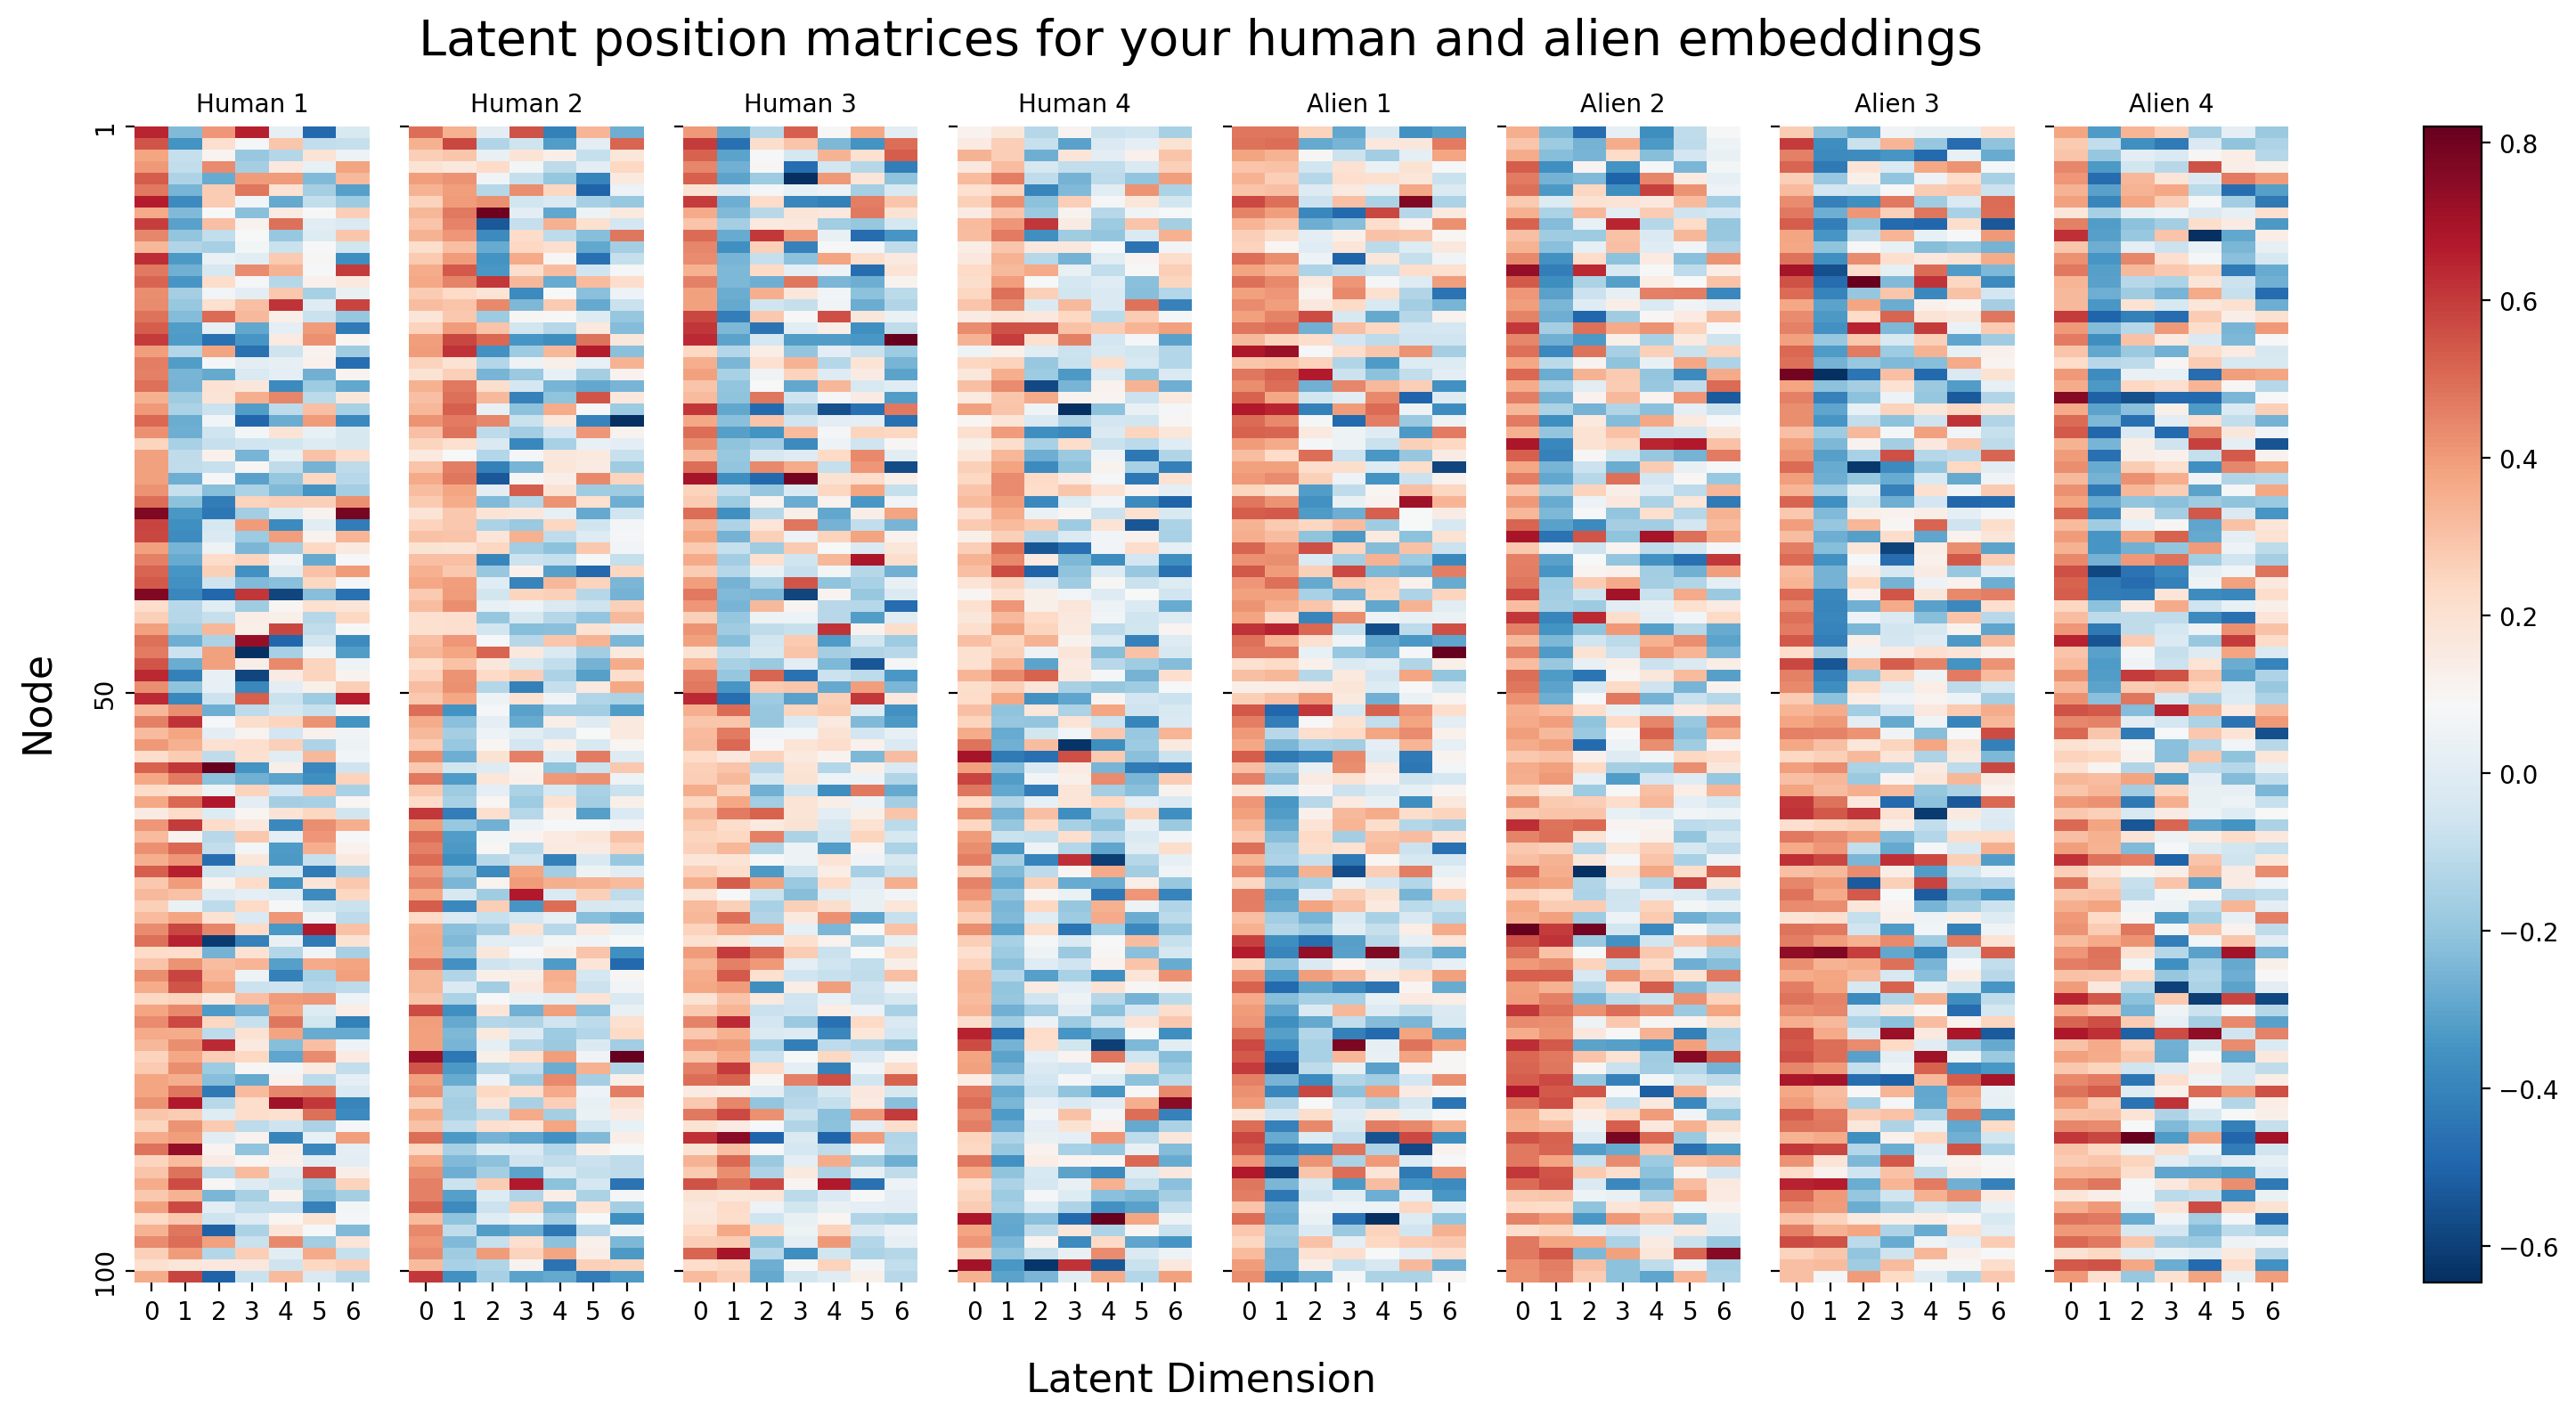

In [28]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize

cmap = GraphColormap("divergent", discrete=False).palette
titles = [f"Human {i + 1}" for i in range(int(M/2))] + [f"Alien {i + 1}" for i in range(int(M/2))]
fig, axs = plt.subplots(ncols=8, figsize=(16, 8), sharex=True, sharey=True)
for i, ax in enumerate(axs.flat):
    hm = sns.heatmap(joint_matrix[i], cmap=cmap, 
                     ax=ax, cbar=False)
    hm.set_yticks([0, 49, 99])
    hm.set_yticklabels(["1", "50", "100"])
    hm.set_title(titles[i], fontdict={'fontsize': 10})
    
fig.supxlabel("Latent Dimension", x=.42, fontsize=16)
fig.supylabel("Node", x=.005, fontsize=16)
fig.suptitle("Latent position matrices for your human and alien embeddings", x=.42, fontsize=20)

fig.tight_layout(w_pad=2)
vmin, vmax = np.array(joint_matrix).min(), np.array(joint_matrix).max()
norm = Normalize(vmin=vmin, vmax=vmax)
im = cm.ScalarMappable(cmap=cmap, norm=norm)
fig.colorbar(im, ax=axs);

Because the rows of these matrices are all aligned - meaning, row 1 corresponds to node 1 for all four matrices - you can actually think of each node as having (in this case) $Md$ latent dimensions: there are $d$ latent dimensions for each of your $M$ networks. In this case, since $\hat d = 7$ and $M = 8$, this means that each node has $7 \times 8 = 56$ latent dimensions associated with it ($7$ per network).

You don't actually need separate matrices to express this idea: the natural thing to do would be to just concatenate all of the matrices horizontally into a single $n \times Md$ matrix, where $n$ is the number of nodes (the *rows* of the resulting matrix), and $Md$ is the number of latent dimensions associated with each node (the *columns* of the resulting matrix). This matrix is called the *joint matrix*, since it is a composition of information from the $M$ total networks.

In [30]:
# Concatenate your four matrices horizontally into a single m by d matrix
concatenated = np.hstack(joint_matrix)

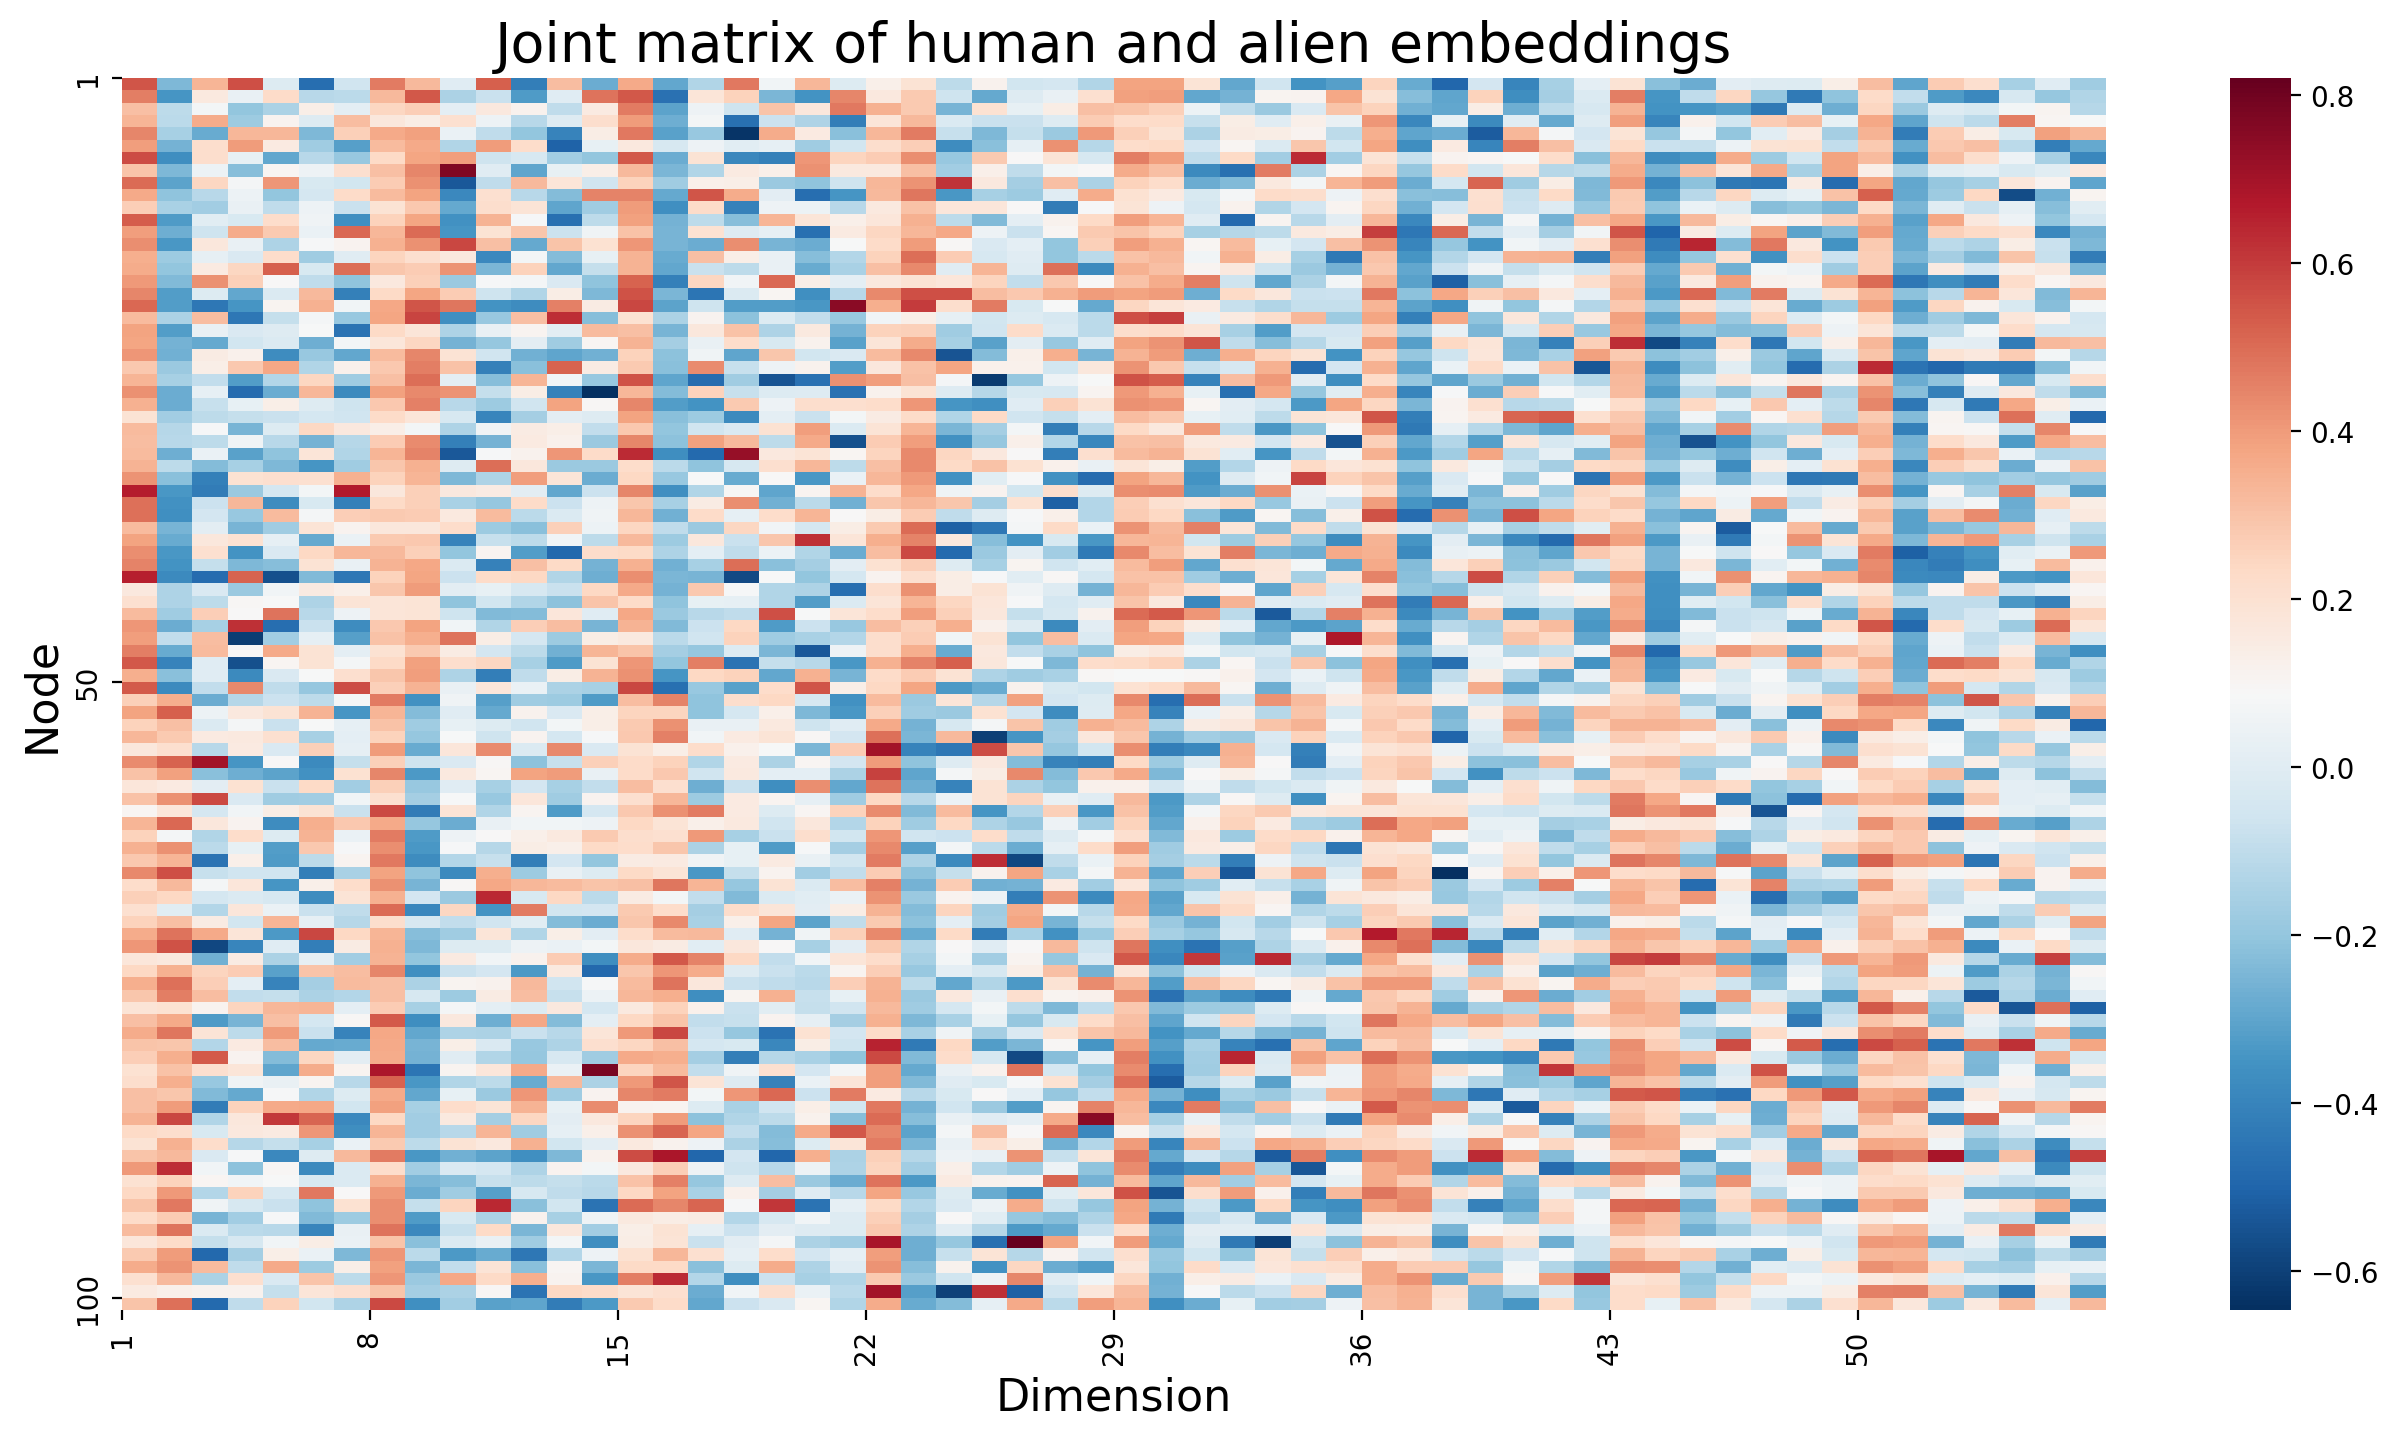

In [31]:
fig, ax = plt.subplots(figsize=(16, 8))
hm = sns.heatmap(concatenated, cmap=cmap, ax=ax, yticklabels=50);
hm.set_title(f"Joint matrix of human and alien embeddings", fontdict={'fontsize': 20});
hm.set_xlabel("Dimension", fontsize=16)
hm.set_xticks([0, 7, 14, 21, 28, 35, 42, 49])
hm.set_xticklabels([1, 8, 15, 22, 29, 36, 43, 50])
hm.set_yticks([0, 49, 99])
hm.set_yticklabels([1, 50, 100])
hm.set_ylabel("Node", fontsize=16);

When we look at the joint matrix oriented in this manner, we can see the property that we are going to exploit in our next step. Notice that there looks to be a lot of *redundant* information in this matrix. In particular, it looks like the first column of every embedding tends to be about near $0.2$. The second column of every embedding looks like it tends to separate the first $50$ nodes (which were the left hemisphere) from the next $50$ nodes (which were the right hemisphere). Successive dimensions tend to look like noise.

This sort of *redundancy* of some of the qualitative features of the columns is, in fact, *exploitable*. This is despite the fact that the columns aren't exactly identical in their behavior (for instance, for some of the networks, the second embedding dimension has high values for the first 50 nodes and low values for the second 50 nodes, or low values for the first 50 nodes and high values for the second 50 nodes). The important idea is that there is some notion of similar information being conveyed that we can use to simplify this problem even further.

#### Embedding your joint matrix To Create a joint embedding

So now you have a joint matrix, but you have a new issue you'd like to address: there's a lot of redundant information which is common to many of these embeddings (such as the second dimension *tending* to separate the left from the right), and some information common only to a subset of these embeddings (such as that some of the networks have the second dimension having high values for the first group of nodes and low values for the second group of nodes, and vice versa for the other networks). The way in which this redundancy is conveyed is *not* consistent from embedding to embedding, which is an instance of the rotational non-identifiability from {numref}`(ch6:spectral:nonidentifiable` problem we brought up previously. What are you left to do?

Well, as it turns out, this problem is *exactly* the situation our `svd` (the same `svd` we used in spectral embedding) is useful for! it allows you to capture the redundancy of the qualitative aspects of these columns, and obtain the *general idea* of what they each convey numerically.

Through this process, what you are effectively doing is now embedding your joint matrix, to obtain a *joint embedding*. Here, the dimensionality is selected using [elbow selection](ch6:spectral:elbow):

In [32]:
from graspologic.embed import select_svd
joint_embedding, *_ = select_svd(concatenated)

Just like before, the best way to visualize the resulting embedding is as a pairs plot. Let's take a look at what we end up with:

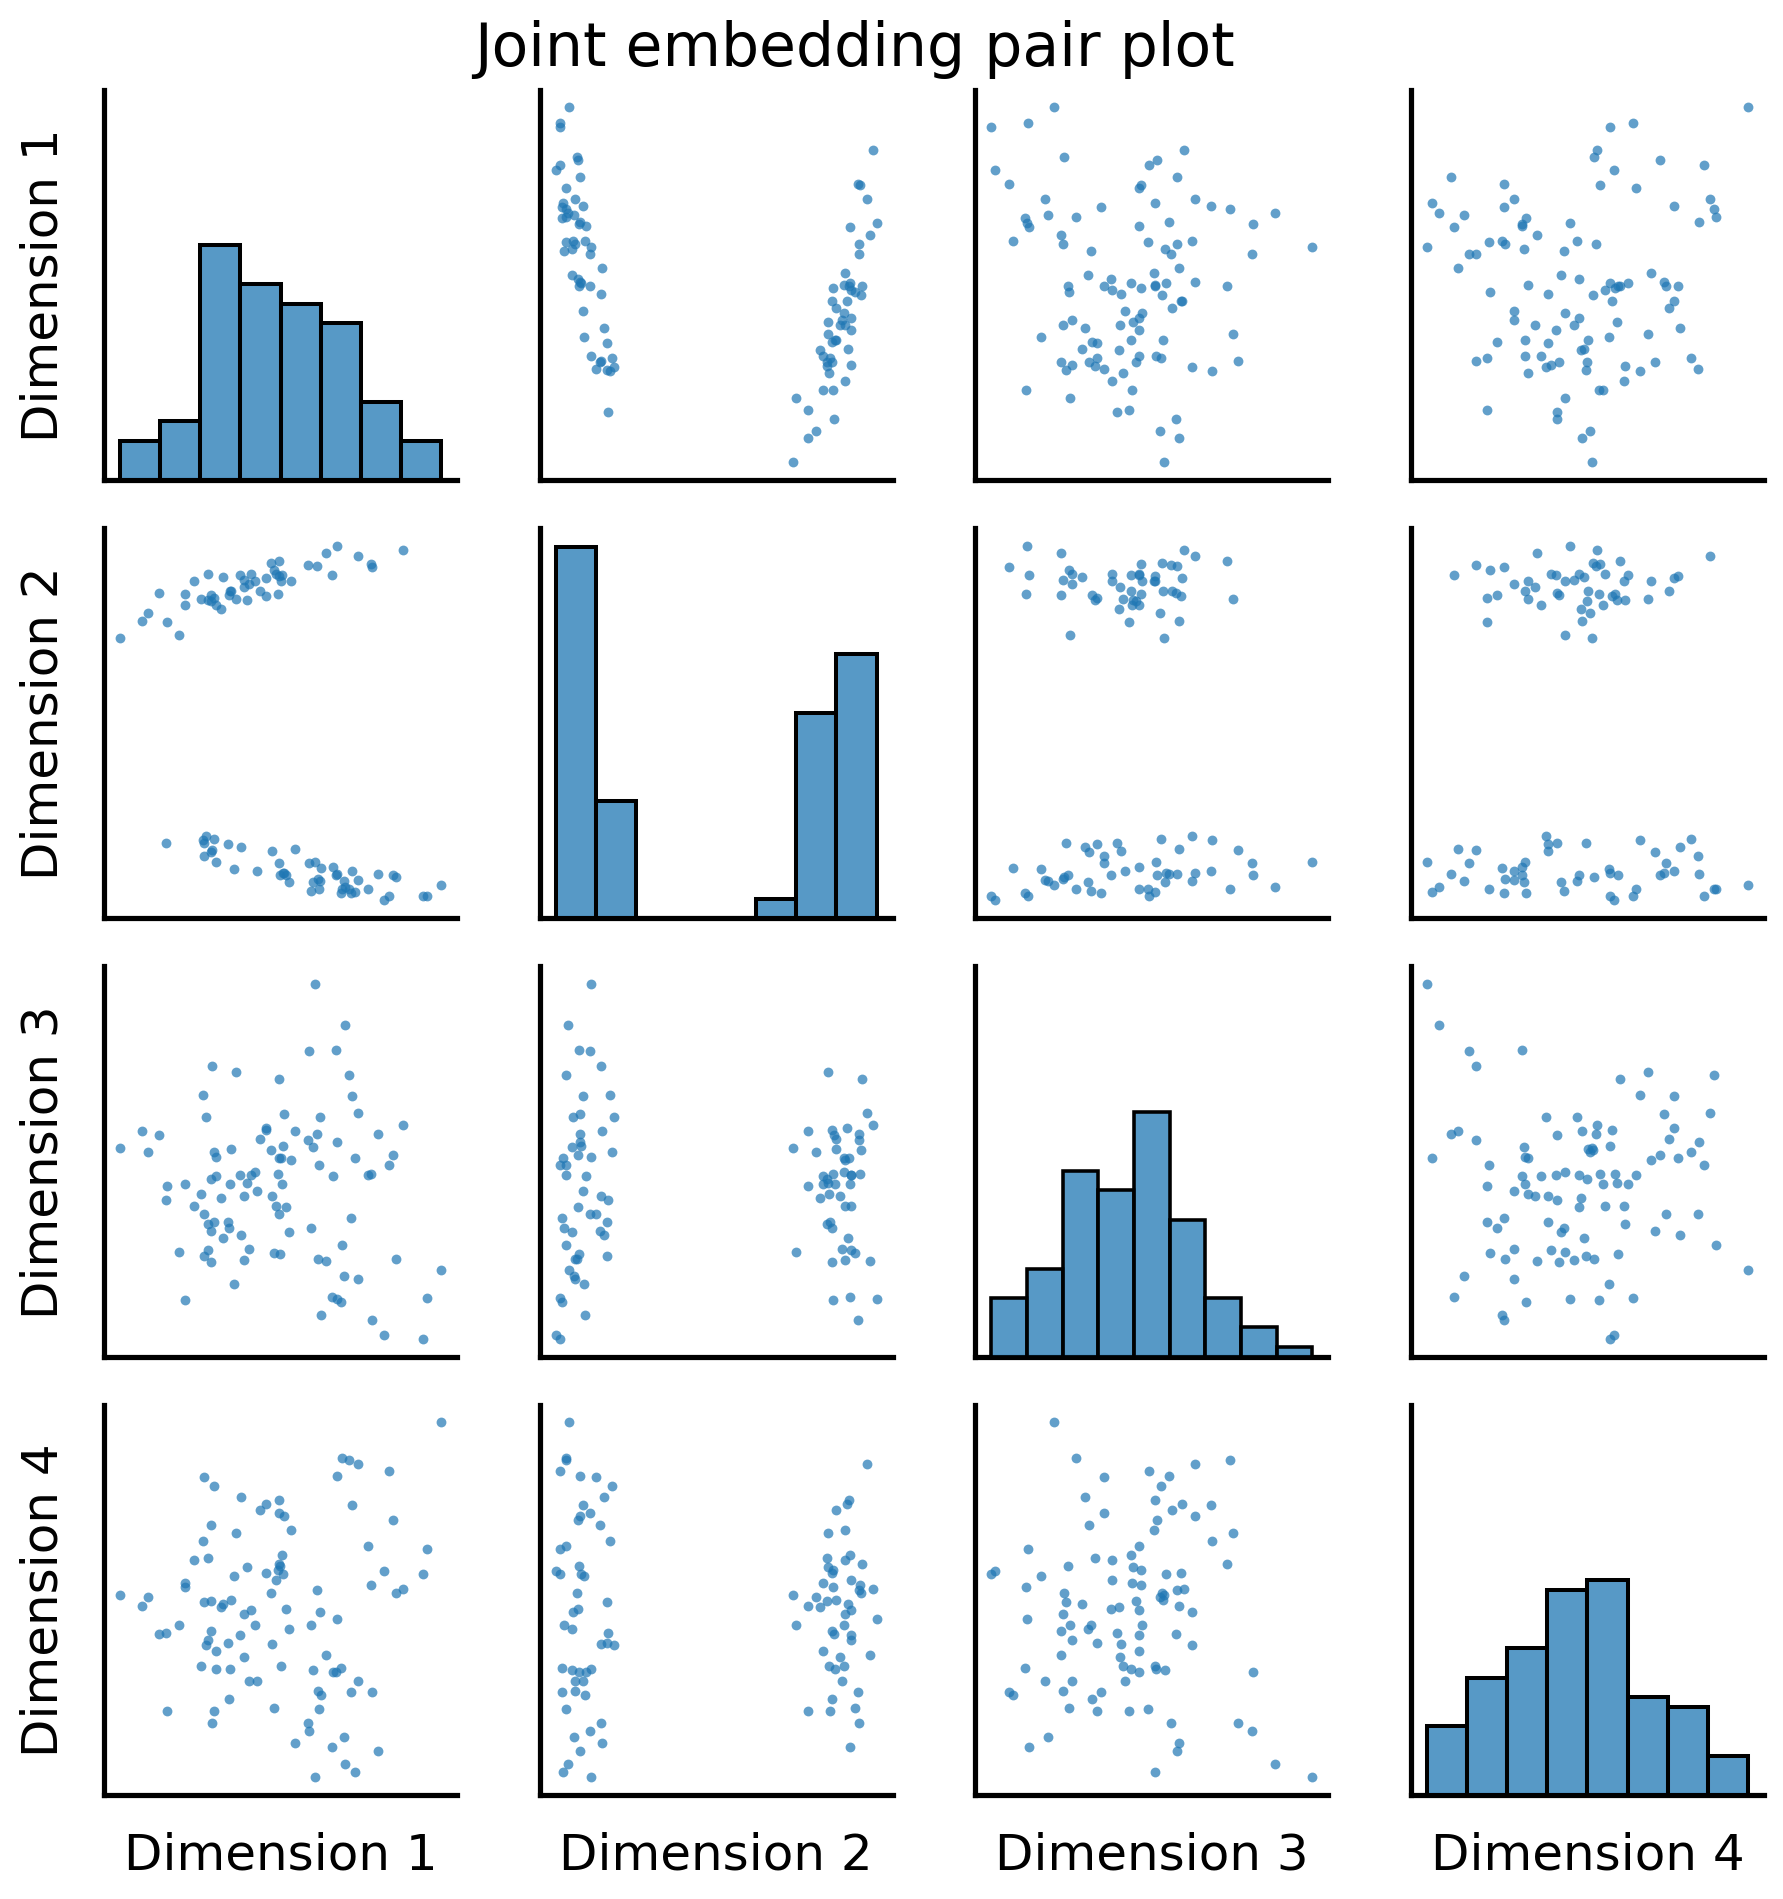

In [33]:
from matplotlib.gridspec import GridSpec
from graphbook_code import cmaps

_ = pairplot(joint_embedding, title="Joint embedding pair plot")

Excellent! Now, for each node, we have a *shared latent position*, the points in the pairplot above, associated with that node. This could also be visualized as a heatmap:

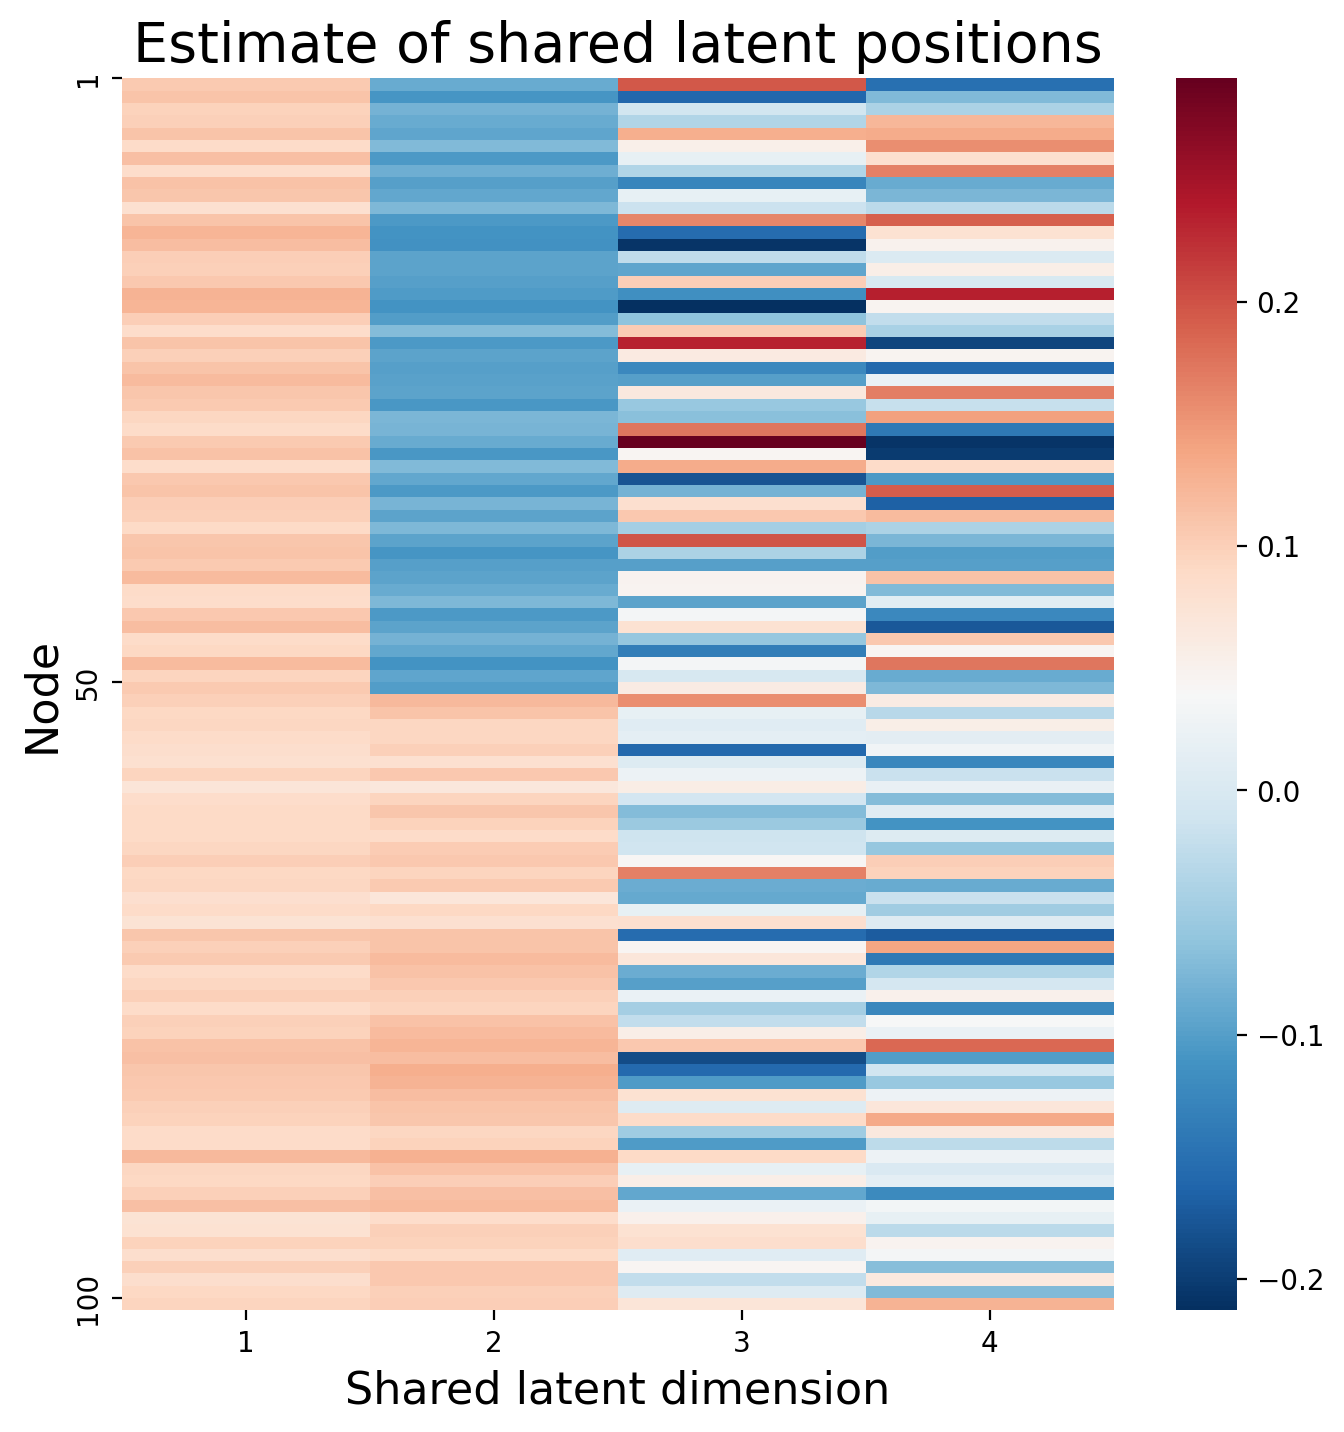

In [34]:
fig, ax = plt.subplots(figsize=(8, 8))
hm = sns.heatmap(joint_embedding, cmap=cmap, ax=ax, yticklabels=50);
hm.set_title(f"Estimate of shared latent positions", fontdict={'fontsize': 20});
hm.set_xlabel("Shared latent dimension", fontsize=16)
hm.set_yticks([0, 49, 99])
hm.set_yticklabels([1, 50, 100])
hm.set_xticks([0.5, 1.5, 2.5, 3.5])
hm.set_xticklabels([1, 2, 3, 4])
hm.set_ylabel("Node", fontsize=16);

We'll call the resulting embedding for the joint matrix an estimate of the shared latent positions, the matrix $\hat V$, which has a single row $i$ for the shared latent position $\vec v_i$ associated with each node $i$. This matrix will be $n \times d$, where $n$ is the number of nodes, and $d$ is either a pre-selected dimensionality you wanted to embed into, or a value chosen through elbow selection. 

Next, we'll see how we can take these estimates of shared latent positions in $\hat V$, and build embedded representations of our networks in the same space.

### Relating the joint embedding to the shared latent positions

Exactly how is the joint embedding you created related to all of your separate, original networks? Well, to understand this, you need to delve back to the concept of the probability matrix and the score matrix.

Remember that under the COSIE model, the probability matrix for the $i^{th}$ network could be described as:

\begin{align*}
    P^{(i)} &= VR^{(i)}V^\top
\end{align*}

where $V$ conveyed the *homogeneity* across all $M$ networks (the *shared latent space*), and $R^{(i)}$ conveyed the unique aspects of the probability matrix for a particular network $i$.

You want to be able to use a similar strategy with your set of networks, but like the problem you ran into with estimating parameters for your Random Dot Product Graph from {numref}`ch5:rdpg`: you have no way to model the probability matrix, since you don't *actually* know the probability matrix, you only see a network. What can you do?

Just like with the Random Dot Product Graph, you can think of the adjacency matrices $A^{(i)}$ as surrogates for the probability matrices $P^{(i)}$. This means that when you use MASE to produce estimated shared latent positions, what you are really doing is estimating $\hat V$, the shared latent positions across all $M$ networks. When you looked at the latent positions a second ago, what you looked at was the estimate of the shared latent positions using the procedure we outlined above. As we clarified before, it is important to notice that this joint embedding can be useful *without* making an explicit statement about the COSIE model, but when you *do* assume that the COSIE model is a reasonable fit for your data, this interpretation is fairly clean and intuitive.

Similar to $V$ under the COSIE model, it turns out that the $\hat V$ you found above is also going to be *orthonormal*. As you learned of the shared latent position matrix in {numref}`ch5:multi:cosie:slpm`, what this means is that $\hat V^\top \hat V = I$, the identity matrix. Remember that the identity matrix is analogous to multiplying by $1$ for matrices. You will use this fact to uncover estimates of the score matrices for each network.

#### Finding the score matrices

Any particular score matrix, $R^{(i)}$, is square and $d \times d$. The dimension, $d$, corresponds to the number of embedding dimensions -- so if you wanted to embed down to two dimensions, each $R^{(i)}$ would be a $2 \times 2$ matrix. 

Now, here's the interesting part: how do you find your score matrices? Let's copy down the shared latent position matrix, $\hat V$, below and show first that it is orthonormal:

In [35]:
np.round(joint_embedding.T@joint_embedding)

array([[ 1., -0.,  0., -0.],
       [-0.,  1., -0.,  0.],
       [ 0., -0.,  1., -0.],
       [-0.,  0., -0.,  1.]])

and so, finally, you can use the above fact to find the score matrix for a particular network. Remember that for your purposes, you're assuming that $P^{(i)} = VR^{(i)}V^\top$, and you just replaced $A^{(i)}$ for $P^{(i)}$, and then you estimated $V$ with $\hat V$. If you didn't embed the shared latent positions down into $d$ dimensions at *all*, you would have that:
\begin{align*}
    A^{(i)} &= \hat V R^{(i)}\hat V^\top
\end{align*}

However, because you cut off $\hat V$ at $2$ dimensions, what you have is:

\begin{align*}
    A^{(i)} \approx \hat V R^{(i)}\hat V^\top
\end{align*}
When we say $\approx$ (approximately), what we mean again is that $A^{(i)}$ and $\hat VR^{(i)}\hat V^\top$ are *close* (their [Frobenius difference](ch6:se:frob_dist) is small), but not quite exact. The fact that we cut off some dimensions for $\hat V$ meant that we had to delete *some* information about the adjacency matrices. Like for the [spectral embedding](ch6:spectral), however, the information we deleted was, in terms of the singular values, the *least* important information for describing each $A^{(i)}$, so hopefully it didn't matter too much.

If you take this formula, left-multiply by $\hat V^\top$, and right-multiply by $\hat V$, then you get that:

\begin{align*}
    A^{(i)} &\approx \hat VR^{(i)} \hat V^\top \\
    \hat V^{\top} A^{(i)} \hat V &\approx (V^\top V) R^{(i)} (\hat V^\top \hat V) \\
    \hat V^\top A^{(i)} \hat V &\approx R^{(i)} 
\end{align*}
and you will use this equation, $\hat V^\top A^{(i)}\hat V$ as your estimate of the score matrix $R^{(i)}$. Again, since we are estimating a parameter, we will typically use the notation $\hat R^{(i)} = \hat V^\top A^{(i)}\hat V$ to denote this quantity.

Below, you turn the list of four networks you already embedded into a 3-D numpy array, and then do the above multiplication to get a new 3D numpy array of scores matrices. Because you embedded into $\hat d$ dimensions, each score matrix is $\hat d \times \hat d$, and the eight score matrices are "slices" along the 0th axis of the numpy array.

In [36]:
networks_array = np.asarray(networks)
scores = joint_embedding.T @ networks_array @ joint_embedding
scores.shape

(8, 4, 4)

So, if $\hat V\hat R^{(i)}\hat V^\top$ isn't *equal* to $A^{(i)}$ when you cut off at $d$ dimensions, what exactly is it?

Just like for the Random Dot Product Graph, what you've done is produced an *estimate* of the probability matrix, $\hat P^{(i)}$! In math symbols, what you would say is that:
\begin{align*}
    \hat P^{(i)} = \hat V \hat R^{(i)}\hat V^\top
\end{align*}

Below and to the left, you can see the original adjacency matrix for the first human network. Notice that two communities are readily apparent. Next, we take a look at the estimates shared latent positions, and the score matrix for the first human network. Note that the second dimension differentiates the two communities readily, in that the estimates of the shared latent positions for the second dimension are high for one community and low for the other community. The score matrix shows a high contribution of the second dimension (the $(2, 2)$ block of the score matrix has a large magnitude), which indicates that this dimension contributes a large amount to the embedding of the first human network in the shared embedded space. 

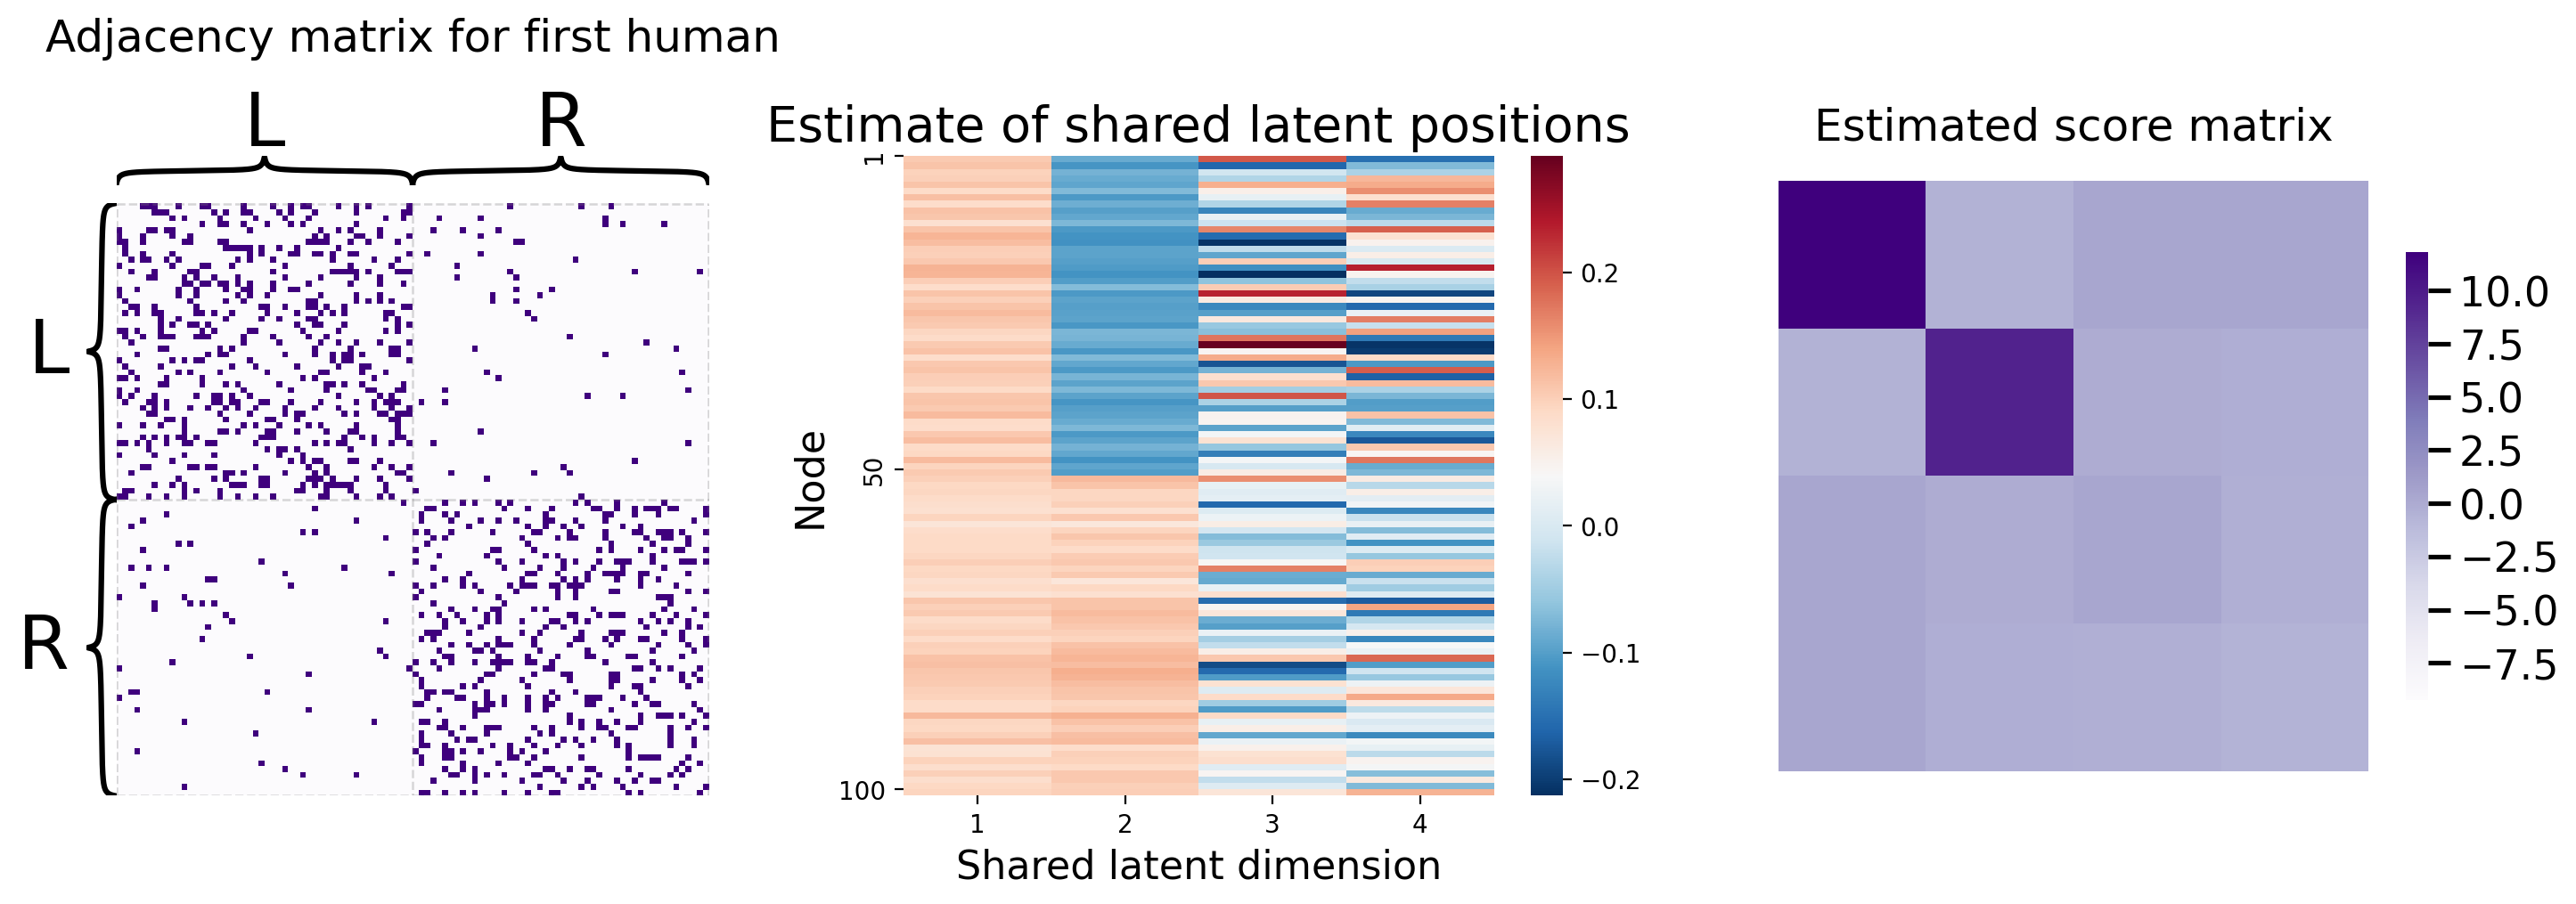

In [37]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

score_vmin = scores.min(); score_vmax = scores.max()
heatmap(humans[0], inner_hier_labels=human_labs, title="Adjacency matrix for first human",
               ax=axs[0], cbar=False)

hm = sns.heatmap(joint_embedding, cmap=cmap, ax=axs[1], yticklabels=50);
hm.set_title(f"Estimate of shared latent positions", fontdict={'fontsize': 20});
hm.set_xlabel("Shared latent dimension", fontsize=16)
hm.set_yticks([0, 49, 99])
hm.set_yticklabels([1, 50, 100])
hm.set_xticks([0.5, 1.5, 2.5, 3.5])
hm.set_xticklabels([1, 2, 3, 4])
hm.set_ylabel("Node", fontsize=16);

heatmap(scores[0], title="Estimated score matrix", ax=axs[2], vmin=score_vmin, vmax=score_vmax)

plt.tight_layout()

Finally, we can take a look at the estimated probability matrix for the first human network, and compare it against the true probability matrix for the first human network, using the equation we learned for $\hat P^{(i)}$, that $\hat P^{(i)} = \hat V \hat R^{(i)} \hat V^\top$:

In [43]:
# take scores from first human and use embedding to obtain Phat
Phat_human1 = joint_embedding @ scores[0] @ joint_embedding.T

# use equation to obtain the probability matrix from Ch5, RDPGs section
comm_assign = np.array([[1, 0] for i in range(int(n/2))] + [[0, 1] for i in range(int(n/2))])

Ptrue_human1 = comm_assign @ Phuman @ comm_assign.T

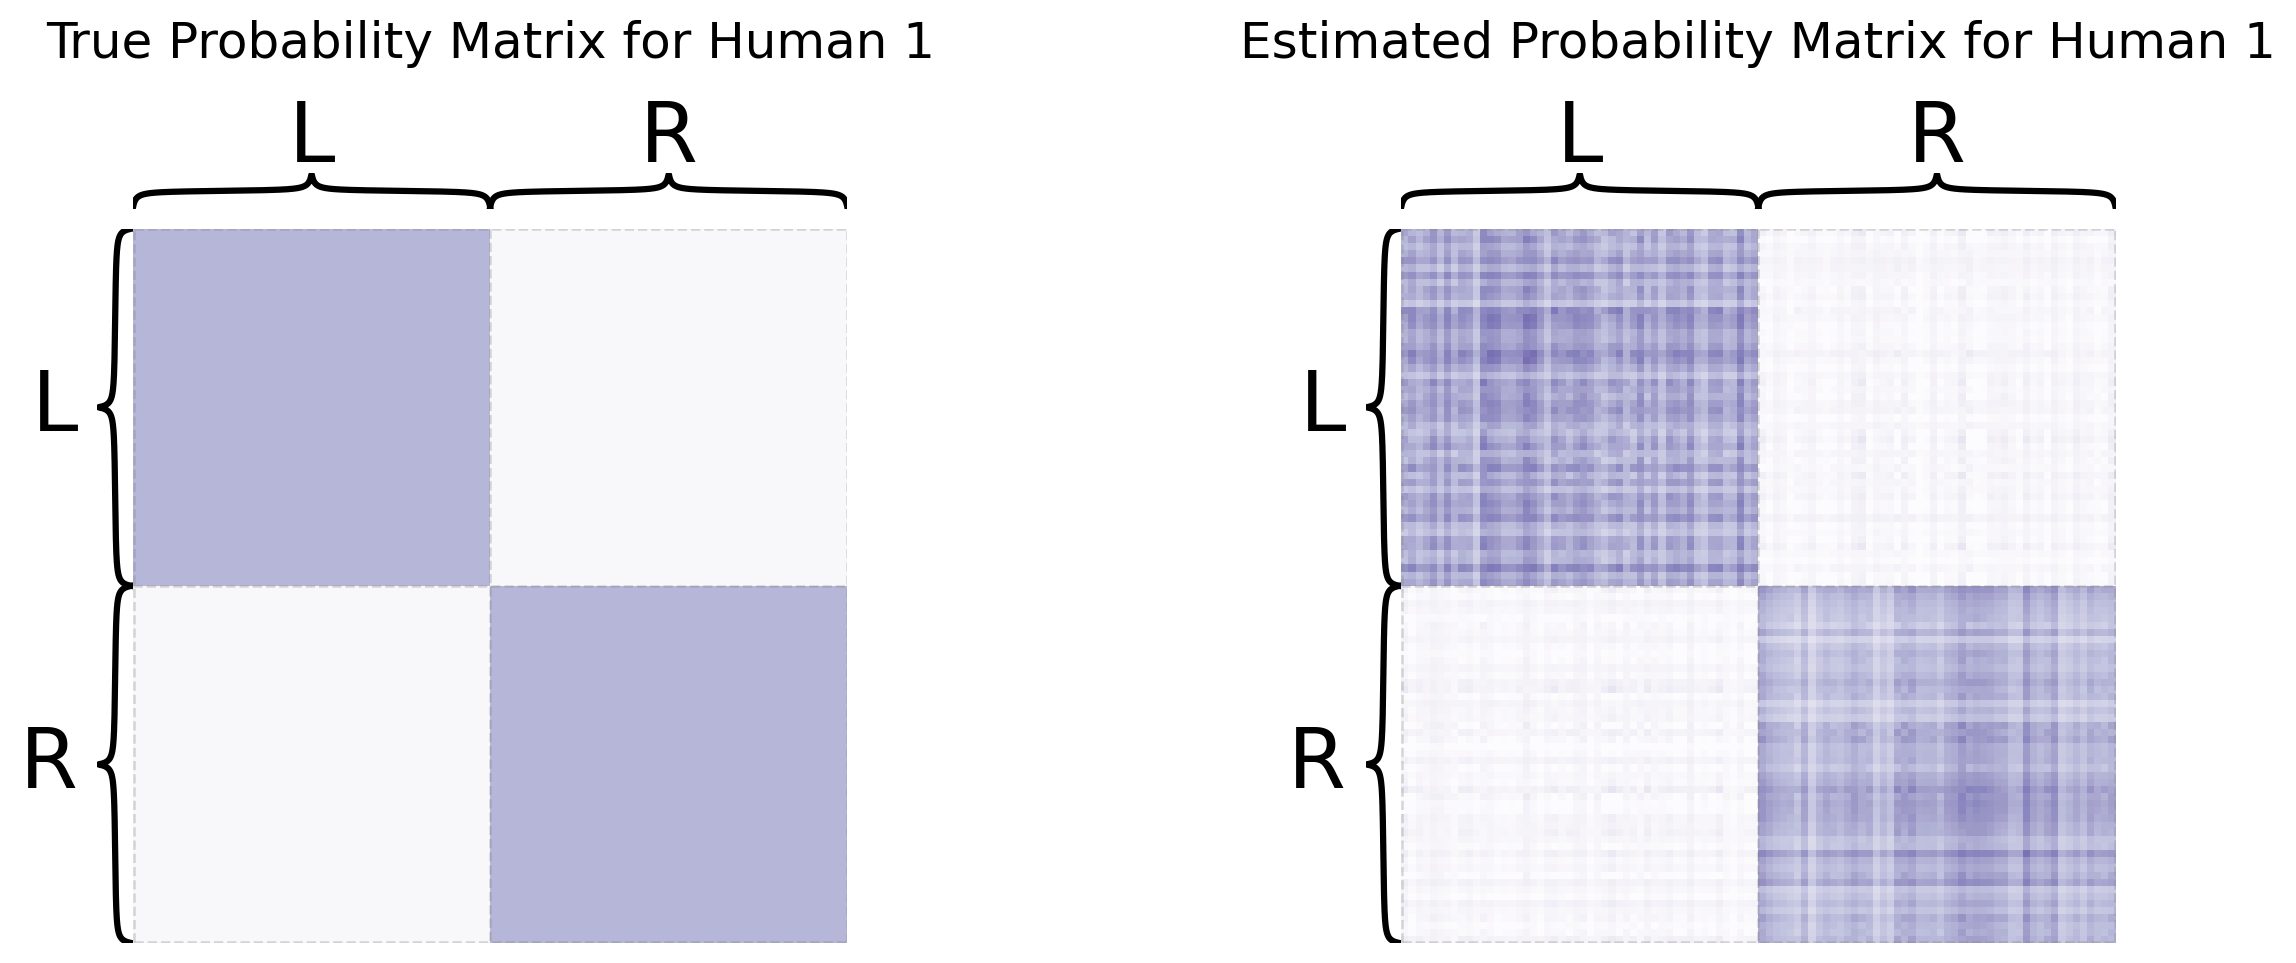

In [44]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

score_vmin = scores.min(); score_vmax = scores.max()
heatmap(Ptrue_human1, inner_hier_labels=human_labs, title="True Probability Matrix for Human 1",
               ax=axs[0], cbar=False, vmin=0, vmax=0.5)
heatmap(Phat_human1, inner_hier_labels=human_labs, title="Estimated Probability Matrix for Human 1",
               ax=axs[1], cbar=False, vmin=0, vmax=0.5);

Not bad! Now let's take a look for the first alien network. We'll again look at the adjacency matrix, the shared latent positions, and the estimated score matrix:

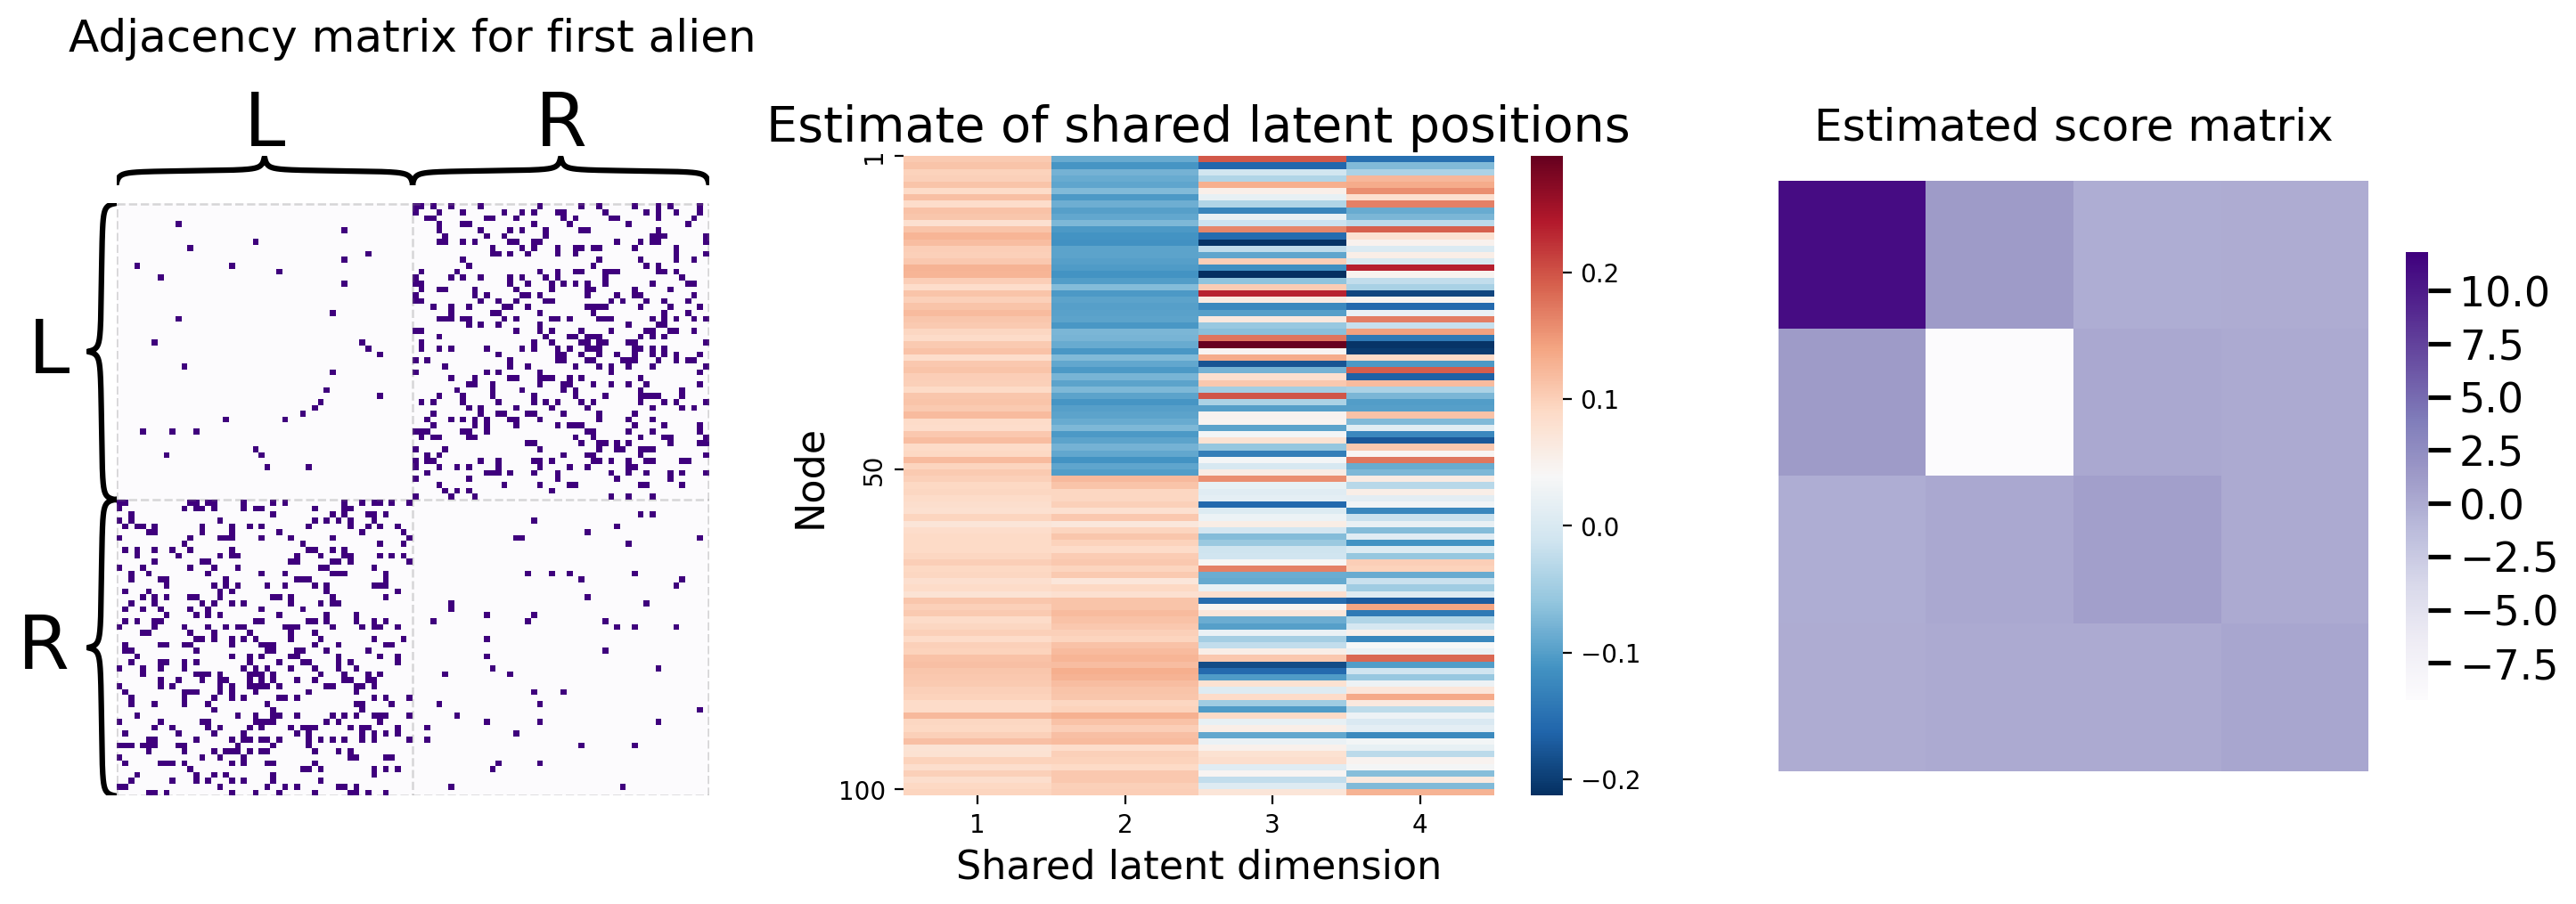

In [45]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

score_vmin = scores.min(); score_vmax = scores.max()
heatmap(aliens[0], inner_hier_labels=alien_labs, title="Adjacency matrix for first alien",
               ax=axs[0], cbar=False)

hm = sns.heatmap(joint_embedding, cmap=cmap, ax=axs[1], yticklabels=50);
hm.set_title(f"Estimate of shared latent positions", fontdict={'fontsize': 20});
hm.set_xlabel("Shared latent dimension", fontsize=16)
hm.set_yticks([0, 49, 99])
hm.set_yticklabels([1, 50, 100])
hm.set_xticks([0.5, 1.5, 2.5, 3.5])
hm.set_xticklabels([1, 2, 3, 4])
hm.set_ylabel("Node", fontsize=16);

heatmap(scores[4], title="Estimated score matrix", ax=axs[2], vmin=score_vmin, vmax=score_vmax)

plt.tight_layout()

Notice that the estimated score matrix has a *negative* score for dimension $2$, which was the dimension associated with the left/right hemisphere separability, whereas for humans, this score was highly positive. This means that the the estimated shared latent dimension $2$ (and its corresponding *score*) are conveying the homoegeneity (that there is left/right hemisphere separability across all of the networks) and concurrently the heterogeneity (as reflected in the different scores) between human and alien networks. This time, when we look at the estimated probability matrix against the true probability matrix:

In [46]:
# take scores from first alien and use embedding to obtain Phat
Phat_alien1 = joint_embedding @ scores[4] @ joint_embedding.T

Ptrue_alien1 = comm_assign @ Palien @ comm_assign.T

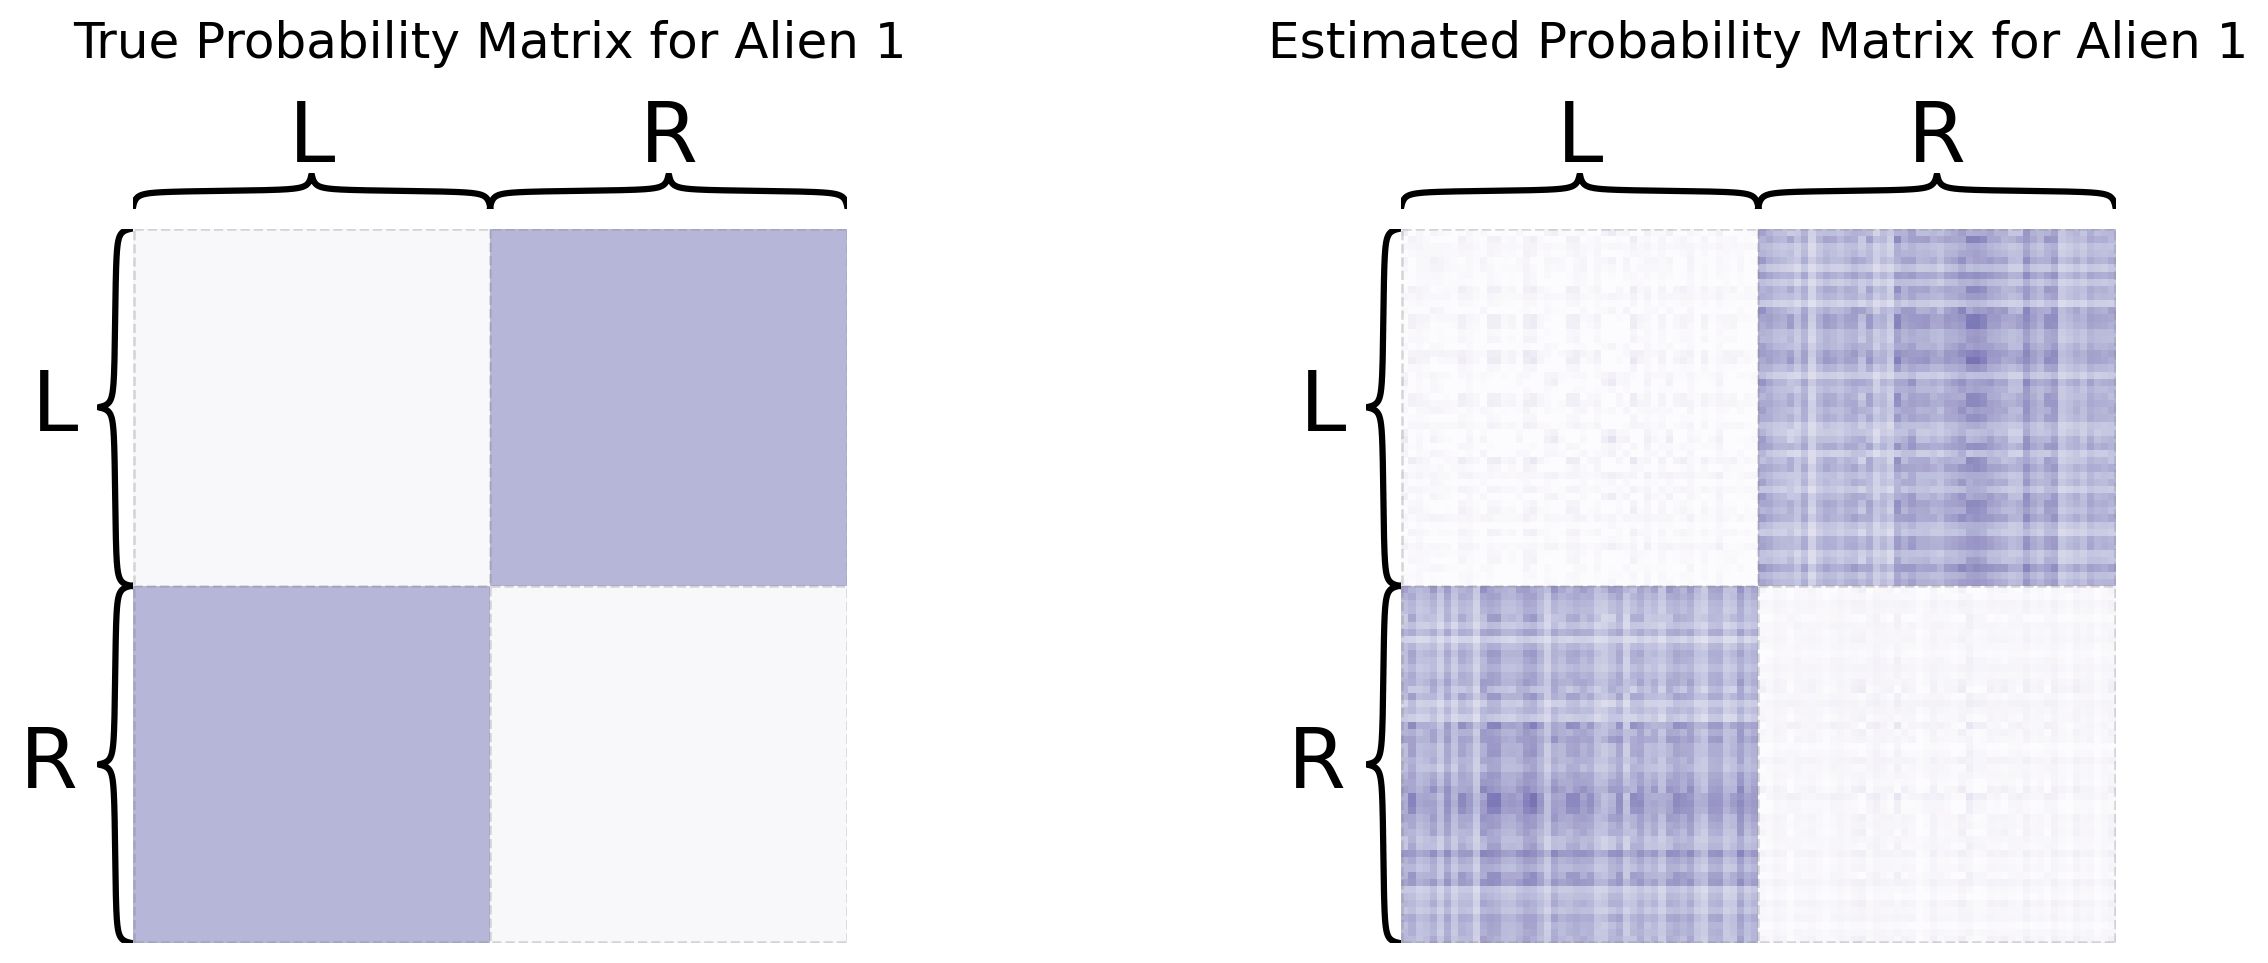

In [47]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

score_vmin = scores.min(); score_vmax = scores.max()
heatmap(Ptrue_alien1, inner_hier_labels=alien_labs, title="True Probability Matrix for Alien 1",
               ax=axs[0], cbar=False, vmin=0, vmax=0.5)
heatmap(Phat_alien1, inner_hier_labels=alien_labs, title="Estimated Probability Matrix for Alien 1",
               ax=axs[1], cbar=False, vmin=0, vmax=0.5);

And we've successfully recovered a lot of the structure from the alien probability matrix! In particular, as we can see, the left and right hemisphere nodes are clearly separated. Awesome!

### Using Graspologic

In practice, you don't actually have to implement any of this yourself. Graspologic's `MultipleASE` class implements it all for you under the hood. You can see the embedding below - you give `MultipleASE` a list of networks, and it spits out a set of joint latent positions. Graspologic's implementation of MASE is doing pretty much exactly what you just did: it embeds all of the networks you pass in, concatenates them horizontally, and then re-embeds the concatenated matrix. You can see this in the figure -- MASE's embedding looks just like the one you made above.

In [48]:
from graspologic.embed import MultipleASE as MASE

mase = MASE()
latents = mase.fit_transform(networks)

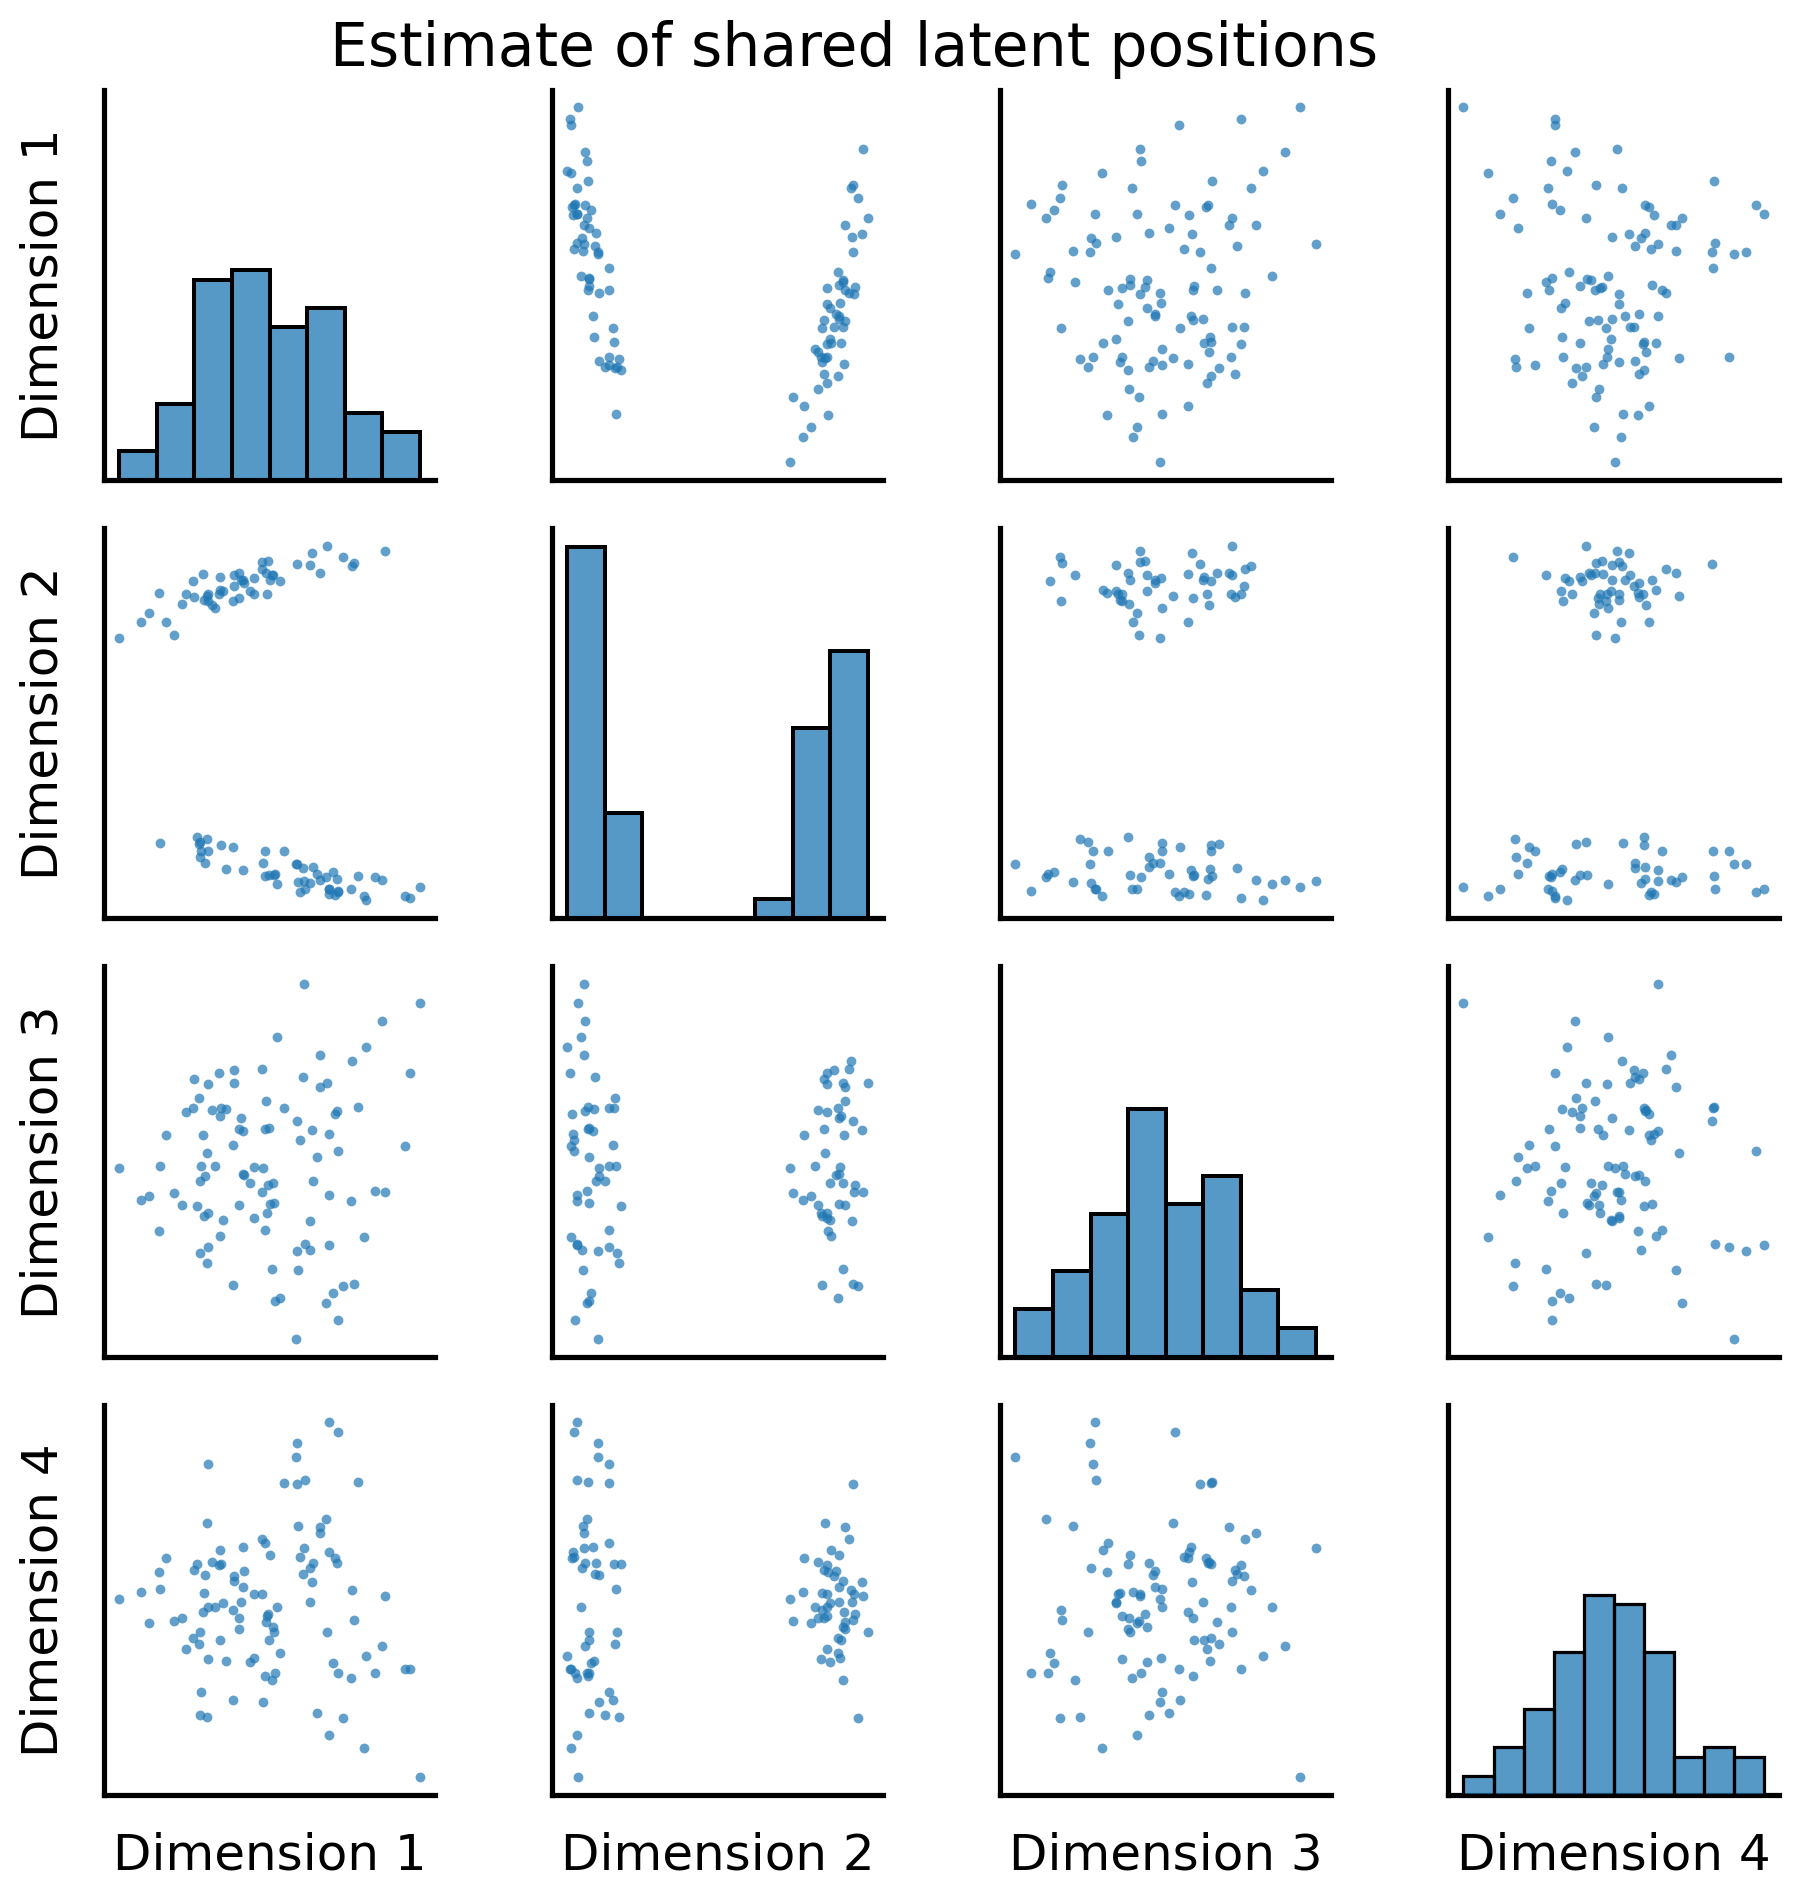

In [49]:
_ = pairplot(latents, title="Estimate of shared latent positions")

You can recover the score matrices with similar ease, like we do below for the first human:

In [50]:
Rhat_human1 = mase.scores_[0]

So you've learned that MASE is useful when you want a joint embedding that incorporates an element of *homogeneity* across all of your networks, but still allows your networks to have some unique aspects of *heterogeneity*. For more details about MASE, check out the original paper from {cite:p}`Arroyo2021`.

What if you wanted to keep your separate embeddings totally differentiated (you don't necessarily want to assume there is *any* shared structure from network to network), but put them all in the same space? That's what the Omnibus Embedding gives, and what you'll explore now.

(ch6:multinet:omni)=
## Omnibus Embedding (OMNI)

The Omnibus Embedding combines networks separately to put them all into the same latent space. What this means is that the embeddings for each network after the omnibus embedding are *directly comparable*: none of the embeddings are rotations of each other, and distances between nodes across embeddings actually means something. You can use the omnibus embedding to answer a variety of questions about the interacting properties of a collection of networks. For example, you could figure out which nodes or subgraphs are responsible for similarities or differences across your networks, or you could determine whether subcommunities in your networks are statistically similar or different. You could try to figure out which underlying parameters of your network are the same, and which are different.

In the next section, you'll explore how the Omnibus Embedding works. Sections in future chapters will explore some the things you can do with your separate embeddings to learn about your networks.

### How Does OMNI work?

At a high level, the omnibus embedding is fairly simple. It:
1. Combines the adjacency matrices for all of your networks into a single, giant matrix (the Omnibus Matrix)
2. Embeds that matrix using a standard adjacency or Laplacian Spectral Embedding.

The omnibus matrix itself just has every original adjacency or laplacian matrix along its diagonal, and the elementwise average of every pair of original matrices on the off-diagonals. This means that the Omnibus Matrix is *huge*: if you have $M$ networks, each of which has $n$ nodes, the Omnibus Matrix will be a $Mn \times Mn$ matrix.

For example, say you only have two networks. Let's name their adjacency matrices $A^{(1)}$ and $A^{(2)}$. Then, the omnibus matrix looks like this:

\begin{align}
\begin{bmatrix}
A^{(1)} & \frac{A^{(1)} + A^{(2)}}{2} \\
\frac{A^{(2)} + A^{(1)}}{2} & A^{(2)} \\
\end{bmatrix}
\end{align}

where each entry on the diagonal is itself a matrix. In general, when you have $M$ networks, the $i_{th}$ diagonal entry is $A^{(i)}$ and the $(i, j)_{th}$ entry is $\frac{A^{(i)} + A^{(j)}}{2}$. What this means is that you just stick each of your adjacency matrices on the diagonal of a large matrix, and you fill in the off-diagonals with the averages of each pair of two adjacency matrices.

You can see this in code below. Below, you just use numpy's block function to generate your simple Omnibus Matrix from two networks.

In [51]:
a0, a1 = networks[0], networks[1]
omni = np.block([[a0, (a0+a1)/2],
                 [(a1+a0)/2, a1]])

Below you can see the resulting Omnibus Matrix. The first and second networks are shown as heatmaps on the left, and their Omnibus Matrix is shown on the right.

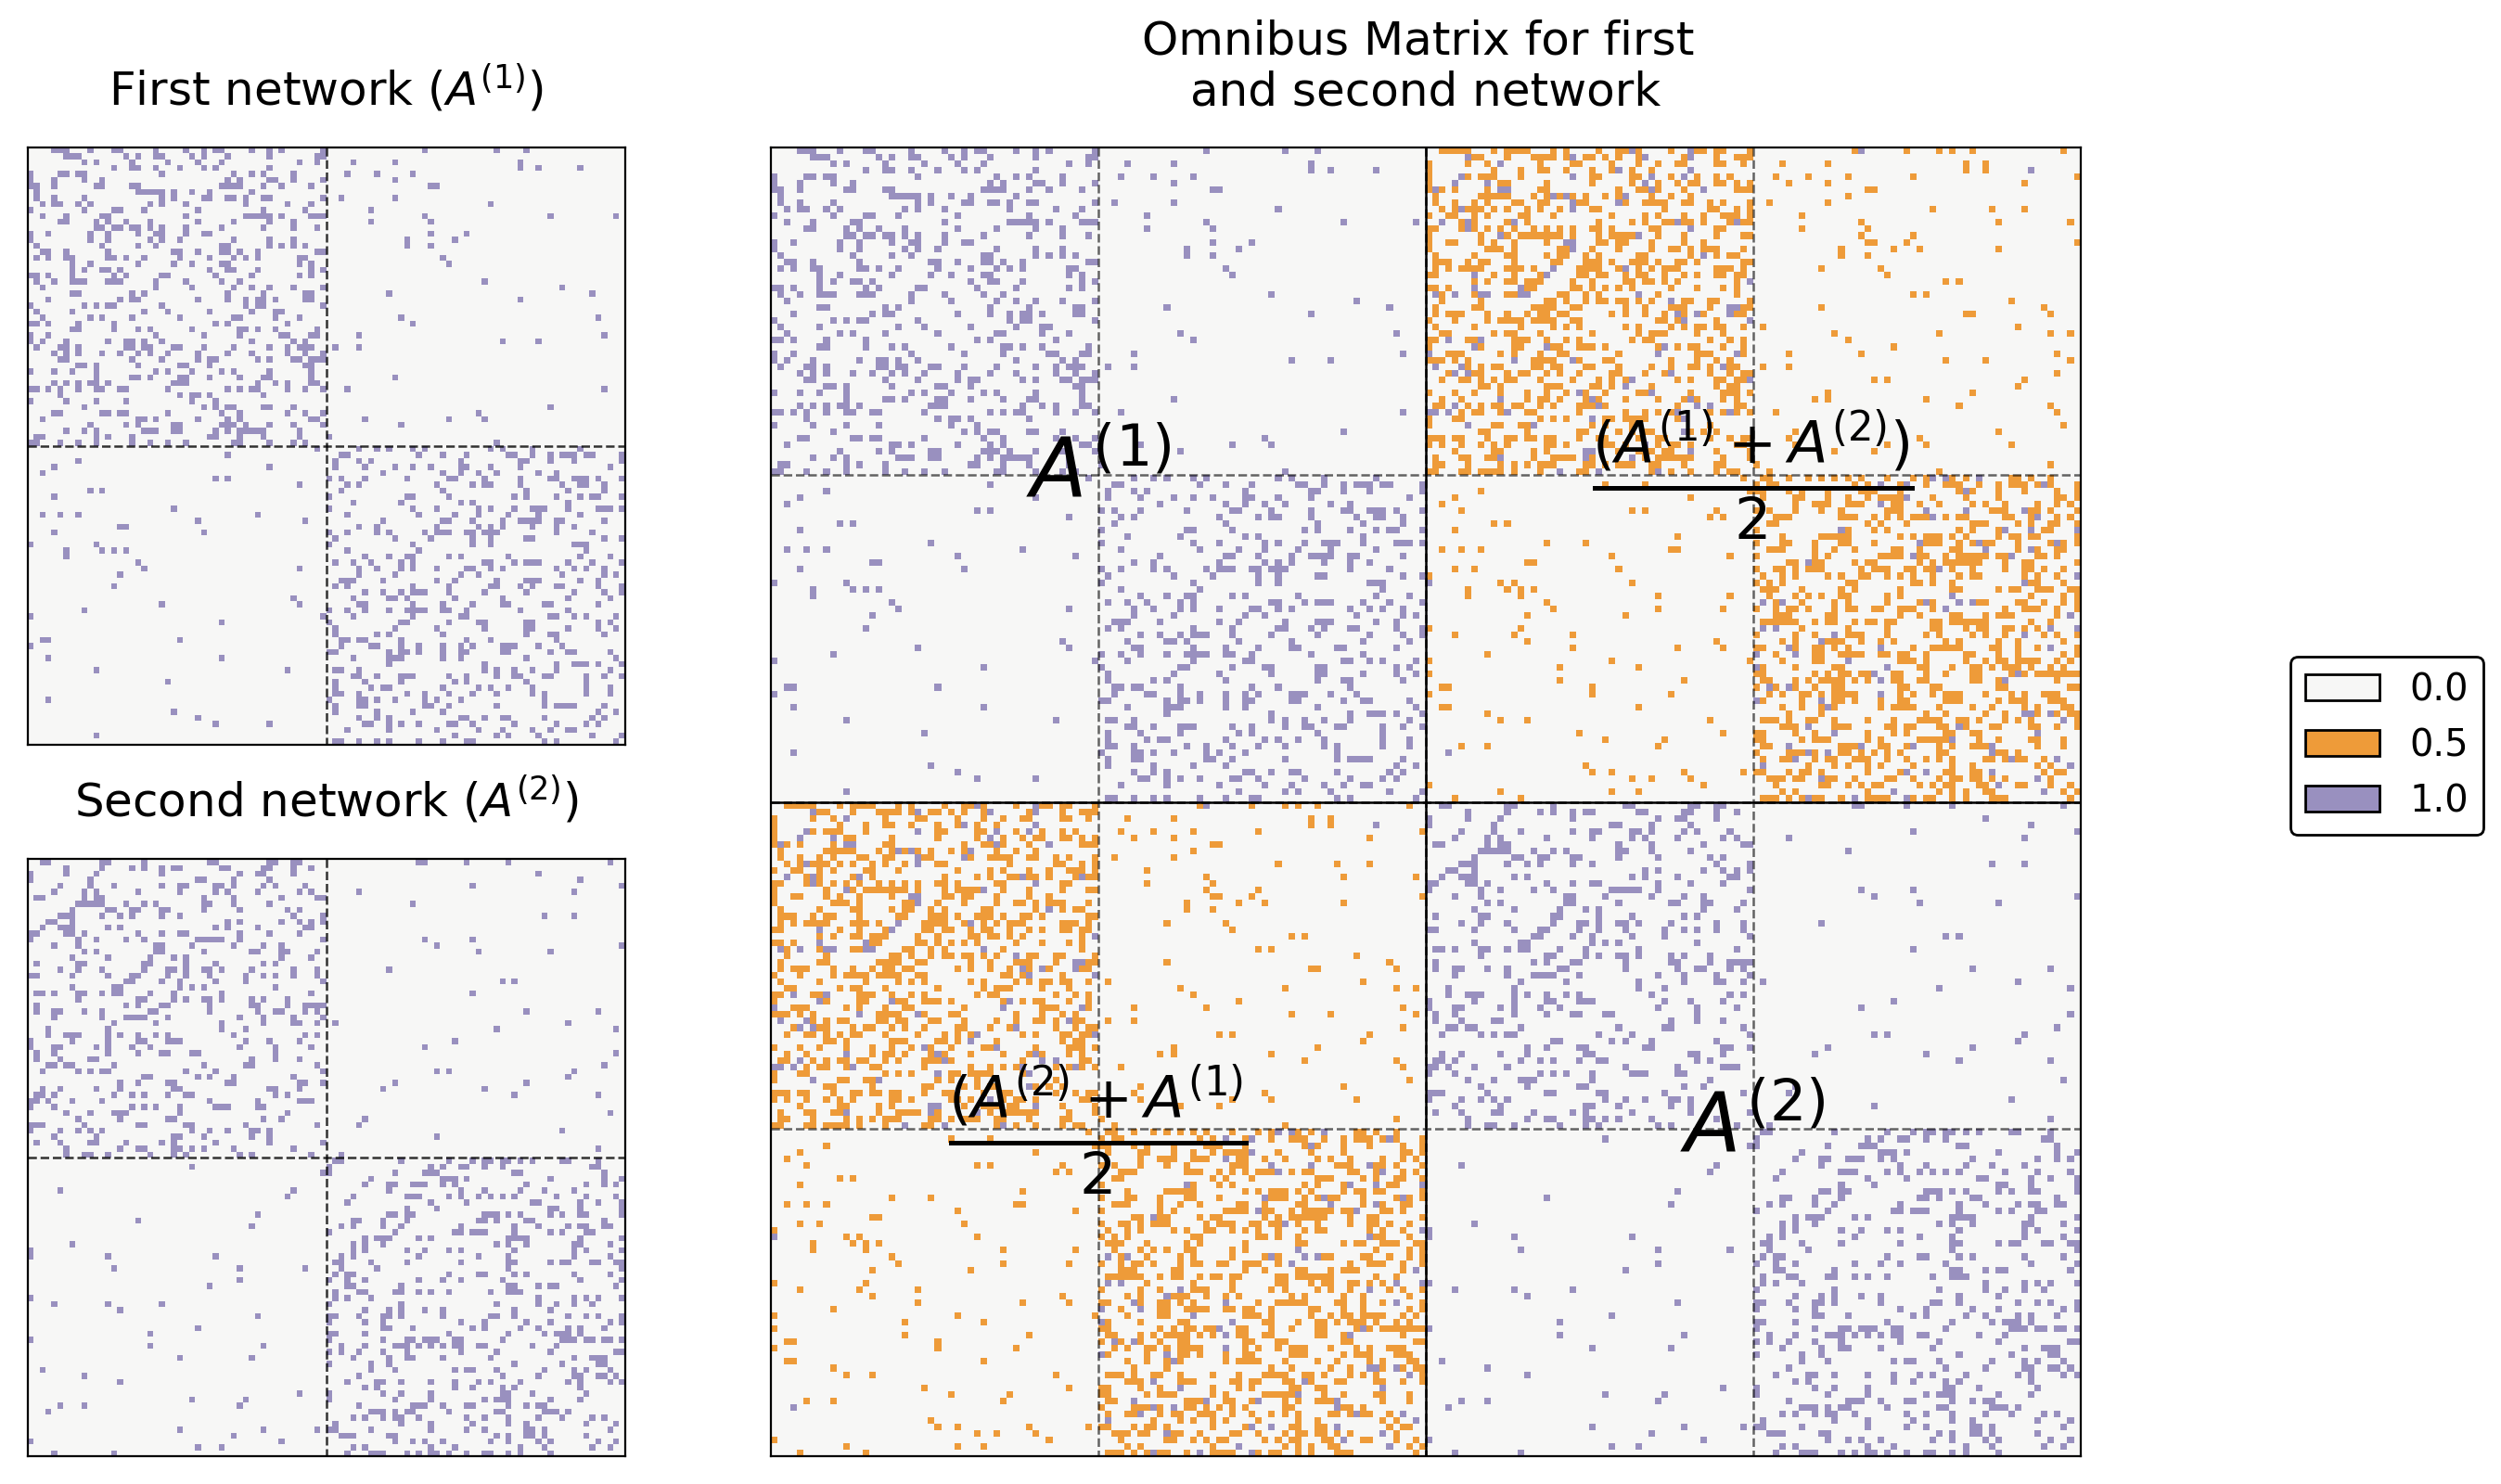

In [52]:
from graphbook_code import text
from graphbook_code import lined_heatmap, add_legend
# fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig = plt.figure(figsize=(12, 8))
gs = GridSpec(2, 3)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[1, 0])
ax_omni = fig.add_subplot(gs[:, 1:])

# first two
omni_cmap = list(np.array(sns.color_palette("PuOr_r", 3))[[1, 2, 0]])
for i, (ax, data) in enumerate(zip([ax0, ax1], [a0, a1])):
    title = r"First network ($A^{(1)}$)" if i==0 else r"Second network ($A^{(2)}$)"
    hm = lined_heatmap(data, ax=ax, legend=False, title=title, 
                       colors=[omni_cmap[0], omni_cmap[2]])


# big one
hm = lined_heatmap(omni, ax=ax_omni, binary=False, cmap=omni_cmap,
                   title="Omnibus Matrix for first \nand second network",
                   cbar=False, center=None)

# outline
sns.despine(ax=ax_omni, top=False, bottom=False, left=False, right=False)

# separating lines
hm.vlines(len(omni)//2, 0, len(omni), colors="black", lw=.9, alpha=1)
hm.hlines(len(omni)//2, 0, len(omni), colors="black", lw=.9, alpha=1)
for i in [.25, .75]:
    hm.vlines(len(omni)*i, 0, len(omni), colors="black", lw=.9, linestyle="dashed", alpha=.6)
    hm.hlines(len(omni)*i, 0, len(omni), colors="black", lw=.9, linestyle="dashed", alpha=.6)
    
# text
text(r"$A^{(1)}$", .25, .75)
text(r"$A^{(2)}$", .75, .25)
text(r"$\frac{(A^{(2)} + A^{(1)}}{2}$", .25, .25)
text(r"$\frac{(A^{(1)} + A^{(2)})}{2}$", .75, .75)

# legend
omni_labels = np.unique(omni)
add_legend(legend_labels=omni_labels, colors=omni_cmap)

plt.tight_layout()

#### Creating the Omnibus Matrix For All Eight Networks

Here's the Omnibus Matrix for all eight of your networks. You can see adjacency matrices for the original four networks on the diagonal blocks, highlighted in blue, and all possible pairs of averages of adjacency matrices on the off-diagonal blocks, highlighted in orange.

In [53]:
from graspologic.embed.omni import _get_omni_matrix
omni = _get_omni_matrix(networks)

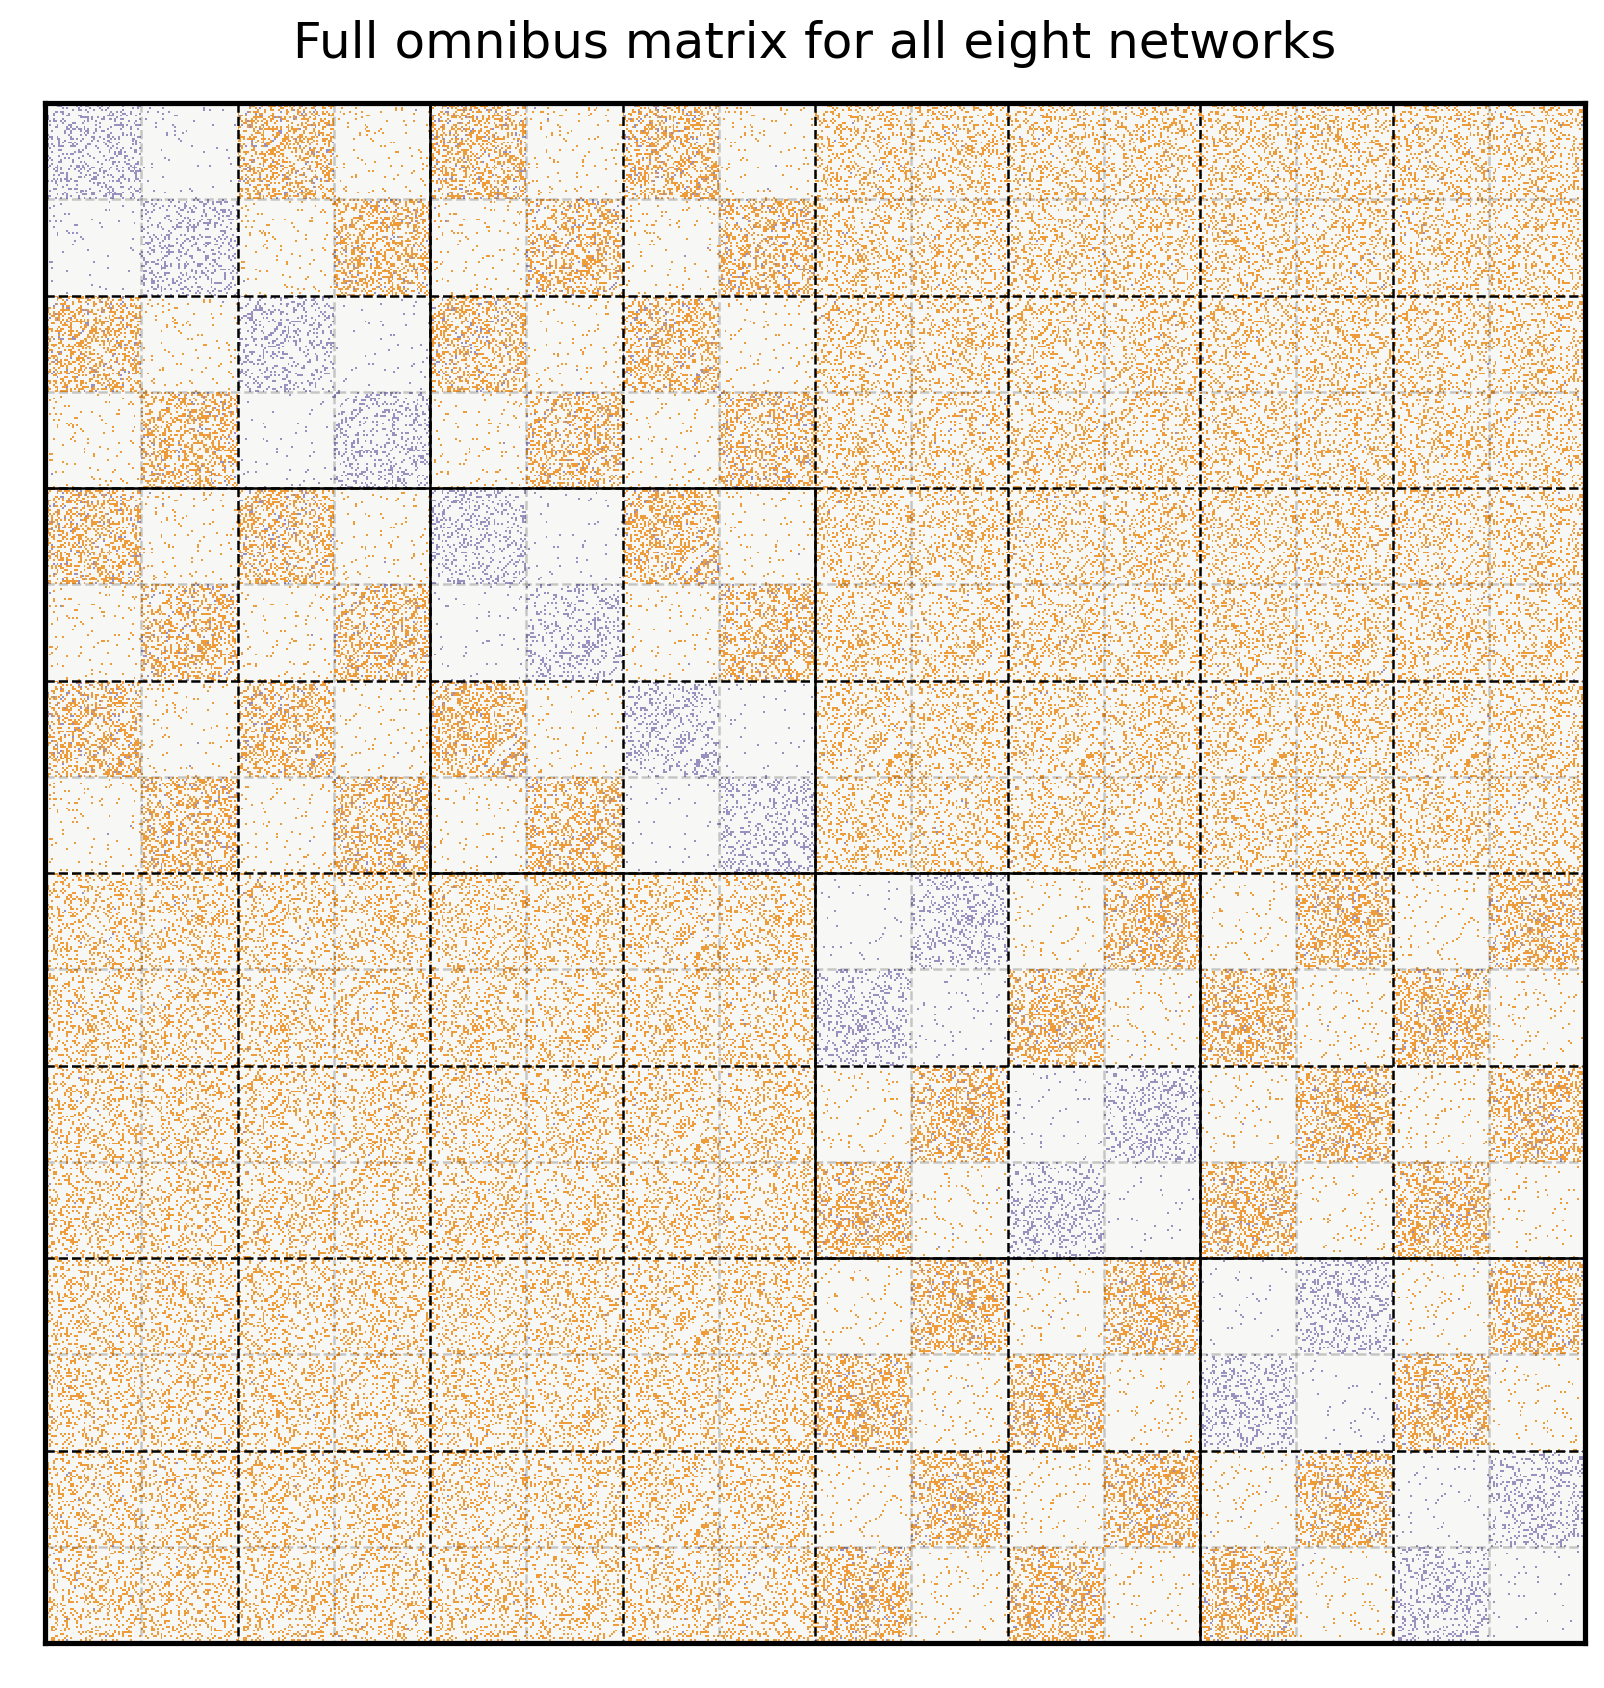

In [53]:
hm = lined_heatmap(omni, binary=False, cmap=omni_cmap, cbar=False,
                   title="Full omnibus matrix for all eight networks", center=None, alpha=0)
sns.despine(ax=hm, top=False, bottom=False, left=False, right=False)
for i in np.arange(8)*1/8:
    hm.vlines(len(omni)*i, 0, len(omni), colors="black", lw=.9, linestyle="dashed", alpha=1)
    hm.hlines(len(omni)*i, 0, len(omni), colors="black", lw=.9, linestyle="dashed", alpha=1)
for i in np.arange(1, 16, 2)*1/16:
    hm.vlines(len(omni)*i, 0, len(omni), colors="black", lw=.9, linestyle="dashed", alpha=.2)
    hm.hlines(len(omni)*i, 0, len(omni), colors="black", lw=.9, linestyle="dashed", alpha=.2)

n = len(omni)

# vertical solids
hm.vlines(n//4, 0, n//2, colors="black", lw=.9, alpha=1)
hm.vlines(n//2, n*.25, n*.75, colors="black", lw=.9, alpha=1)
hm.vlines(n*.75, n//2, n, colors="black", lw=.9, alpha=1)

# horizontal solids
hm.hlines(n//4, 0, n//2, colors="black", lw=.9, alpha=1)
hm.hlines(n//2, n*.25, n*.75, colors="black", lw=.9, alpha=1)
hm.hlines(n*.75, n//2, n, colors="black", lw=.9, alpha=1);

#### Embedding the Omnibus Matrix

You should understand the next step fairly well by now. You embed the Omnibus Matrix normally, using ASE, as if it were just a normal adjacency matrix. This will create an $Mn \times d$ sized latent position matrix (where, remember, $n$ is the number of nodes in each network, $M$ is the number of networks, and $d$ is the number of embedding dimensions). Here, since each of your four networks has 100 nodes, $Mn$ is 800, and you select the dimensionality for this matrix using [elbow selection](ch6:spectral:elbow).

In [54]:
from graspologic.embed import select_svd

U, D, V = select_svd(omni)
joint_embedding = U @ np.diag(np.sqrt(D))

joint_embedding.shape

(800, 3)

#### Creating Separate Latent Positions In The Same Latent Space

Now, the only question you have remaining is how to actually pull the separate latent positions for each network from this matrix. It turns out that the individual latent positions for each network are actually stacked on top of each other: the first $n$ rows of the joint matrix you just made correspond to the estimates of the latent positions of the first network, the second $n$ rows correspond to the estimates of the latent positions of the second network, and so on. 

If you want, you can pull out the separate latent positions for each network explicitly. Below, you reshape your 2-dimensional $Mn \times d$ numpy array for the omnbus embedding into a $M \times n \times d$ array: the embeddings for each network are now simply stacked on top of each other on the third dimension (and the first axis of your numpy array).

In [55]:
M = len(networks)
n = len(networks[0])
latent_networks = joint_embedding.reshape(M, n, -1)

latent_networks.shape

(8, 100, 3)

Below, you can see the embeddings you just created. On the left is the full $Mn \times d$ omnibus matrix, and on the right are the slices of the $M \times n \times d$ 3-D array you created above. If you look carefully, you can see that the top two blocks of colors (row-wise) in the larger embedding correspond to the latent positions for network 1, the second two blocks correspond to the latent positions for network 2, and so on. They're a bit squished, so that everything lines up nicely, but they're there.

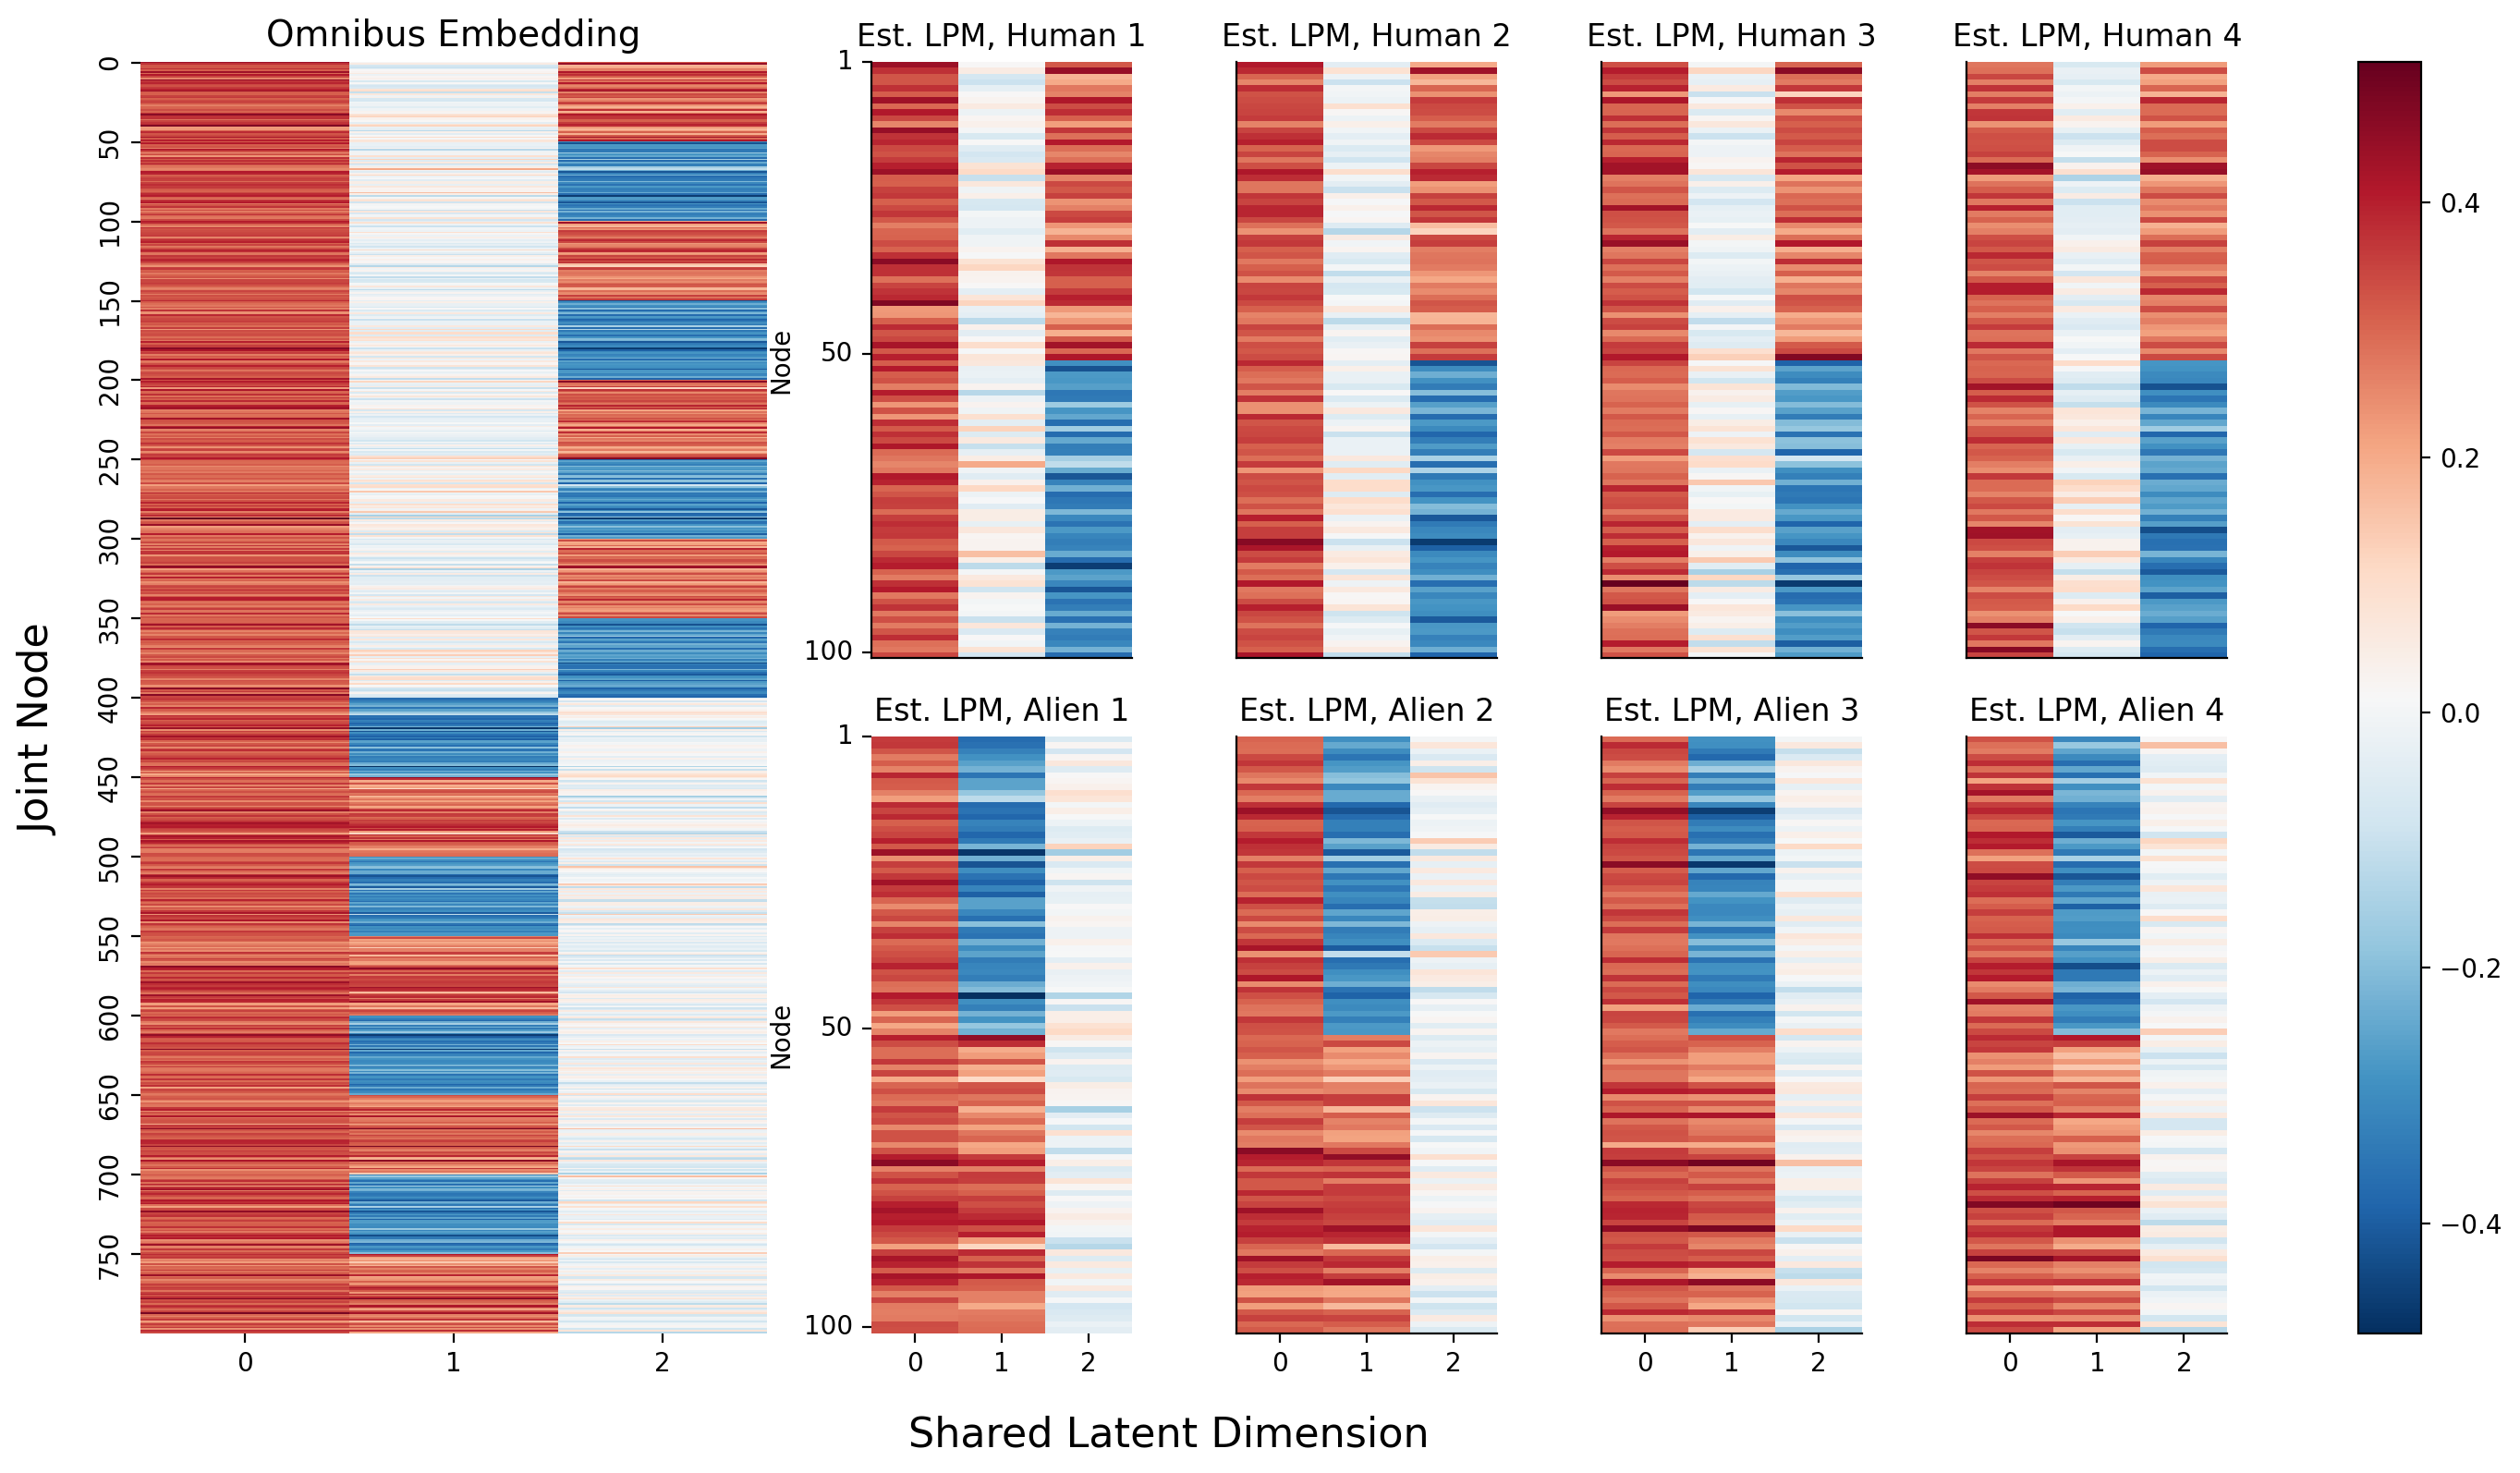

In [56]:
from myst_nb import glue

fig = plt.figure(figsize=(15, 8))
gs = GridSpec(4, 6)

hm_ax = fig.add_subplot(gs[:, :2])
vmin, vmax = np.array(joint_embedding).min(), np.array(joint_embedding).max()
hm = sns.heatmap(joint_embedding, cmap=cmap, ax=hm_ax, yticklabels=50, cbar=False, vmin=vmin, vmax=vmax);
hm.set_title("Omnibus Embedding", fontsize=14)
# hm.set(xlabel="Dimension", ylabel="Latent Positions")

ax0 = fig.add_subplot(gs[:2, 2])
ax1 = fig.add_subplot(gs[:2, 3])
ax2 = fig.add_subplot(gs[:2, 4])
ax3 = fig.add_subplot(gs[:2, 5])
ax4 = fig.add_subplot(gs[2:, 2])
ax5 = fig.add_subplot(gs[2:, 3])
ax6 = fig.add_subplot(gs[2:, 4])
ax7 = fig.add_subplot(gs[2:, 5])

for i, ax in enumerate([ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7]):
    plot = sns.heatmap(latent_networks[i], cmap=cmap, ax=ax, cbar=False, vmin=vmin, vmax=vmax)
    ax.set_yticks([0, 49, 99])
    ax.set_yticklabels([1, 50, 100])
    ax.set_ylabel("Node")
    plot.set_title("Est. LPM, " + titles[i])
    if ax in {ax0, ax1, ax2, ax3}:
        rm_ticks(ax, x=False, y=None)
    if ax in {ax1, ax2, ax3, ax5, ax6, ax7}:
        rm_ticks(ax, y=False, x=None)


# labels
fig.supxlabel("Shared Latent Dimension", x=.42, fontsize=16)
fig.supylabel("Joint Node", x=.005, fontsize=16)

# colorbar
norm = Normalize(vmin=vmin, vmax=vmax)
im = cm.ScalarMappable(cmap=cmap, norm=norm)

plt.tight_layout()
fig.colorbar(im, ax=np.array([hm_ax, ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7]));

Next, let's take a look at the estimated latent position matrix for the first human as a pairs plot, with the true community labels:

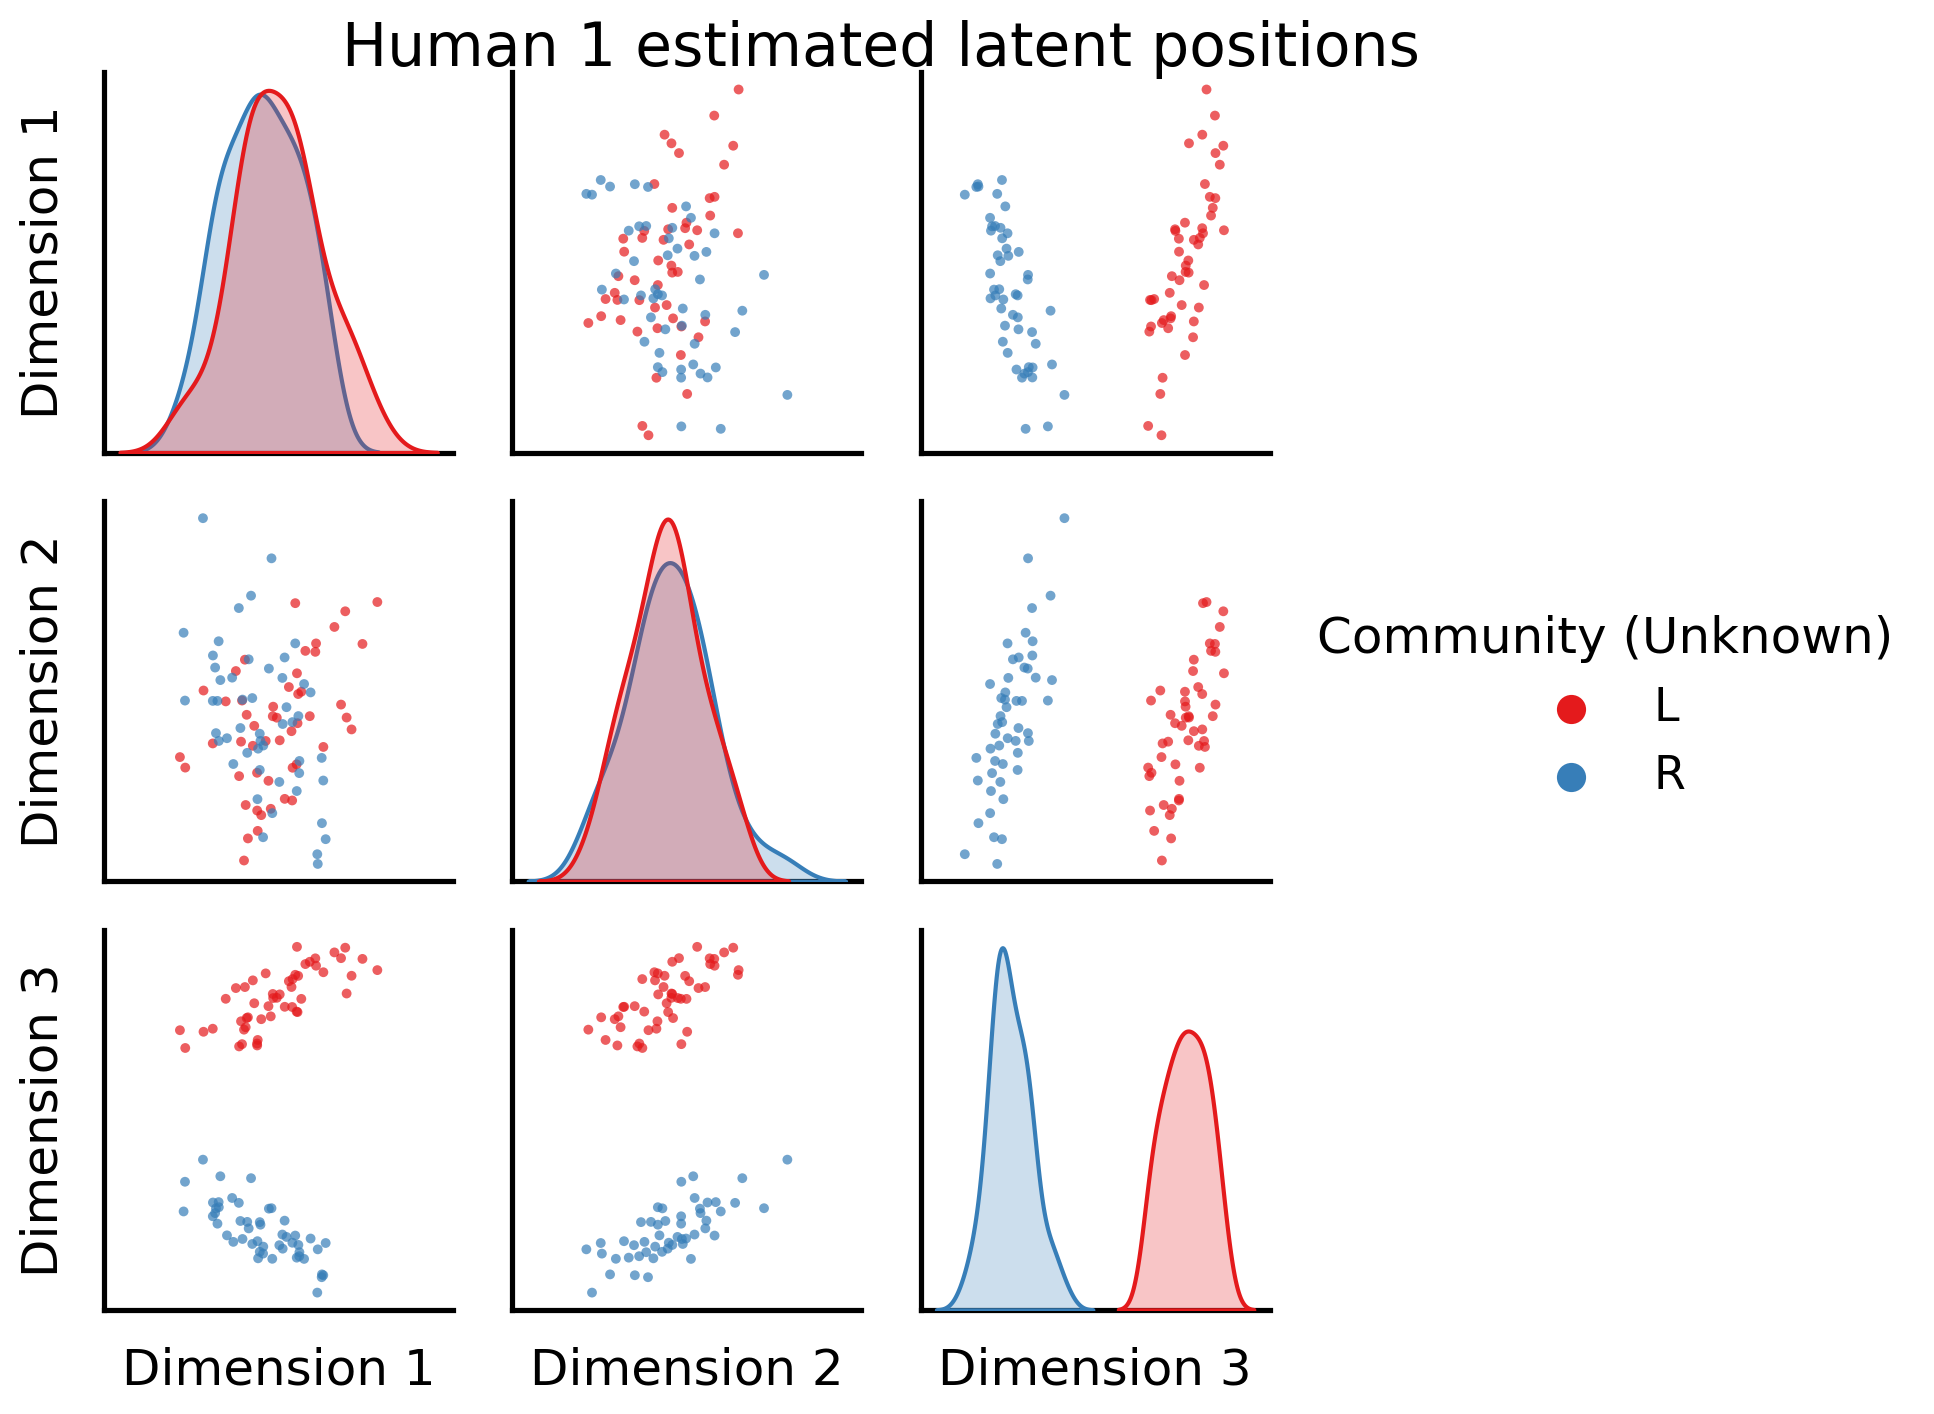

In [57]:
_ = pairplot(latent_networks[0], labels=human_labs, legend_name="Community (Unknown)", title="Human 1 estimated latent positions")

Cool! The communities are very well separated by the third embedding dimension. Next, the estimated latent positions for the first alien brain network:

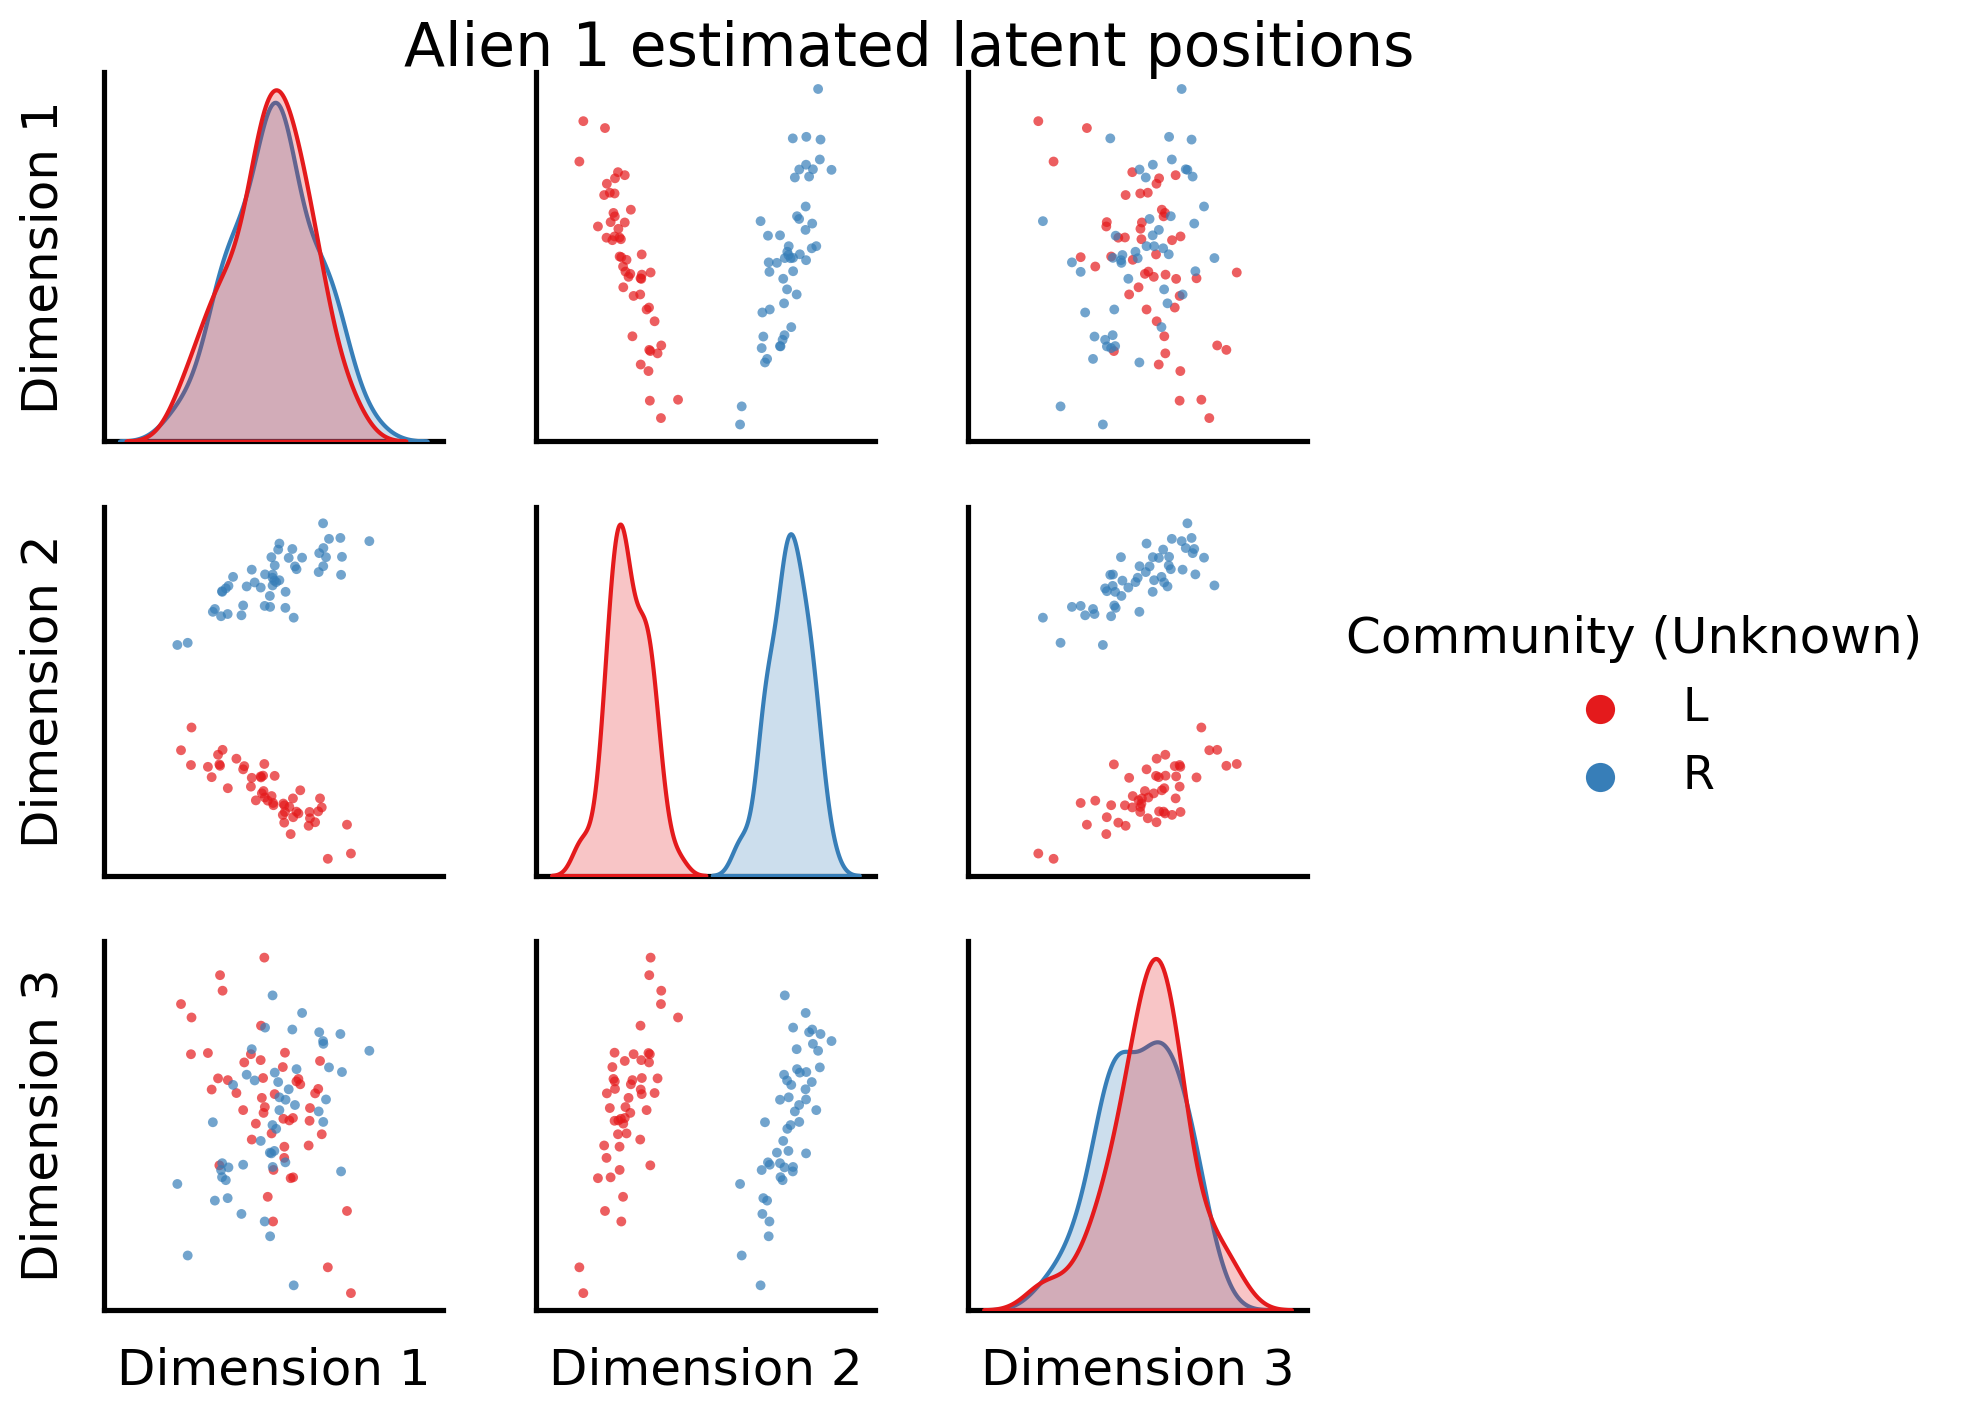

In [58]:
_ = pairplot(latent_networks[4], labels=alien_labs, legend_name="Community (Unknown)", title="Alien 1 estimated latent positions")

Awesome! shared latent dimension two clearly separates left from right communities.

## Why don't we just reorient the estimated latent positions manually?

Remember when we talked about non-identifiability in {numref}`ch6:spectral:nonidentifiable`, the core issue was that we had no way of differentiating latent positions from rotations of a given latent position. For a set of networks, instead of embedding them into a space in which they are all rotated with one another, couldn't we simply embed the networks, and *then* reorient the embeddings?

We sure can! For instance, say you want to figure out if two networks are generated from the same distribution (This means that the matrix that contains edge probabilities, ${P}$, is the same for both networks). Then, it's reasonable to assume that their estimated latent positions will be pretty close to each other. Let's structure this simple problem a little more formally. Basically, what we want to do is find a rotation matrix that will align the estimated latent positions as best as possible. Take a look at the equation below:

\begin{align*}
\hat W &= \min_{W} ||{\hat X^{(1)} - \hat X^{(2)}W}||_F^2
\end{align*}

Here:
- $W$ is a matrix that just rotates or flips (called an isometry, or an orthonormal matrix)
- $\hat X^{(1)}$ and $\hat X^{(2)}$ are the estimated latent positions for networks one and two, respectively

the $||X||_F$ syntax means that you're taking the frobenius norm of $X$. Taking the frobenius norm of a matrix is directly analogous to taking the sum of squared differences between a pair of matrices. So, in essence, what this equation says that you want to do is find the best possible rotation, $W$, such that the sum of squared differences between $X^{(1)}$ and $X^{(2)} W$ (the estimated latent positions, rotated by the rotation matrix $W$) is as small as possible.

But, there's that $W$ there, the rotation matrix. We actually wish we didn't have to find it. You have to because of the same problem you keep running into: you can rotate latent positions and they'll still have the same outer product relative to each other (that is, $XX^\top = XWW^\top X^\top$, since $WW^\top = I$ by definition of a rotation), and so you can only embed a network up to a rotation. 

For two networks, this is a feasible thing to do. However, when you have more than two networks, you have numerous considerations arise:
1. What is the objective function? Are we going to reorient all of the latent position matrix estimates relative a single arbitrary estimated latent position matrix?
2. Is there a way to choose the best estimated latent position matrix to reorient the others against?
3. How, exactly, are we even going to solve this thing?
4. Does this add compute power?
5. Does it add noise?
We don't really have an answer to the first two questions, but the answers to the remaining questions tend to leave the outcome the same. There are algorithms that solve this particular problem, which you will learn about later in the section on two-sample testing in {numref}`ch8:twosample`. However, these algorithms are extremely computationally intensive, especially when you have to compute them again and again repeatedly for many different networks or pairs of networks. Further, this process adds noise when it is repeatedly applied, particularly because it is pretty unclear what the best frame of reference to orient against is. 

Finally, and most succinctly: the Omnibus Embedding is fundamentally a solution to this problem. Because the embeddings for all of your networks live in the same space, you don't have to rotate them manually -- and you cut out the noise that gets added when you have to *infer* a good rotation matrix. You'll explore some the downstream use-cases in future chapters, but below is a sneak peak. 

The figure below (adapted from {cite:p}`Gopalakrishnan2020Nov`)  is the omnibus embedding for 32 networks created from a bunch of mouse brains, some of which have been genetically modified. The nodes of these networks represent the regions of a mouse brain and the edges represent how well-connected the neurons in a given pair of regions are. The figure below actually only shows two nodes: the node representing one region in the left hemisphere, and the node representing its corresponding region in the right hemisphere.

So what you're actually *plotting* in this embedding is a bit different than normal, because rather than being nodes, the points you plot are *networks*: one for each of your thirty-two mice. The only reason you're able to get away with doing this is the omnibus embedding: each network lives in the same space!

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from graspologic.embed import OmnibusEmbed
from graspologic.datasets import load_mice

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.patches import Ellipse
from scipy.stats.distributions import chi2


def _get_parameters(x, y):
    mu = np.array([x.mean(), y.mean()])
    cov = np.cov(x, y)
    return mu, cov


def _get_eigen(cov):
    eigvals, eigvecs = np.linalg.eigh(cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]
    return eigvals, eigvecs


def _get_ellipse_parameters(cov, ci):

    eigvals, eigvecs = _get_eigen(cov)

    # Calculate angle of displacement from x-axis
    theta = np.arctan2(*eigvecs[:, 0][::-1])
    theta = np.degrees(theta)

    # Calculate scaling factor based on probability
    dof = len(eigvals)
    alpha = 1 - (1 - ci) / 2
    scale = chi2.ppf(alpha, dof)
    width, height = 2 * np.sqrt(scale * eigvals)

    return width, height, theta


def make_ellipse(x, y, ci, **kwargs):
    mu, cov = _get_parameters(x, y)
    width, height, theta = _get_ellipse_parameters(cov, ci)
    ellipse = Ellipse(mu, width, height, theta, alpha=0.5, **kwargs)
    return ellipse


def draw_probability_ellipse(x, y, ci, **kwargs):
    ellipse = make_ellipse(x, y, ci, **kwargs)
    ax = plt.gca()
    ax.add_artist(ellipse)

    plot_kws = dict(alpha=0.75, s=15, linewidth=0, marker="o")
    ax.scatter(x, y, **plot_kws, **kwargs)


def munge_embedding(embedding, labels):
    col_names = [f"Dimension {i}" for i in range(1, embedding.shape[1] + 1)]
    df = pd.DataFrame(embedding, columns=col_names)
    df["Strain"] = labels
    return df


def _pairgrid(embedding, labels):
    df = munge_embedding(embedding, labels)

    palette = ["#e7298a", "#1b9e77", "#d95f02", "#7570b3"]
    plot_kws = dict(alpha=0.75, s=15, linewidth=0, marker="o")

    with sns.plotting_context("paper", font_scale=1):
        g = sns.PairGrid(df, hue="Strain", palette=palette, height=1.5)
        g = g.map_upper(sns.scatterplot, **plot_kws)
        g = g.map_diag(sns.kdeplot, lw=1, shade=True)
        g.set(xticks=[], yticks=[])

    return g


def ellipse_pairgrid(embedding, labels, ci, **kwargs):
    g = _pairgrid(embedding, labels)
    kwargs["ci"] = ci
    g = g.map_lower(draw_probability_ellipse, **kwargs)
    return g

# Load the full mouse dataset
mice = load_mice()

# Stack all adjacency matrices in a 3D numpy array
graphs = np.array(mice.graphs)

# Sort the connectomes and genotypic labels so BTBR is first
label_indices = np.argsort(mice.labels).reshape(4, 8)
label_indices = label_indices[[1, 0, 2, 3]].reshape(-1)

labels = mice.labels[label_indices]
mapping = dict(BTBR="Genetically Modified Mice", B6="First Normal Group", 
               CAST="Second Normal Group", DBA2="Third Normal Group")
labels = [mapping[old] for old in labels]
graphs = graphs[label_indices]

# Jointly embed graphs using omnibus embedding
embedder = OmnibusEmbed()
omni_embedding = embedder.fit_transform(graphs)


# Get index for the input structure
index = mice.atlas.query(f"Structure == 'Corpus_Callosum'")["ROI"].values[0]
index -= 1

# Make the plot
g = ellipse_pairgrid(omni_embedding[:, index, :3], labels, ci=0.9)
g.fig.suptitle("Mouse Networks Corresponding to a Single Node \nAfter Omnibus Embedding", y=1.08)
g.fig.set(dpi=300)
g.add_legend()
plt.show()
g.add_legend(title="Type of Mouse");
sns.move_legend(g, "center right", frameon=True)

You can clearly see a difference between the genetically modified mice and the normal mice. The genetically modified mice are off in their own cluster; if you're familiar with classical statistics, you could do a MANOVA here and find that the genetically modified mice are significantly different from the rest - if you wanted to, you could figure out which mice are genetically modified, even without having that information in advance!

### Relating the omnibus joint embedding to the heterogeneous random dot product graph

If you assume that your networks are all *heterogeneous* random dot product graphs, you can use the omnibus embedding to describe things about them. Remember that as you learned in chapter 5, a *heterogeneous* collection of networks is a set of random networks $\{\mathbf A^{(1)}, ..., \mathbf A^{(M)}\}$ where the underlying probability matrices $\{P^{(1)}, ..., P^{(M)}\}$ are not all the same. What this means is that for at least two networks $i$ and $j$, that $P^{(i)} \neq P^{(j)}$. 

If you think that a heterogeneous collection of random networks are described by random dot product graphs, what this means is that for each random network $\mathbf A^{(i)}$, you think that this network has its own unique latent position matrix $X^{(i)}$, where its corresponding probability matrix $P^{(i)} = X^{(i)}X^{(i)\top}$. 

When you produced a joint embedding for each network using the omnibus embedding, what you really did was produced estimates of $\hat X^{(i)}$ for each of your $i$ networks. In mathematical notation, if you made the assumption that the networks were heterogeneous random dot product graphs, your omnibus joint embedding was really just this:
\begin{align*}
    \text{Omnibus embedding} &= \begin{bmatrix}
        \hat X^{(1)} \\
        \hat X^{(2)} \\
        \vdots \\
        \hat X^{(M)}
    \end{bmatrix}
\end{align*}
where each of the $\hat X^{(i)}$ was an $n \times d$ matrix, so the full omnibus embedding was an $Mn \times d$ matrix.

When you produced an omnibus embedding, if you pull out the individual estimated latent positions for each network, you can then make statements about the corresponding *estimates of latent positions* and learn about how they impact the *probability matrix*, since you can estimate the probability matrix just using $\hat P^{(i)} = \hat X^{(i)}\hat X^{(i)\top}$. Again, we would emphasize that the omnibus embedding is a tool that can be used *outside* of assuming the heterogeneous random dot product graph model. The only impact that the assumption of the heterogeneous random dot product graph model gives you is the fact that you can use these embeddings to learn about the probability matrix $P^{(i)}$. For a full discussion on the implications of these results, check out the Appendix {numref}`app:ch13:spectral` or {cite:p}`Levin2017` and {cite:p}`Athreya2017Jan`.

## References

```{bibliography}
:filter: docname in docnames
:style: unsrt
```